<a href="https://colab.research.google.com/github/Jaehyeonee/ktcloud_genai/blob/main/105_LLM_%EC%96%B8%EC%96%B4AI%EC%9D%98%EC%B5%9C%EA%B7%BC%EC%97%AD%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 언어 AI의 최근 역사



---


- 💡**참고 교재**
    - 핸즈온LLM https://www.hanbit.co.kr/store/books/look.php?p_code=B2599445240
- 💡 **NOTE**
    - 이 노트북의 코드를 실행하려면 GPU를 사용하는 것이 좋습니다. 구글 코랩에서는 **런타임 > 런타임 유형 변경 > 하드웨어 가속기 > T4 GPU**를 선택하세요.
    - **T4 GPU | 16 VRAM(Video Random Access Memory)**
---



**[주의!] (코랩)한글 폰트 지정하는 방법**

/usr/share/fonts:
truetype

/usr/share/fonts/truetype:
humor-sans
liberation

/usr/share/fonts/truetype/humor-sans:
Humor-Sans.ttf

/usr/share/fonts/truetype/liberation:
LiberationMono-BoldItalic.ttf
LiberationMono-Bold.ttf
LiberationMono-Italic.ttf
LiberationMono-Regular.ttf
LiberationSans-BoldItalic.ttf
LiberationSans-Bold.ttf
LiberationSans-Italic.ttf
LiberationSansNarrow-BoldItalic.ttf
LiberationSansNarrow-Bold.ttf
LiberationSansNarrow-Italic.ttf
LiberationSansNarrow-Regular.ttf
LiberationSans-Regular.ttf
LiberationSerif-BoldItalic.ttf
LiberationSerif-Bold.ttf
LiberationSerif-Italic.ttf
LiberationSerif-Regular.ttf
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease

✅ 나눔폰트 설정 완료


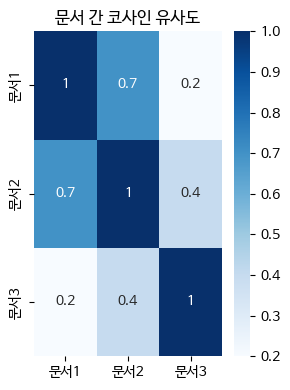

In [1]:
# 0) 환경 점검: 설치된 폰트 실제 파일이 있는지 먼저 확인
!ls -R /usr/share/fonts | head -n 50

# 1) (이미 설치했다면 생략 가능) 한글 폰트 설치
!apt-get -y update
!apt-get -y install fonts-nanum fonts-noto-cjk

# 2) 시스템 폰트 캐시 재생성
!fc-cache -fv

# 3) Matplotlib 내부 폰트 캐시 삭제 (중요)
import os, shutil
import matplotlib
cache_dir = matplotlib.get_cachedir()      # 보통 ~/.cache/matplotlib
# print("matplotlib cache:", cache_dir)
shutil.rmtree(cache_dir, ignore_errors=True)

# 4) 런타임 재시작 필요 없이, 폰트 매니저 강제 리로드
from matplotlib import font_manager
_ = font_manager._load_fontmanager(try_read_cache=False)

# 5) 폰트 존재 여부 확인 (fc-list와 파이썬에서 모두 확인)
# !fc-list | grep -i "nanum\|noto" | head -n 40

# from matplotlib import font_manager
# fonts = font_manager.findSystemFonts()
# [f for f in fonts if ("Nanum" in f or "NotoSansCJK" in f or "Noto" in f)][:10]


# 6) 한글 폰트 지정
import seaborn as sns
import numpy as np
from matplotlib import font_manager, pyplot as plt

font_path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
font_manager.fontManager.addfont(font_path)
family_name = font_manager.FontProperties(fname=font_path).get_name()
# print("적용할 패밀리명:", family_name)

# plt.rcParams["font.family"] = 'NanumBarunGothic'
plt.rcParams["font.family"] = family_name # NanumBarunGothic
plt.rcParams["axes.unicode_minus"] = False
print("✅ 나눔폰트 설정 완료")# 폰트 지정


# 7) 예시 데이터
documents = ["문서1","문서2","문서3"]
similarity_matrix = np.array([[1.0,0.7,0.2],
                              [0.7,1.0,0.4],
                              [0.2,0.4,1.0]])

plt.figure(figsize=(3,4))
sns.heatmap(similarity_matrix,
            annot=True,
            cmap='Blues',
            xticklabels=[f'문서{i+1}' for i in range(len(documents))],
            yticklabels=[f'문서{i+1}' for i in range(len(documents))])
plt.title('문서 간 코사인 유사도')
plt.tight_layout()
plt.show()



---



## **1. BoW(Bag-of-Words)**

- **비구조적인 텍스트를 표현**하는 한 방법
- 1950년대에 언급되었지만 2000년대에 인기를 얻음
- 공백을 기준으로 개별 단어로 분할--> Token
- **토큰화(Tokenization)** 과정:  
    - 문장을 개별 단어나 부분단어(subword)로 분할하는 과정
- **BoW의 목표**:  
    - **벡터(or 벡터 표현)라고 부르는 수치 형태로 텍스트를 표현**
- 이런 모델을 **표현 모델(representation model)** 이라고 부름

### **예제 : BoW 구현하고 텍스트 분류하기**

#### **BoW Basic Class(직접 구현)**

In [2]:
import numpy as np
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False


class BagOfWords:
    def __init__(self, min_freq=1, max_vocab_size=None, remove_stopwords=True):
        """
        Bag of Words 구현 클래스

        Args:
            min_freq: 최소 단어 빈도
            max_vocab_size: 최대 어휘 크기
            remove_stopwords: 불용어 제거 여부
        """
        self.min_freq = min_freq
        self.max_vocab_size = max_vocab_size
        self.remove_stopwords = remove_stopwords
        self.vocab = {}
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.vocab_size = 0

        # 한국어 불용어 (간단한 예제)
        self.stopwords = {
            '은', '는', '이', '가', '을', '를', '에', '에서', '로', '으로',
            '의', '와', '과', '도', '만', '까지', '부터', '조차', '마저',
            '그리고', '그러나', '하지만', '또한', '그래서', '따라서'
        }

    def preprocess_text(self, text):
        """텍스트 전처리"""
        # 소문자 변환 및 특수문자 제거 (한글 보존)
        text = re.sub(r'[^\w\s가-힣]', '', text.lower())
        words = text.split()

        # 불용어 제거
        if self.remove_stopwords:
            words = [word for word in words if word not in self.stopwords]

        return [word for word in words if word.strip()]

    def build_vocab(self, documents):
        """어휘 구축"""
        word_counts = Counter()

        # 모든 문서에서 단어 빈도 계산
        for doc in documents:
            words = self.preprocess_text(doc)
            word_counts.update(words)

        # 최소 빈도 필터링
        filtered_words = {word: count for word, count in word_counts.items()
                         if count >= self.min_freq}

        # 빈도순 정렬
        sorted_words = sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)

        # 최대 어휘 크기 제한
        if self.max_vocab_size:
            sorted_words = sorted_words[:self.max_vocab_size]

        # 어휘 매핑 생성
        self.vocab = dict(sorted_words)
        self.word_to_idx = {word: idx for idx, (word, _) in enumerate(sorted_words)}
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.vocab_size = len(self.vocab)

        print(f"구축된 어휘 크기: {self.vocab_size}")
        return self.vocab

    def text_to_bow(self, text):
        """텍스트를 BoW 벡터로 변환"""
        words = self.preprocess_text(text)
        bow_vector = np.zeros(self.vocab_size)

        for word in words:
            if word in self.word_to_idx:
                idx = self.word_to_idx[word]
                bow_vector[idx] += 1

        return bow_vector

    def documents_to_bow_matrix(self, documents):
        """문서들을 BoW 행렬로 변환"""
        bow_matrix = []
        for doc in documents:
            bow_vector = self.text_to_bow(doc)
            bow_matrix.append(bow_vector)

        return np.array(bow_matrix)

    def get_top_words(self, bow_vector, top_n=5):
        """BoW 벡터에서 상위 단어들 추출"""
        word_scores = [(self.idx_to_word[idx], score)
                      for idx, score in enumerate(bow_vector) if score > 0]
        word_scores.sort(key=lambda x: x[1], reverse=True)
        return word_scores[:top_n]

    def calculate_similarity(self, doc1, doc2):
        """두 문서 간 코사인 유사도 계산"""
        bow1 = self.text_to_bow(doc1)
        bow2 = self.text_to_bow(doc2)

        # 코사인 유사도
        dot_product = np.dot(bow1, bow2)
        norm1 = np.linalg.norm(bow1)
        norm2 = np.linalg.norm(bow2)

        if norm1 == 0 or norm2 == 0:
            return 0.0

        return dot_product / (norm1 * norm2)


#### **1. 기본 BoW 구현 시연**

In [3]:
# ----------------------------
# 예제 문서들
# ----------------------------
documents = [
    "강아지는 귀여운 동물입니다",
    "고양이도 귀여운 반려동물입니다",
    "반려동물은 가족과 같습니다",
    "인공지능은 미래 기술입니다",
    "기술 발전은 빠릅니다",
    "미래에는 로봇이 일상이 될 것입니다"
] # 6 docs

# documents = [
#     "자연언어처리는 인공지능의 중요한 분야입니다",
#     "머신러닝과 딥러닝이 자연언어처리를 발전시켰습니다",
#     "텍스트 마이닝은 빅데이터 분석에 활용됩니다",
#     "감정분석과 문서분류는 NLP의 대표적인 응용분야입니다",
#     "챗봇과 번역시스템이 일상생활에 널리 사용됩니다"
# ]

In [4]:
def demonstrate_bow_basic(documents):
    """기본 BoW 시연"""
    print("=" * 50)
    print("✅ 1. 기본 BoW 구현 시연")
    print("=" * 50)

    # ----------------------------
    # BoW 모델 생성 및 학습
    # ----------------------------
    bow_model = BagOfWords(min_freq=1, remove_stopwords=True)
    vocab = bow_model.build_vocab(documents)

    print("\n➡️ 구축된 어휘:")
    for word, freq in list(vocab.items())[:10]:
        print(f"  {word}: {freq}")

    # ----------------------------
    # 문서를 BoW 벡터로 변환
    # ----------------------------
    print("\n➡️ 문서별 BoW 벡터:")
    for i, doc in enumerate(documents):
        bow_vector = bow_model.text_to_bow(doc)
        top_words = bow_model.get_top_words(bow_vector, top_n=3)
        print(f"\n문서 {i+1}: {doc}")
        print(f"BoW 벡터 형태: {bow_vector.shape}")
        print(f"상위 단어: {top_words}")

    # ----------------------------
    # 문서 간 유사도 계산
    # ----------------------------
    print("\n➡️ 문서 간 유사도:")
    for i in range(len(documents)):
        for j in range(i+1, len(documents)):
            similarity = bow_model.calculate_similarity(documents[i], documents[j])
            print(f"문서{i+1} vs 문서{j+1}: {similarity:.4f}")


# 테스트
demonstrate_bow_basic(documents)

✅ 1. 기본 BoW 구현 시연
구축된 어휘 크기: 19

➡️ 구축된 어휘:
  귀여운: 2
  강아지는: 1
  동물입니다: 1
  고양이도: 1
  반려동물입니다: 1
  반려동물은: 1
  가족과: 1
  같습니다: 1
  인공지능은: 1
  미래: 1

➡️ 문서별 BoW 벡터:

문서 1: 강아지는 귀여운 동물입니다
BoW 벡터 형태: (19,)
상위 단어: [('귀여운', np.float64(1.0)), ('강아지는', np.float64(1.0)), ('동물입니다', np.float64(1.0))]

문서 2: 고양이도 귀여운 반려동물입니다
BoW 벡터 형태: (19,)
상위 단어: [('귀여운', np.float64(1.0)), ('고양이도', np.float64(1.0)), ('반려동물입니다', np.float64(1.0))]

문서 3: 반려동물은 가족과 같습니다
BoW 벡터 형태: (19,)
상위 단어: [('반려동물은', np.float64(1.0)), ('가족과', np.float64(1.0)), ('같습니다', np.float64(1.0))]

문서 4: 인공지능은 미래 기술입니다
BoW 벡터 형태: (19,)
상위 단어: [('인공지능은', np.float64(1.0)), ('미래', np.float64(1.0)), ('기술입니다', np.float64(1.0))]

문서 5: 기술 발전은 빠릅니다
BoW 벡터 형태: (19,)
상위 단어: [('기술', np.float64(1.0)), ('발전은', np.float64(1.0)), ('빠릅니다', np.float64(1.0))]

문서 6: 미래에는 로봇이 일상이 될 것입니다
BoW 벡터 형태: (19,)
상위 단어: [('미래에는', np.float64(1.0)), ('로봇이', np.float64(1.0)), ('일상이', np.float64(1.0))]

➡️ 문서 간 유사도:
문서1 vs 문서2: 0.3333
문서1 vs 문서3: 0.0000
문서1 vs 문서4: 0.000

#### **2. sklearn을 활용한 고급 BoW**


✅ 2. sklearn을 활용한 고급 BoW
➡️ CountVectorizer 결과:
특성 수: 18
행렬 형태: (6, 18)
특성 예시: ['가족과', '강아지는', '같습니다', '것입니다', '고양이도', '귀여운', '기술', '기술입니다', '동물입니다', '로봇이']

➡️ TF-IDF 행렬 형태: (6, 18)

➡️ 각 문서의 상위 TF-IDF 단어:
문서 1: [('강아지는', np.float64(0.6117125098631682)), ('동물입니다', np.float64(0.6117125098631682)), ('귀여운', np.float64(0.501613008756558))]
문서 2: [('고양이도', np.float64(0.6117125098631682)), ('반려동물입니다', np.float64(0.6117125098631682)), ('귀여운', np.float64(0.501613008756558))]
문서 3: [('가족과', np.float64(0.5773502691896257)), ('반려동물은', np.float64(0.5773502691896257)), ('같습니다', np.float64(0.5773502691896257))]
문서 4: [('인공지능은', np.float64(0.5773502691896257)), ('미래', np.float64(0.5773502691896257)), ('기술입니다', np.float64(0.5773502691896257))]
문서 5: [('발전은', np.float64(0.5773502691896257)), ('빠릅니다', np.float64(0.5773502691896257)), ('기술', np.float64(0.5773502691896257))]
문서 6: [('일상이', np.float64(0.5)), ('로봇이', np.float64(0.5)), ('것입니다', np.float64(0.5))]

➡️ 유사도 매트릭스 형태: (6, 6)


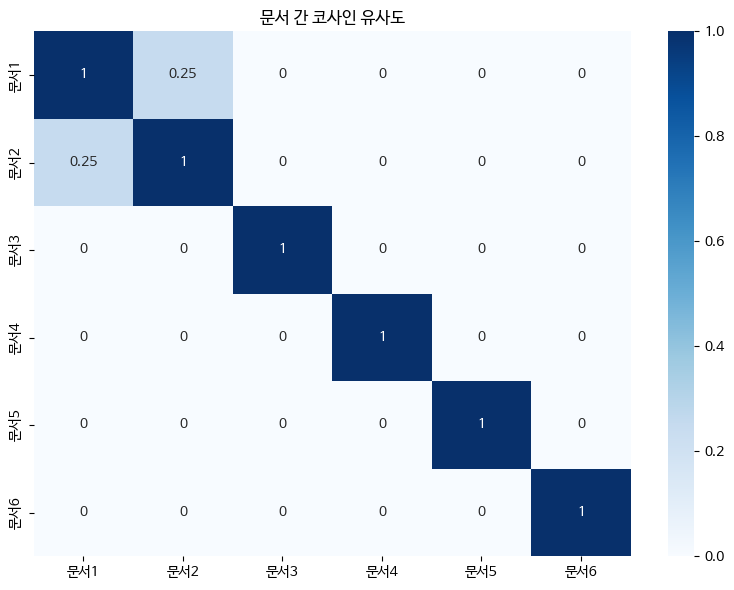

In [6]:
def demonstrate_bow_with_sklearn(documents):
    """sklearn을 활용한 고급 BoW"""
    print("\n" + "=" * 50)
    print("✅ 2. sklearn을 활용한 고급 BoW")
    print("=" * 50)

    # ----------------------------
    # 1. CountVectorizer (기본 BoW)
    # ----------------------------
    count_vectorizer = CountVectorizer()
    count_matrix = count_vectorizer.fit_transform(documents)

    print("➡️ CountVectorizer 결과:")
    print(f"특성 수: {len(count_vectorizer.get_feature_names_out())}")
    print(f"행렬 형태: {count_matrix.shape}")

    # 특성 이름들
    feature_names = count_vectorizer.get_feature_names_out()
    print(f"특성 예시: {list(feature_names)[:10]}")

    # ----------------------------
    # 2. TF-IDF
    # ----------------------------
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

    print(f"\n➡️ TF-IDF 행렬 형태: {tfidf_matrix.shape}")

    # 문서별 상위 TF-IDF 단어
    tfidf_array = tfidf_matrix.toarray()
    feature_names = tfidf_vectorizer.get_feature_names_out()

    print("\n➡️ 각 문서의 상위 TF-IDF 단어:")
    for i, doc in enumerate(documents):
        # 해당 문서의 TF-IDF 점수
        tfidf_scores = tfidf_array[i]
        # 상위 3개 단어 인덱스
        top_indices = np.argsort(tfidf_scores)[-3:][::-1]
        top_words = [(feature_names[idx], tfidf_scores[idx]) for idx in top_indices if tfidf_scores[idx] > 0]

        print(f"문서 {i+1}: {top_words}")

    # 문서 간 유사도 매트릭스
    similarity_matrix = cosine_similarity(tfidf_matrix)

    print(f"\n➡️ 유사도 매트릭스 형태: {similarity_matrix.shape}")

    # 유사도 히트맵 시각화
    plt.figure(figsize=(8, 6))
    plt.rcParams["font.family"] = 'NanumBarunGothic'
    sns.heatmap(similarity_matrix,
                annot=True,
                cmap='Blues',
                xticklabels=[f'문서{i+1}' for i in range(len(documents))],
                yticklabels=[f'문서{i+1}' for i in range(len(documents))])
    plt.title('문서 간 코사인 유사도')
    plt.tight_layout()
    plt.show()


# 테스트
demonstrate_bow_with_sklearn(documents)

#### **3. BoW 를 이용한 텍스트 분류**

In [7]:
def demonstrate_bow_applications():
    """BoW 응용 예제"""
    print("\n" + "=" * 50)
    print("✅ 3. BoW 실전 응용 - 텍스트 분류")
    print("=" * 50)

    # 카테고리별 예제 데이터
    tech_docs = [
        "인공지능과 머신러닝 기술이 급속히 발전하고 있습니다",
        "딥러닝은 신경망을 기반으로 한 기계학습 방법입니다",
        "자연언어처리 기술로 텍스트를 자동으로 분석할 수 있습니다",
        "컴퓨터 비전은 이미지 인식과 처리에 사용됩니다"
    ]

    sports_docs = [
        "축구는 전 세계에서 가장 인기 있는 스포츠입니다",
        "올림픽에서 다양한 종목의 경기가 열립니다",
        "농구는 팀워크가 중요한 운동입니다",
        "수영은 전신을 사용하는 유산소 운동입니다"
    ]

    food_docs = [
        "한식은 발효음식이 많아 건강에 좋습니다",
        "이탈리아 파스타는 다양한 소스와 함께 즐깁니다",
        "일본 초밥은 신선한 재료가 핵심입니다",
        "프랑스 요리는 정교한 조리법으로 유명합니다"
    ]

    # 전체 문서와 라벨
    all_docs = tech_docs + sports_docs + food_docs
    labels = ['기술'] * len(tech_docs) + ['스포츠'] * len(sports_docs) + ['음식'] * len(food_docs)

    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer(max_features=100)
    doc_vectors = vectorizer.fit_transform(all_docs)

    print(f"➡️ 문서 수: {len(all_docs)}")
    print(f"➡️ 특성 수: {doc_vectors.shape[1]}")

    # 카테고리별 대표 단어 추출
    feature_names = vectorizer.get_feature_names_out()

    # 카테고리별 평균 TF-IDF 계산
    categories = ['기술', '스포츠', '음식']
    category_vectors = {}

    for category in categories:
        # 해당 카테고리의 문서 인덱스
        category_indices = [i for i, label in enumerate(labels) if label == category]

        # 해당 카테고리 문서들의 평균 벡터
        category_matrix = doc_vectors[category_indices]
        avg_vector = np.mean(category_matrix.toarray(), axis=0)
        category_vectors[category] = avg_vector

        # 상위 단어들
        top_indices = np.argsort(avg_vector)[-5:][::-1]
        top_words = [feature_names[idx] for idx in top_indices]

        print(f"\n{category} 카테고리 대표 단어: {top_words}")

    # 새로운 문서 분류 예제
    test_docs = [
        "딥러닝 모델을 학습시키는 방법을 알아보겠습니다",
        "월드컵 축구 경기가 열렸습니다",
        "맛있는 김치찌개 레시피를 소개합니다"
    ]

    print(f"\n➡️ 새로운 문서 분류:")
    test_vectors = vectorizer.transform(test_docs)

    for i, test_doc in enumerate(test_docs):
        test_vector = test_vectors[i].toarray()[0]

        # 각 카테고리와의 유사도 계산
        similarities = {}
        for category, category_vector in category_vectors.items():
            similarity = cosine_similarity([test_vector], [category_vector])[0][0]
            similarities[category] = similarity

        # 가장 유사한 카테고리
        predicted_category = max(similarities.items(), key=lambda x: x[1])

        print(f"\n 테스트 문서: {test_doc}")
        print(f" 유사도 - {similarities}")
        print(f" 예측 카테고리: {predicted_category[0]} (유사도: {predicted_category[1]:.4f})")

# 테스트
demonstrate_bow_applications()


✅ 3. BoW 실전 응용 - 텍스트 분류
➡️ 문서 수: 12
➡️ 특성 수: 61

기술 카테고리 대표 단어: ['있습니다', '방법입니다', '딥러닝은', '기반으로', '신경망을']

스포츠 카테고리 대표 단어: ['운동입니다', '중요한', '팀워크가', '농구는', '종목의']

음식 카테고리 대표 단어: ['핵심입니다', '한식은', '프랑스', '초밥은', '좋습니다']

➡️ 새로운 문서 분류:

 테스트 문서: 딥러닝 모델을 학습시키는 방법을 알아보겠습니다
 유사도 - {'기술': np.float64(0.0), '스포츠': np.float64(0.0), '음식': np.float64(0.0)}
 예측 카테고리: 기술 (유사도: 0.0000)

 테스트 문서: 월드컵 축구 경기가 열렸습니다
 유사도 - {'기술': np.float64(0.0), '스포츠': np.float64(0.22026753301635316), '음식': np.float64(0.0)}
 예측 카테고리: 스포츠 (유사도: 0.2203)

 테스트 문서: 맛있는 김치찌개 레시피를 소개합니다
 유사도 - {'기술': np.float64(0.0), '스포츠': np.float64(0.0), '음식': np.float64(0.0)}
 예측 카테고리: 기술 (유사도: 0.0000)


#### **4. BoW 특성 분석**

In [8]:
def analyze_bow_characteristics():
    """BoW 특성 분석"""
    print("\n" + "=" * 50)
    print("✅ 4. BoW 특성 분석")
    print("=" * 50)

    documents = [
        "고양이가 집에서 잠을 잡니다",
        "집에서 고양이가 잠을 잡니다",  # 어순이 다른 같은 의미
        "강아지가 공원에서 뛰어놉니다",
        "공원에서 강아지가 뛰어놉니다"   # 어순이 다른 같은 의미
    ]

    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(documents)
    print('bow_matrix type: ', type(bow_matrix))   # <class 'scipy.sparse._csr.csr_matrix'>

    print("➡️ BoW의 특성 분석:")

    print("\n1. 어순 무시 특성:")
    # 어순이 다른 문서들의 벡터 비교
    bow_array = bow_matrix.toarray()
    for i in range(0, len(documents), 2): # 2개씩 비교
        vec1 = bow_array[i]
        vec2 = bow_array[i+1]
        similarity = cosine_similarity([vec1], [vec2])[0][0]

        print(f"문서 {i+1}: {documents[i]}")
        print(f"문서 {i+2}: {documents[i+1]}")
        print(f"유사도: {similarity:.4f} (완전히 같음)" if similarity == 1.0 else f"유사도: {similarity:.4f}")
        print()

    # 희소성 분석
    total_elements = bow_matrix.shape[0] * bow_matrix.shape[1]
    non_zero_elements = bow_matrix.nnz
    sparsity = 1 - (non_zero_elements / total_elements)

    print(f"2. 희소성(Sparsity) 분석:")
    print(f"전체 원소 수: {total_elements}")
    print(f"0이 아닌 원소 수: {non_zero_elements}")
    print(f"희소성: {sparsity:.4f} ({sparsity*100:.2f}%)")

    # 차원 분석
    feature_names = vectorizer.get_feature_names_out()
    print(f"\n3. 차원 분석:")
    print(f"문서 수: {bow_matrix.shape[0]}")
    print(f"특성(단어) 수: {bow_matrix.shape[1]}")
    print(f"특성들: {list(feature_names)}")


# 테스트
analyze_bow_characteristics()


✅ 4. BoW 특성 분석
bow_matrix type:  <class 'scipy.sparse._csr.csr_matrix'>
➡️ BoW의 특성 분석:

1. 어순 무시 특성:
문서 1: 고양이가 집에서 잠을 잡니다
문서 2: 집에서 고양이가 잠을 잡니다
유사도: 1.0000 (완전히 같음)

문서 3: 강아지가 공원에서 뛰어놉니다
문서 4: 공원에서 강아지가 뛰어놉니다
유사도: 1.0000

2. 희소성(Sparsity) 분석:
전체 원소 수: 28
0이 아닌 원소 수: 14
희소성: 0.5000 (50.00%)

3. 차원 분석:
문서 수: 4
특성(단어) 수: 7
특성들: ['강아지가', '고양이가', '공원에서', '뛰어놉니다', '잠을', '잡니다', '집에서']




---



## **3. TF-IDF(Term Frequency-Inverse Document Frequency)**
- TF-IDF :
    - 문서 내에서 단어의 중요도를 측정하는 가중치 기법으로, 단어 빈도(TF)와 역문서 빈도(IDF)를 결합하여 각 단어가 특정 문서에서 얼마나 중요한지를 수치화함
    - TF-IDF 값이 낮으면 중요도가 낮은 것, TF-IDF 값이 크면 중요도가 큰 것
    - 참고 : https://wikidocs.net/31698
- 등장 배경
    - 단순한 단어 빈도만으로는 문서의 주제를 정확히 파악하기 어려웠음
    - 예를 들어 "그리고", "그러나" 같은 단어는 자주 나타나지만 문서의 내용과는 관련이 적음. --> TF-IDF는 이런 문제를 해결하기 위해 개발

**기본 TF-IDF 계산 과정:**

1. **단어 빈도 (TF) 계산**
   - Raw TF: $tf(t,d) = f(t,d)$
   - Relative TF: $tf(t,d) = f(t,d) / Σf(w,d)$
   - Log TF: $tf(t,d) = 1 + log(f(t,d))$ (f(t,d) > 0인 경우)

2. **역문서 빈도 (IDF) 계산**
   - Basic IDF: $idf(t) = log(N / df(t))$
   - Smooth IDF: $idf(t) = log(N / (1 + df(t)))$
   - Probabilistic IDF: $idf(t) = log((N - df(t)) / df(t))$

3. **최종 TF-IDF 가중치**
   -   $w(t,d) = tf(t,d) × idf(t)$

여기서:
- t: 단어 (term)
- d: 문서 (document)
- f(t,d): 문서 d에서 단어 t의 빈도
- N: 전체 문서 수
- df(t): 단어 t가 포함된 문서 수

**정규화 공식**
|정규화 방법|공식|목적|
|------|---|---|
|L1 정규화 | `w'(t,d) = w(t,d) / Σ | w(i,d)  |
|L2 정규화| w'(t,d) = w(t,d) / √(Σw(i,d)²)| 벡터의 크기가 1이 되도록 조정|
|코사인 정규화| `sim(d1,d2) = (d1·d2) / (| d1 |

### **예제 : TF-IDF 실전 응용 - 문서 분류 및 클러스터링**

#### **TF-IDF Basic Class(직접 구현)**

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')


# ----------------------------
# TF-IDF(수식구현 클래스)
# ----------------------------
class TFIDFImplementation:
    def __init__(self, use_log_tf=True, smooth_idf=True, normalize=True):
        """
        TF-IDF 완전 구현 클래스

        Args:
            use_log_tf: 로그 TF 사용 여부
            smooth_idf: 스무스 IDF 사용 여부
            normalize: L2 정규화 사용 여부
        """
        self.use_log_tf = use_log_tf
        self.smooth_idf = smooth_idf
        self.normalize = normalize
        self.vocab = {}
        self.idf_values = {}
        self.documents = []

    def preprocess_text(self, text):
        """텍스트 전처리"""
        # 소문자 변환 및 특수문자 제거 (한글 보존)
        text = re.sub(r'[^\w\s가-힣]', '', text.lower())
        return [word for word in text.split() if word.strip()]

    def build_vocabulary(self, documents):
        """어휘 구축 및 IDF 계산"""
        self.documents = documents

        # 전체 어휘 수집
        all_words = set()
        processed_docs = []

        for doc in documents:
            words = self.preprocess_text(doc)
            processed_docs.append(words)
            all_words.update(words)

        # 어휘 인덱싱
        self.vocab = {word: idx for idx, word in enumerate(sorted(all_words))}
        vocab_size = len(self.vocab)

        # 각 단어가 포함된 문서 수 계산
        doc_freq = defaultdict(int)
        for words in processed_docs:
            unique_words = set(words)
            for word in unique_words:
                doc_freq[word] += 1

        # IDF 계산
        total_docs = len(documents)
        for word in self.vocab:
            if self.smooth_idf:
                self.idf_values[word] = math.log(total_docs / (1 + doc_freq[word]))
            else:
                self.idf_values[word] = math.log(total_docs / doc_freq[word]) if doc_freq[word] > 0 else 0

        print(f"어휘 크기: {vocab_size}")
        print(f"문서 수: {total_docs}")

        return processed_docs

    def calculate_tf(self, words):
        """TF 계산"""
        word_count = Counter(words)
        total_words = len(words)

        tf_values = {}
        for word in word_count:
            if self.use_log_tf:
                tf_values[word] = 1 + math.log(word_count[word])
            else:
                tf_values[word] = word_count[word] / total_words if total_words > 0 else 0

        return tf_values

    def document_to_vector(self, document):
        """문서를 TF-IDF 벡터로 변환"""
        words = self.preprocess_text(document)
        tf_values = self.calculate_tf(words)

        # TF-IDF 벡터 생성
        vector = np.zeros(len(self.vocab))

        for word, tf in tf_values.items():
            if word in self.vocab:
                idx = self.vocab[word]
                tfidf_value = tf * self.idf_values[word]
                vector[idx] = tfidf_value

        # L2 정규화
        if self.normalize:
            norm = np.linalg.norm(vector)
            if norm > 0:
                vector = vector / norm

        return vector

    def fit_transform(self, documents):
        """문서들을 TF-IDF 행렬로 변환"""
        processed_docs = self.build_vocabulary(documents)

        # 모든 문서를 벡터로 변환
        tfidf_matrix = []
        for doc in documents:
            vector = self.document_to_vector(doc)
            tfidf_matrix.append(vector)

        return np.array(tfidf_matrix)

    def get_top_words(self, document, top_n=10):
        """문서에서 TF-IDF 값이 높은 단어들 추출"""
        vector = self.document_to_vector(document)
        word_scores = []

        for word, idx in self.vocab.items():
            if vector[idx] > 0:
                word_scores.append((word, vector[idx]))

        word_scores.sort(key=lambda x: x[1], reverse=True)
        return word_scores[:top_n]

    def get_feature_names(self):
        """특성(단어) 이름 반환"""
        return [word for word, _ in sorted(self.vocab.items(), key=lambda x: x[1])]


In [10]:
# 예제 문서들
documents = [
    "인공지능은 컴퓨터 과학의 한 분야로 기계가 인간의 지능을 모방하도록 하는 기술입니다",
    "머신러닝은 인공지능의 하위 분야로 데이터로부터 학습하는 알고리즘을 다룹니다",
    "딥러닝은 머신러닝의 한 방법으로 신경망을 이용하여 복잡한 패턴을 학습합니다",
    "자연언어처리는 컴퓨터가 인간의 언어를 이해하고 생성하는 기술입니다",
    "컴퓨터 비전은 컴퓨터가 이미지와 비디오를 분석하고 이해하는 기술입니다"
]

# documents = [
#     "자연언어처리 기술이 빠르게 발전하고 있습니다",
#     "머신러닝과 딥러닝이 AI 발전을 이끌고 있습니다",
#     "빅데이터 분석에 다양한 기술이 활용됩니다",
#     "클라우드 컴퓨팅이 IT 인프라를 혁신하고 있습니다",
#     "사물인터넷과 스마트시티가 주목받고 있습니다"
# ]

#### **1. Basic TF-IDF 구현**

In [11]:
# ----------------------------
# 1. 기본 구현 : TF-IDF(수식구현 클래스) 행렬 생성
# ----------------------------
def demonstrate_basic_tfidf():
    """기본 TF-IDF 구현 시연"""
    print("=" * 60)
    print("✅ 1. 기본 TF-IDF 구현 시연")
    print("=" * 60)

    # TF-IDF 모델 생성 및 학습
    tfidf_model = TFIDFImplementation()
    tfidf_matrix = tfidf_model.fit_transform(documents)

    print(f"TF-IDF 행렬 형태: {tfidf_matrix.shape}")

    # 각 문서별 상위 단어들
    print("\n각 문서별 상위 TF-IDF 단어:")
    for i, doc in enumerate(documents):
        top_words = tfidf_model.get_top_words(doc, top_n=5)
        print(f"\n문서 {i+1}: {doc[:30]}...")
        for word, score in top_words:
            print(f"  {word}: {score:.4f}")

    # IDF 값 분석
    print(f"\n상위 IDF 값 (희귀한 단어들):")
    idf_sorted = sorted(tfidf_model.idf_values.items(), key=lambda x: x[1], reverse=True)
    for word, idf in idf_sorted[:10]:
        print(f"  {word}: {idf:.4f}")

    return tfidf_model, tfidf_matrix


model1, matrix1 = demonstrate_basic_tfidf()

✅ 1. 기본 TF-IDF 구현 시연
어휘 크기: 36
문서 수: 5
TF-IDF 행렬 형태: (5, 36)

각 문서별 상위 TF-IDF 단어:

문서 1: 인공지능은 컴퓨터 과학의 한 분야로 기계가 인간의 지능...
  과학의: 0.3701
  기계가: 0.3701
  모방하도록: 0.3701
  인공지능은: 0.3701
  지능을: 0.3701

문서 2: 머신러닝은 인공지능의 하위 분야로 데이터로부터 학습하는...
  다룹니다: 0.3698
  데이터로부터: 0.3698
  머신러닝은: 0.3698
  알고리즘을: 0.3698
  인공지능의: 0.3698

문서 3: 딥러닝은 머신러닝의 한 방법으로 신경망을 이용하여 복잡...
  딥러닝은: 0.3469
  머신러닝의: 0.3469
  방법으로: 0.3469
  복잡한: 0.3469
  신경망을: 0.3469

문서 4: 자연언어처리는 컴퓨터가 인간의 언어를 이해하고 생성하는...
  생성하는: 0.4622
  언어를: 0.4622
  이해하고: 0.4622
  자연언어처리는: 0.4622
  인간의: 0.2577

문서 5: 컴퓨터 비전은 컴퓨터가 이미지와 비디오를 분석하고 이해...
  분석하고: 0.4196
  비디오를: 0.4196
  비전은: 0.4196
  이미지와: 0.4196
  이해하는: 0.4196

상위 IDF 값 (희귀한 단어들):
  과학의: 0.9163
  기계가: 0.9163
  다룹니다: 0.9163
  데이터로부터: 0.9163
  딥러닝은: 0.9163
  머신러닝은: 0.9163
  머신러닝의: 0.9163
  모방하도록: 0.9163
  방법으로: 0.9163
  복잡한: 0.9163


#### **2. sklearn 제공 TF-IDF 구현**

In [12]:
# ----------------------------
# 2. sklearn 비교 : TF-IDF(sklearn) 행렬 생성
# ----------------------------
def demonstrate_sklearn_tfidf():
    """sklearn TF-IDF와 비교 시연"""
    print("\n" + "=" * 60)
    print("✅ 2. sklearn TF-IDF와 성능 비교")
    print("=" * 60)

    # sklearn TfidfVectorizer
    sklearn_tfidf = TfidfVectorizer()
    sklearn_matrix = sklearn_tfidf.fit_transform(documents)

    print("sklearn TF-IDF:")
    print(f"행렬 형태: {sklearn_matrix.shape}")
    print(f"특성 수: {len(sklearn_tfidf.get_feature_names_out())}")

    # 문서별 상위 단어 (sklearn)
    feature_names = sklearn_tfidf.get_feature_names_out()
    sklearn_array = sklearn_matrix.toarray()

    print(f"\nsklearn 상위 TF-IDF 단어들:")
    for i in range(len(documents)):
        tfidf_scores = sklearn_array[i]
        top_indices = np.argsort(tfidf_scores)[-5:][::-1]
        top_words = [(feature_names[idx], tfidf_scores[idx]) for idx in top_indices if tfidf_scores[idx] > 0]
        print(f"문서 {i+1}: {top_words}")

    return sklearn_tfidf, sklearn_matrix

model2, matrix2 = demonstrate_sklearn_tfidf()


✅ 2. sklearn TF-IDF와 성능 비교
sklearn TF-IDF:
행렬 형태: (5, 35)
특성 수: 35

sklearn 상위 TF-IDF 단어들:
문서 1: [('인공지능은', np.float64(0.3450068652851994)), ('지능을', np.float64(0.3450068652851994)), ('하는', np.float64(0.3450068652851994)), ('기계가', np.float64(0.3450068652851994)), ('과학의', np.float64(0.3450068652851994))]
문서 2: [('학습하는', np.float64(0.36152911730069653)), ('하위', np.float64(0.36152911730069653)), ('인공지능의', np.float64(0.36152911730069653)), ('머신러닝은', np.float64(0.36152911730069653)), ('알고리즘을', np.float64(0.36152911730069653))]
문서 3: [('학습합니다', np.float64(0.35355339059327373)), ('이용하여', np.float64(0.35355339059327373)), ('패턴을', np.float64(0.35355339059327373)), ('머신러닝의', np.float64(0.35355339059327373)), ('딥러닝은', np.float64(0.35355339059327373))]
문서 4: [('언어를', np.float64(0.41701628662062523)), ('이해하고', np.float64(0.41701628662062523)), ('자연언어처리는', np.float64(0.41701628662062523)), ('생성하는', np.float64(0.41701628662062523)), ('인간의', np.float64(0.3364461142974622))]
문서 5: [('비디오를', np.float64(

#### **3 .Basic TF-IDF vs sklearn TF-IDF 비교**

In [13]:
# ----------------------------
# 3. Basic TF-IDF vs sklearn TF-IDF 비교
# ----------------------------
import numpy as np
from scipy.sparse import issparse

def _dense_row(mat, i):
    """i번째 문서의 TF-IDF 벡터를 1D numpy array로 반환 (sparse/dense 모두 지원)."""
    if issparse(mat):
        return mat.getrow(i).toarray().ravel()
    arr = np.asarray(mat)
    return arr[i].ravel()

def _idf_dict_from_sklearn(model2):
    """sklearn TfidfVectorizer에서 {term: idf} 사전 얻기."""
    terms = model2.get_feature_names_out().tolist()
    idfs = model2.idf_.tolist()
    return dict(zip(terms, idfs))

def _weights_dict_from_sklearn_doc(model2, matrix2, doc_idx):
    """sklearn에서 특정 문서의 TF-IDF를 {term: weight} 사전으로 변환."""
    terms = model2.get_feature_names_out().tolist()
    row = _dense_row(matrix2, doc_idx)
    return {t: float(w) for t, w in zip(terms, row) if w != 0.0}

def _weights_dict_from_basic_doc(model1, doc_text, max_terms=1_000_000):
    """
    사용자 구현 TFIDFImplementation에서 문서별 TF-IDF를 {term: weight}로 추출.
    get_top_words(doc, top_n=...)가 있는 전형적 구현을 가정.
    """
    if hasattr(model1, "get_top_words"):
        pairs = model1.get_top_words(doc_text, top_n=max_terms)  # [(term, score), ...]
        return {t: float(s) for t, s in pairs if s != 0.0}
    # fallback: 사용자가 feature_names_ 같은 속성을 제공한 경우 확장 가능
    raise AttributeError("model1에서 문서별 가중치를 얻는 방법(get_top_words)이 필요합니다.")

def _idf_stats_from_basic(model1):
    """사용자 구현 모델에서 IDF 통계를 계산 (idf_values: {term: idf} 가정)."""
    if hasattr(model1, "idf_values") and isinstance(model1.idf_values, dict):
        vals = np.array(list(model1.idf_values.values()), dtype=float)
        return {
            "count": int(vals.size),
            "mean": float(vals.mean()) if vals.size else np.nan,
            "std": float(vals.std(ddof=0)) if vals.size else np.nan,
            "min": float(vals.min()) if vals.size else np.nan,
            "max": float(vals.max()) if vals.size else np.nan,
        }
    return {"count": 0, "mean": np.nan, "std": np.nan, "min": np.nan, "max": np.nan}

def _idf_stats_from_sklearn(model2):
    vals = np.array(model2.idf_, dtype=float)
    return {
        "count": int(vals.size),
        "mean": float(vals.mean()),
        "std": float(vals.std(ddof=0)),
        "min": float(vals.min()),
        "max": float(vals.max()),
    }

def _pearson_on_common_terms(idf_map1, idf_map2):
    """공통 용어의 IDF 피어슨 상관계수 (용어 불일치 많아도 안전)."""
    common = set(idf_map1.keys()) & set(idf_map2.keys())
    if not common:
        return {"n_common": 0, "pearson": np.nan}
    v1 = np.array([idf_map1[t] for t in common], dtype=float)
    v2 = np.array([idf_map2[t] for t in common], dtype=float)
    if v1.std() == 0 or v2.std() == 0:
        return {"n_common": int(len(common)), "pearson": np.nan}
    pearson = float(np.corrcoef(v1, v2)[0, 1])
    return {"n_common": int(len(common)), "pearson": pearson}

def _topk_overlap_and_jaccard(weights1, weights2, k):
    """각 문서에서 Top-K 단어 겹침과 자카드."""
    top1 = [t for t, _ in sorted(weights1.items(), key=lambda x: x[1], reverse=True)[:k]]
    top2 = [t for t, _ in sorted(weights2.items(), key=lambda x: x[1], reverse=True)[:k]]
    s1, s2 = set(top1), set(top2)
    inter = s1 & s2
    union = s1 | s2
    jaccard = (len(inter) / len(union)) if union else np.nan
    return {
        "top1": top1,
        "top2": top2,
        "overlap": sorted(inter),
        "jaccard": float(jaccard),
    }

def _cosine_from_weight_dicts(w1, w2):
    """두 가중치 사전({term: weight})의 코사인 유사도."""
    if not w1 and not w2:
        return np.nan
    keys = set(w1.keys()) | set(w2.keys())
    a = np.array([w1.get(k, 0.0) for k in keys], dtype=float)
    b = np.array([w2.get(k, 0.0) for k in keys], dtype=float)
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0.0 or nb == 0.0:
        return 0.0
    return float(a.dot(b) / (na * nb))

def compare_tfidf_models(model1, matrix1, model2, matrix2, documents, top_k=5):
    """
    사용자 구현 TF-IDF(model1/matrix1)과 sklearn TF-IDF(model2/matrix2)를 비교.
    - shapes, vocab size
    - IDF 통계 / 공통 용어 IDF 상관
    - 문서별 Top-K 겹침(Jaccard)
    - 문서별 코사인 유사도(사전 기반)
    """
    """sklearn TF-IDF와 비교 시연"""
    print("\n" + "=" * 60)
    print("✅ 3. 사용자 구현 TF-IDF(model1/matrix1)과 sklearn TF-IDF(model2/matrix2)를 비교")
    print("=" * 60)


    # 1) 기본 메타 비교
    shape1 = getattr(matrix1, "shape", None)
    shape2 = getattr(matrix2, "shape", None)

    # vocab size 추정
    # model1: idf_values가 있으면 그 크기를 사용, 없으면 행렬 열 크기 사용
    if hasattr(model1, "idf_values") and isinstance(model1.idf_values, dict):
        vocab1_size = len(model1.idf_values)
        idf_map1 = dict(model1.idf_values)
    else:
        vocab1_size = shape1[1] if shape1 else None
        idf_map1 = {}

    vocab2_size = len(model2.get_feature_names_out())
    idf_map2 = _idf_dict_from_sklearn(model2)

    # 2) IDF 통계 및 상관
    idf_stats1 = _idf_stats_from_basic(model1)
    idf_stats2 = _idf_stats_from_sklearn(model2)
    idf_corr = _pearson_on_common_terms(idf_map1, idf_map2) if idf_map1 else {"n_common": 0, "pearson": np.nan}

    # 3) 문서별 비교
    docwise = []
    for i, doc in enumerate(documents):
        try:
            w1 = _weights_dict_from_basic_doc(model1, doc, max_terms=1_000_000)
        except Exception:
            # fallback: 행렬만으로는 용어-열 매핑을 모르면 사전 구성 불가
            w1 = {}

        w2 = _weights_dict_from_sklearn_doc(model2, matrix2, i)

        overlap = _topk_overlap_and_jaccard(w1, w2, top_k)
        cosine = _cosine_from_weight_dicts(w1, w2)

        docwise.append({
            "doc_index": i,
            "doc_preview": doc[:40] + ("..." if len(doc) > 40 else ""),
            "topk_overlap": overlap,
            "cosine_similarity": cosine,
            "nonzero_terms_basic": len(w1),
            "nonzero_terms_sklearn": len(w2),
        })

    return {
        "matrix_shapes": {"basic": shape1, "sklearn": shape2},
        "vocab_sizes": {"basic": vocab1_size, "sklearn": vocab2_size},
        "idf_stats": {"basic": idf_stats1, "sklearn": idf_stats2},
        "idf_common_correlation": idf_corr,
        "docwise": docwise,
    }

def print_comparison_report(result, top_k=5):
    """compare_tfidf_models 결과를 간단히 출력."""
    print("="*70)
    print("🔎 TF-IDF 모델 비교 리포트")
    print("="*70)
    print(f"- 행렬 크기: basic={result['matrix_shapes']['basic']}, sklearn={result['matrix_shapes']['sklearn']}")
    print(f"- 어휘수:    basic={result['vocab_sizes']['basic']}, sklearn={result['vocab_sizes']['sklearn']}")
    b = result["idf_stats"]["basic"]; s = result["idf_stats"]["sklearn"]
    print("\n[IDF 요약 통계]")
    print(f"  • basic   | count={b['count']}, mean={b['mean']:.4f}, std={b['std']:.4f}, min={b['min']:.4f}, max={b['max']:.4f}")
    print(f"  • sklearn | count={s['count']}, mean={s['mean']:.4f}, std={s['std']:.4f}, min={s['min']:.4f}, max={s['max']:.4f}")
    corr = result["idf_common_correlation"]
    print(f"  • 공통 용어 IDF 상관 (Pearson): n={corr['n_common']}, r={corr['pearson']:.4f}" if corr["n_common"] else
          "  • 공통 용어 IDF 상관: 공통 용어가 없어 계산 불가")

    print("\n[문서별 Top-{} & 코사인 유사도]".format(top_k))
    for item in result["docwise"]:
        ov = item["topk_overlap"]
        print("-"*70)
        print(f"문서 {item['doc_index']+1}: {item['doc_preview']}")
        print(f"  · nonzero terms | basic={item['nonzero_terms_basic']}, sklearn={item['nonzero_terms_sklearn']}")
        print(f"  · cosine(sim)   | {item['cosine_similarity']:.4f}")
        print(f"  · top{top_k} overlap({len(ov['overlap'])}개, jaccard={ov['jaccard']:.3f}): {ov['overlap']}")


In [14]:
# 앞서 만든 model1, matrix1, model2, matrix2, documents 가 준비되어 있다고 가정
result = compare_tfidf_models(model1, matrix1, model2, matrix2, documents, top_k=5)
print_comparison_report(result, top_k=5)



✅ 3. 사용자 구현 TF-IDF(model1/matrix1)과 sklearn TF-IDF(model2/matrix2)를 비교
🔎 TF-IDF 모델 비교 리포트
- 행렬 크기: basic=(5, 36), sklearn=(5, 35)
- 어휘수:    basic=36, sklearn=35

[IDF 요약 통계]
  • basic   | count=36, mean=0.8407, std=0.1746, min=0.2231, max=0.9163
  • sklearn | count=35, mean=2.0325, std=0.1678, min=1.4055, max=2.0986
  • 공통 용어 IDF 상관 (Pearson): n=35, r=1.0000

[문서별 Top-5 & 코사인 유사도]
----------------------------------------------------------------------
문서 1: 인공지능은 컴퓨터 과학의 한 분야로 기계가 인간의 지능을 모방하도록 하는...
  · nonzero terms | basic=11, sklearn=10
  · cosine(sim)   | 0.9591
  · top5 overlap(5개, jaccard=1.000): ['과학의', '기계가', '모방하도록', '인공지능은', '지능을']
----------------------------------------------------------------------
문서 2: 머신러닝은 인공지능의 하위 분야로 데이터로부터 학습하는 알고리즘을 다룹니...
  · nonzero terms | basic=8, sklearn=8
  · cosine(sim)   | 0.9961
  · top5 overlap(5개, jaccard=1.000): ['다룹니다', '데이터로부터', '머신러닝은', '알고리즘을', '인공지능의']
----------------------------------------------------------------------
문서 3: 딥러

#### **4. TF-IDF로 문서 분류 및 클러스터링**


✅ 4. TF-IDF 실전 응용 - 문서 분류 및 클러스터링
전체 문서 수: 12
TF-IDF 행렬 형태: (12, 200)


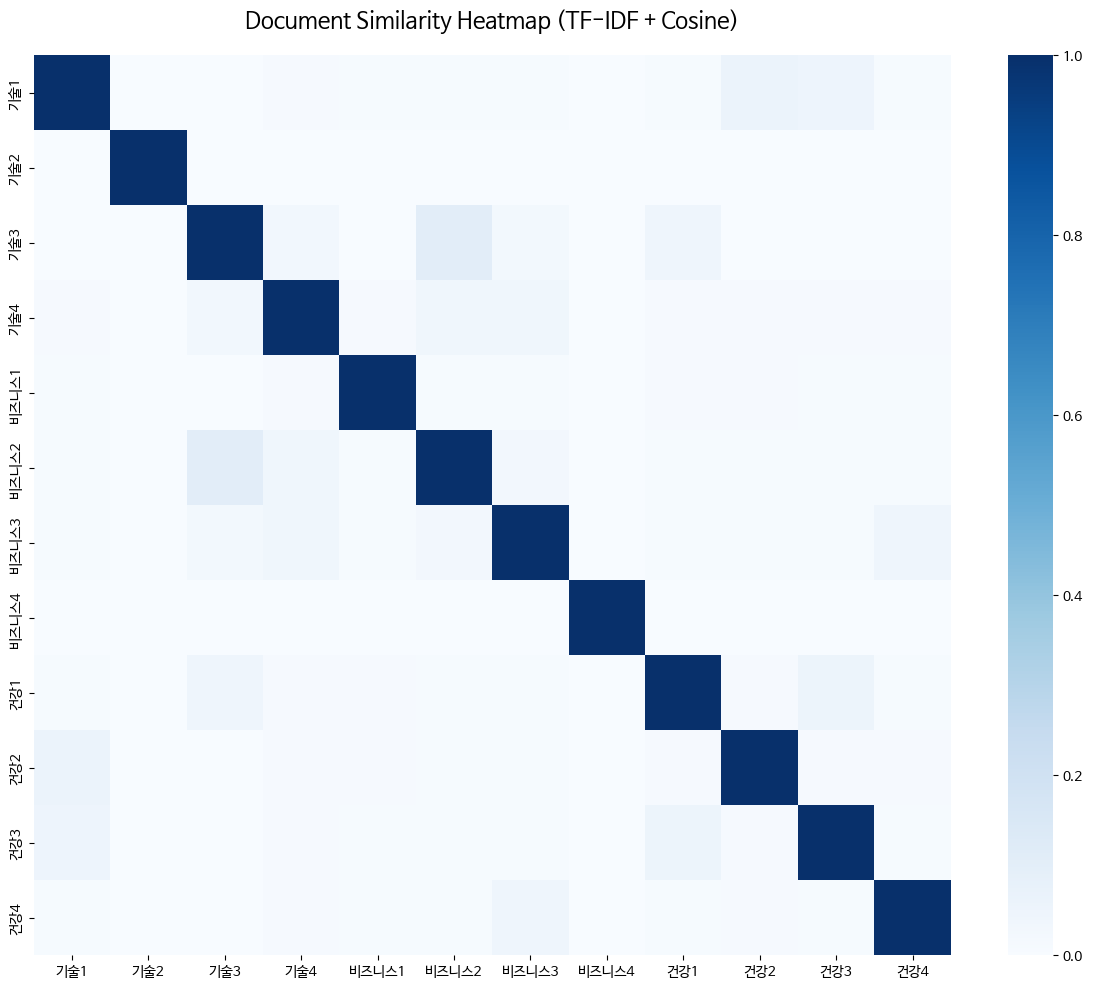


클러스터링 결과:
문서 1 (기술): 클러스터 A
문서 2 (기술): 클러스터 B
문서 3 (기술): 클러스터 C
문서 4 (기술): 클러스터 B
문서 5 (비즈니스): 클러스터 B
문서 6 (비즈니스): 클러스터 C
문서 7 (비즈니스): 클러스터 B
문서 8 (비즈니스): 클러스터 B
문서 9 (건강): 클러스터 B
문서 10 (건강): 클러스터 A
문서 11 (건강): 클러스터 A
문서 12 (건강): 클러스터 B

카테고리별 대표 단어 (TF-IDF 기준):

기술 카테고리:
  기업들은: 0.0929
  절감하면서도 확장성을: 0.0732
  인프라 비용을: 0.0732
  절감하면서도: 0.0732
  비용을 절감하면서도: 0.0732
  it: 0.0732
  비용을: 0.0732
  인프라: 0.0732

비즈니스 카테고리:
  있습니다: 0.0750
  기업들은: 0.0738
  지속가능한 경영과: 0.0645
  추세입니다: 0.0645
  요소를: 0.0645
  요소를 고려하여: 0.0645
  고려하여 투자: 0.0645
  지속가능한: 0.0645

건강 카테고리:
  있습니다: 0.1093
  치료: 0.1053
  진단: 0.0670
  정확도가: 0.0670
  진단 정확도가: 0.0670
  정확도가 높아지고: 0.0670
  분야에: 0.0670
  분야에 ai: 0.0670


In [15]:
# ----------------------------
# 4. TF-IDF로 문서 분류 및 클러스터링
# ----------------------------
def demonstrate_tfidf_applications():
    """TF-IDF 실전 응용 예제"""
    print("\n" + "=" * 60)
    print("✅ 4. TF-IDF 실전 응용 - 문서 분류 및 클러스터링")
    print("=" * 60)

    # 카테고리별 문서 데이터
    tech_docs = [
        "인공지능과 머신러닝 기술이 급속히 발전하고 있어 다양한 산업에 혁신을 가져오고 있습니다",
        "딥러닝은 신경망을 기반으로 한 기계학습 방법으로 이미지 인식과 자연언어처리에 뛰어난 성능을 보입니다",
        "빅데이터 분석 기술을 통해 기업들은 고객의 행동 패턴을 파악하고 맞춤형 서비스를 제공합니다",
        "클라우드 컴퓨팅 기술로 기업들은 IT 인프라 비용을 절감하면서도 확장성을 확보할 수 있습니다"
    ]

    business_docs = [
        "스타트업 기업들이 혁신적인 비즈니스 모델로 시장에 진입하여 큰 성과를 거두고 있습니다",
        "디지털 마케팅 전략을 통해 기업들은 고객과의 접점을 늘리고 브랜드 인지도를 높이고 있습니다",
        "글로벌 경제 불확실성 속에서도 일부 기업들은 새로운 시장 기회를 찾아 성장하고 있습니다",
        "투자자들은 지속가능한 경영과 ESG 요소를 고려하여 투자 결정을 내리는 추세입니다"
    ]

    health_docs = [
        "개인 맞춤형 의료 서비스가 발전하면서 질병 예방과 치료 효과가 크게 향상되고 있습니다",
        "헬스케어 분야에 AI 기술이 도입되어 진단 정확도가 높아지고 있습니다",
        "정신건강에 대한 관심이 높아지면서 다양한 치료 방법과 예방 프로그램이 개발되고 있습니다",
        "고령화 사회에 대응하여 실버케어 산업이 새로운 성장 동력으로 주목받고 있습니다"
    ]

    # 전체 문서와 라벨
    all_docs = tech_docs + business_docs + health_docs
    labels = ['기술'] * len(tech_docs) + ['비즈니스'] * len(business_docs) + ['건강'] * len(health_docs)

    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer(max_features=200, ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform(all_docs)

    print(f"전체 문서 수: {len(all_docs)}")
    print(f"TF-IDF 행렬 형태: {tfidf_matrix.shape}")

    # 1. 문서 유사도 분석
    similarity_matrix = cosine_similarity(tfidf_matrix)

    plt.figure(figsize=(12, 10))
    sns.heatmap(similarity_matrix,
                annot=False,
                cmap='Blues',
                xticklabels=[f'{labels[i]}{i%4+1}' for i in range(len(all_docs))],
                yticklabels=[f'{labels[i]}{i%4+1}' for i in range(len(all_docs))])
    plt.title('Document Similarity Heatmap (TF-IDF + Cosine)', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    # 2. 클러스터링
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(tfidf_matrix.toarray())

    print(f"\n클러스터링 결과:")
    cluster_labels = ['클러스터 A', '클러스터 B', '클러스터 C']
    for i, (doc, true_label, pred_cluster) in enumerate(zip(all_docs, labels, clusters)):
        print(f"문서 {i+1} ({true_label}): {cluster_labels[pred_cluster]}")

    # 3. 카테고리별 대표 단어 추출
    feature_names = vectorizer.get_feature_names_out()

    print(f"\n카테고리별 대표 단어 (TF-IDF 기준):")
    categories = ['기술', '비즈니스', '건강']
    category_vectors = {}

    for category in categories:
        # 해당 카테고리 문서들의 평균 벡터
        category_indices = [i for i, label in enumerate(labels) if label == category]
        category_matrix = tfidf_matrix[category_indices]
        avg_vector = np.mean(category_matrix.toarray(), axis=0)
        category_vectors[category] = avg_vector

        # 상위 단어들
        top_indices = np.argsort(avg_vector)[-8:][::-1]
        top_words = [(feature_names[idx], avg_vector[idx]) for idx in top_indices if avg_vector[idx] > 0]

        print(f"\n{category} 카테고리:")
        for word, score in top_words:
            print(f"  {word}: {score:.4f}")

    return vectorizer, tfidf_matrix, category_vectors

vectorizer, tfidf_matrix, category_vectors = demonstrate_tfidf_applications()

#### **5. TF-IDF 기반 검색 엔진 예제**

In [16]:
# ----------------------------
# 5. TF-IDF 기반 검색 엔진
# ----------------------------
def demonstrate_tfidf_search_engine():
    """TF-IDF 기반 검색 엔진 예제"""
    print("\n" + "=" * 60)
    print("✅ 5. TF-IDF 기반 검색 엔진")
    print("=" * 60)

    # 뉴스 기사 예제 데이터
    news_articles = [
        {
            'title': 'AI 기술 발전 현황',
            'content': '인공지능 기술이 빠르게 발전하면서 다양한 산업 분야에 혁신을 가져오고 있습니다. 특히 자연언어처리와 컴퓨터 비전 분야에서 괄목할 만한 성과를 보이고 있습니다.',
            'category': '기술'
        },
        {
            'title': '스타트업 투자 동향',
            'content': '올해 스타트업에 대한 투자가 전년 대비 크게 증가했습니다. 특히 핀테크와 헬스케어 분야에 대한 투자자들의 관심이 높습니다.',
            'category': '비즈니스'
        },
        {
            'title': '건강한 식단 관리법',
            'content': '균형잡힌 영양소 섭취와 규칙적인 운동이 건강 관리의 핵심입니다. 특히 현대인들에게 부족한 비타민과 미네랄 섭취에 주의해야 합니다.',
            'category': '건강'
        },
        {
            'title': '머신러닝 알고리즘 소개',
            'content': '머신러닝은 데이터로부터 패턴을 학습하는 알고리즘입니다. 지도학습, 비지도학습, 강화학습 등 다양한 방법론이 있습니다.',
            'category': '기술'
        },
        {
            'title': '디지털 마케팅 전략',
            'content': '소셜미디어와 검색엔진 마케팅을 통해 고객들과의 접점을 늘리는 것이 중요합니다. 데이터 분석을 통한 타겟 마케팅이 효과적입니다.',
            'category': '비즈니스'
        }
    ]

    # 문서 내용 추출
    documents = [article['content'] for article in news_articles]
    titles = [article['title'] for article in news_articles]

    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100)
    doc_vectors = vectorizer.fit_transform(documents)

    def search_documents(query, top_k=3):
        """검색 쿼리에 대한 관련 문서 반환"""
        # 쿼리 벡터화
        query_vector = vectorizer.transform([query])

        # 유사도 계산
        similarities = cosine_similarity(query_vector, doc_vectors)[0]

        # 상위 k개 문서
        top_indices = np.argsort(similarities)[::-1][:top_k]

        results = []
        for idx in top_indices:
            if similarities[idx] > 0:
                results.append({
                    'title': titles[idx],
                    'content': documents[idx],
                    'category': news_articles[idx]['category'],
                    'similarity': similarities[idx]
                })

        return results


    # 검색 예제
    queries = [
        "인공지능과 머신러닝",
        "투자와 스타트업",
        "건강과 영양",
        "데이터 분석"
    ]

    print("검색 결과:")
    for query in queries:
        print(f"\n🔍 검색어: '{query}'")
        results = search_documents(query, top_k=2)

        if not results:
            print(" ❌ 검색 결과가 없습니다.")
            continue


        for i, result in enumerate(results):
            print(f"  {i+1}. {result['title']} (유사도: {result['similarity']:.4f})")
            print(f"     카테고리: {result['category']}")
            print(f"     내용: {result['content'][:50]}...")

demonstrate_tfidf_search_engine()



✅ 5. TF-IDF 기반 검색 엔진
검색 결과:

🔍 검색어: '인공지능과 머신러닝'
 ❌ 검색 결과가 없습니다.

🔍 검색어: '투자와 스타트업'
 ❌ 검색 결과가 없습니다.

🔍 검색어: '건강과 영양'
 ❌ 검색 결과가 없습니다.

🔍 검색어: '데이터 분석'
  1. 디지털 마케팅 전략 (유사도: 0.2357)
     카테고리: 비즈니스
     내용: 소셜미디어와 검색엔진 마케팅을 통해 고객들과의 접점을 늘리는 것이 중요합니다. 데이터 분석...


#### **6. TF-IDF 특성 분석**


✅ 6. TF-IDF 특성 분석
어휘 크기: 15
문서 수: 4
문서별 TF-IDF 분석:

문서 1: 컴퓨터 컴퓨터 컴퓨터 과학 기술
커스텀 구현 상위 단어: [('컴퓨터', np.float64(0.8292789960182417)), ('과학', np.float64(0.39515588491314224)), ('기술', np.float64(0.39515588491314224))]
sklearn 상위 단어: [('컴퓨터', np.float64(0.9045340337332908)), ('과학', np.float64(0.3015113445777636)), ('기술', np.float64(0.3015113445777636))]

문서 2: 양자 암호학 블록체인
커스텀 구현 상위 단어: [('블록체인', np.float64(0.5773502691896257)), ('암호학', np.float64(0.5773502691896257)), ('양자', np.float64(0.5773502691896257))]
sklearn 상위 단어: [('블록체인', np.float64(0.5773502691896257)), ('암호학', np.float64(0.5773502691896257)), ('양자', np.float64(0.5773502691896257))]

문서 3: 그리고 그러나 또한 하지만 그래서
커스텀 구현 상위 단어: [('그래서', np.float64(0.447213595499958)), ('그러나', np.float64(0.447213595499958)), ('그리고', np.float64(0.447213595499958))]
sklearn 상위 단어: [('하지만', np.float64(0.4472135954999579)), ('그래서', np.float64(0.4472135954999579)), ('또한', np.float64(0.4472135954999579))]

문서 4: 인공지능 머신러닝 딥러닝 자연언어처리
커스텀 구현 상위 단어: [('딥러닝', np

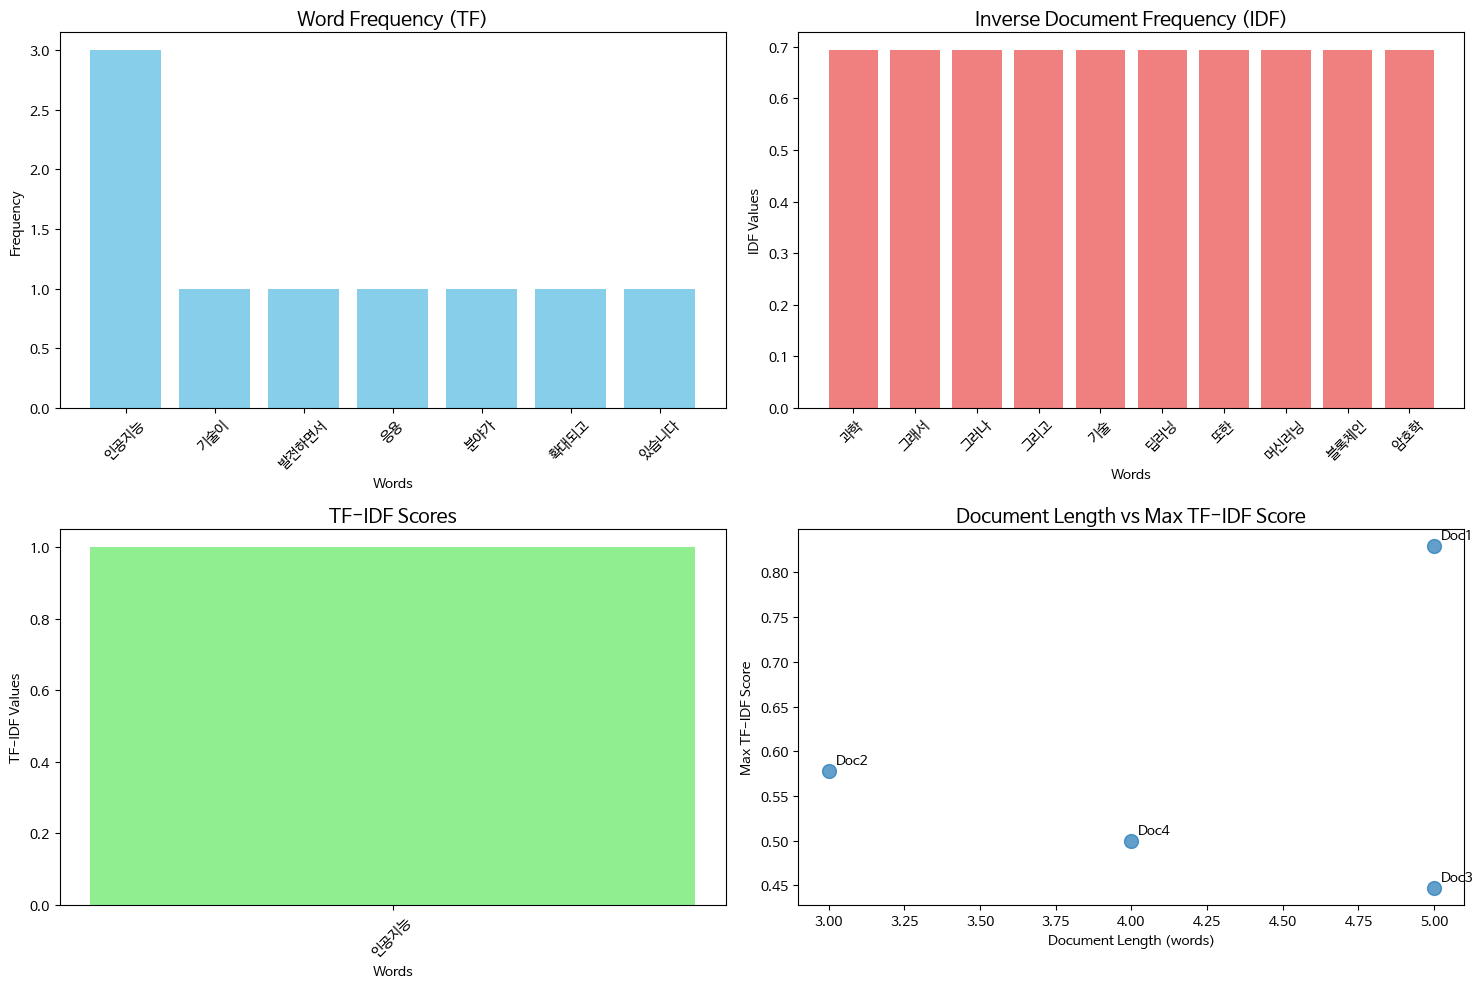

In [17]:
# ----------------------------
# 5. TF-IDF 특성 분석
# ----------------------------
def analyze_tfidf_properties():
    """TF-IDF 속성 분석"""
    print("\n" + "=" * 60)
    print("✅ 6. TF-IDF 특성 분석")
    print("=" * 60)

    # 분석용 문서들
    documents = [
        "컴퓨터 컴퓨터 컴퓨터 과학 기술",  # 높은 TF
        "양자 암호학 블록체인",  # 희귀 단어들
        "그리고 그러나 또한 하지만 그래서",  # 일반적인 단어들
        "인공지능 머신러닝 딥러닝 자연언어처리"  # 기술 용어들
    ]

    # 커스텀 TF-IDF와 sklearn 비교
    custom_tfidf = TFIDFImplementation()
    custom_matrix = custom_tfidf.fit_transform(documents)

    sklearn_tfidf = TfidfVectorizer()
    sklearn_matrix = sklearn_tfidf.fit_transform(documents)

    print("문서별 TF-IDF 분석:")

    for i, doc in enumerate(documents):
        print(f"\n문서 {i+1}: {doc}")

        # 커스텀 구현 결과
        top_words_custom = custom_tfidf.get_top_words(doc, top_n=3)
        print(f"커스텀 구현 상위 단어: {top_words_custom}")

        # sklearn 결과
        sklearn_vector = sklearn_matrix[i].toarray()[0]
        feature_names = sklearn_tfidf.get_feature_names_out()
        sklearn_scores = [(feature_names[idx], sklearn_vector[idx])
                         for idx in np.argsort(sklearn_vector)[-3:][::-1]
                         if sklearn_vector[idx] > 0]
        print(f"sklearn 상위 단어: {sklearn_scores}")

    # TF vs IDF 분석 시각화
    plt.figure(figsize=(15, 10))

    # TF 분포
    plt.subplot(2, 2, 1)
    sample_doc = "인공지능 기술이 발전하면서 인공지능 응용 분야가 확대되고 있습니다 인공지능"
    words = custom_tfidf.preprocess_text(sample_doc)
    word_freq = Counter(words)

    plt.bar(word_freq.keys(), word_freq.values(), color='skyblue')
    plt.title('Word Frequency (TF)', fontsize=14)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

    # IDF 분포
    plt.subplot(2, 2, 2)
    idf_words = list(custom_tfidf.idf_values.keys())[:10]
    idf_vals = [custom_tfidf.idf_values[word] for word in idf_words]

    plt.bar(idf_words, idf_vals, color='lightcoral')
    plt.title('Inverse Document Frequency (IDF)', fontsize=14)
    plt.xlabel('Words')
    plt.ylabel('IDF Values')
    plt.xticks(rotation=45)

    # TF-IDF 최종 점수
    plt.subplot(2, 2, 3)
    tfidf_vector = custom_tfidf.document_to_vector(sample_doc)
    top_indices = np.argsort(tfidf_vector)[-5:][::-1]
    top_words = [list(custom_tfidf.vocab.keys())[i] for i in top_indices if tfidf_vector[i] > 0]
    top_scores = [tfidf_vector[i] for i in top_indices if tfidf_vector[i] > 0]

    plt.bar(top_words, top_scores, color='lightgreen')
    plt.title('TF-IDF Scores', fontsize=14)
    plt.xlabel('Words')
    plt.ylabel('TF-IDF Values')
    plt.xticks(rotation=45)

    # 문서 길이별 TF-IDF 영향 분석
    plt.subplot(2, 2, 4)
    doc_lengths = [len(doc.split()) for doc in documents]
    max_tfidf_scores = [np.max(custom_matrix[i]) for i in range(len(documents))]

    plt.scatter(doc_lengths, max_tfidf_scores, s=100, alpha=0.7)
    plt.title('Document Length vs Max TF-IDF Score', fontsize=14)
    plt.xlabel('Document Length (words)')
    plt.ylabel('Max TF-IDF Score')

    for i, (x, y) in enumerate(zip(doc_lengths, max_tfidf_scores)):
        plt.annotate(f'Doc{i+1}', (x, y), xytext=(5, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()


analyze_tfidf_properties()


### **예제: TF-IDF와 코사인 유사도를 이용한 영화 추천 시스템**

In [18]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 29.4 MB/s eta 0:00:00


In [19]:
import pandas as pd
import numpy as np
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from konlpy.tag import Okt
import re
import warnings
warnings.filterwarnings('ignore')

class KoreanMovieRecommendationSystem:
    def __init__(self):
        self.movies_df = None
        self.tfidf_matrix = None
        self.cosine_sim = None
        self.okt = Okt()

    def download_movie_data(self):

        # 예시 한글 영화 데이터 생성
        sample_movies = [
            {
                'title': '기생충',
                'plot': '반지하에 살던 기택 가족이 부유한 박 사장 가족의 집에 취업하면서 벌어지는 계급 갈등과 사회적 모순을 그린 작품. 가난한 가족과 부유한 가족 사이의 첨예한 대립과 예상치 못한 사건들이 연쇄적으로 일어난다.',
                'genre': '드라마, 스릴러',
                'year': 2019
            },
            {
                'title': '올드보이',
                'plot': '15년간 감금당한 오대수가 복수를 위해 자신을 가둔 자를 찾아나서는 복수극. 미스터리한 감금의 이유와 충격적인 진실이 밝혀지는 강렬한 스릴러 작품이다.',
                'genre': '스릴러, 미스터리',
                'year': 2003
            },
            {
                'title': '아가씨',
                'plot': '일제강점기 조선을 배경으로 한 귀족 아가씨와 하녀, 그리고 사기꾼이 얽힌 복잡한 사기극과 사랑 이야기. 반전에 반전을 거듭하는 정교한 플롯과 아름다운 영상미가 돋보인다.',
                'genre': '드라마, 스릴러',
                'year': 2016
            },
            {
                'title': '곡성',
                'plot': '평화로운 시골 마을에 일본인 남자가 나타난 후 기이한 질병과 살인사건이 연이어 발생한다. 경찰관 종구가 딸을 구하기 위해 미스터리의 진상을 파헤치는 공포 스릴러.',
                'genre': '공포, 미스터리',
                'year': 2016
            },
            {
                'title': '타짜',
                'plot': '화투계의 전설적인 도박사들과 신출내기 곰이 만나 벌이는 속임수와 배신의 이야기. 치밀한 심리전과 화투 게임의 세계를 생생하게 그린 작품.',
                'genre': '범죄, 드라마',
                'year': 2006
            },
            {
                'title': '살인의 추억',
                'plot': '1980년대 경기도 화성에서 연쇄살인사건이 일어나고, 무능한 경찰들이 범인을 찾기 위해 고군분투하는 과정을 그린 블랙 코미디 스릴러.',
                'genre': '스릴러, 범죄',
                'year': 2003
            },
            {
                'title': '부산행',
                'plot': '좀비 바이러스가 전국으로 확산되는 상황에서 KTX를 타고 부산으로 향하는 사람들의 생존기. 가족애와 인간성을 그린 좀비 액션 영화.',
                'genre': '액션, 공포',
                'year': 2016
            },
            {
                'title': '신과함께-죄와벌',
                'plot': '사후세계를 배경으로 죽은 자가 7개의 지옥에서 재판을 받으며 환생을 위해 노력하는 이야기. 한국적 판타지와 가족애를 담은 작품.',
                'genre': '판타지, 드라마',
                'year': 2017
            }
        ]

        self.movies_df = pd.DataFrame(sample_movies)
        print("영화 데이터 로드 완료!")
        print(f"총 {len(self.movies_df)}편의 영화 데이터")
        return self.movies_df

    def preprocess_text(self, text):
        """
        한글 텍스트 전처리
        """
        # 특수문자 제거
        text = re.sub(r'[^\w\s]', ' ', text)

        # 형태소 분석 및 명사, 동사, 형용사만 추출
        tokens = self.okt.pos(text)
        meaningful_words = []

        for word, pos in tokens:
            if pos in ['Noun', 'Verb', 'Adjective'] and len(word) > 1:
                meaningful_words.append(word)

        return ' '.join(meaningful_words)

    def create_tfidf_matrix(self):
        """
        TF-IDF 행렬 생성
        """
        # 줄거리 텍스트 전처리
        processed_plots = [self.preprocess_text(plot) for plot in self.movies_df['plot']]

        # TF-IDF 벡터화
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=1000,  # 최대 특성 수
            stop_words=None,    # 한글은 별도의 불용어 처리
            ngram_range=(1, 2)  # 1-gram, 2-gram 사용
        )

        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(processed_plots)
        print(f"TF-IDF 행렬 크기: {self.tfidf_matrix.shape}")

    def calculate_similarity(self):
        """
        코사인 유사도 계산
        """
        self.cosine_sim = cosine_similarity(self.tfidf_matrix, self.tfidf_matrix)
        print("코사인 유사도 계산 완료!")

    def get_recommendations(self, movie_title, num_recommendations=3):
        """
        영화 추천 함수
        """
        # 영화 제목으로 인덱스 찾기
        try:
            movie_idx = self.movies_df[self.movies_df['title'] == movie_title].index[0]
        except IndexError:
            print(f"'{movie_title}' 영화를 찾을 수 없습니다.")
            return None

        # 해당 영화와 다른 영화들 간의 유사도 점수 계산
        sim_scores = list(enumerate(self.cosine_sim[movie_idx]))

        # 유사도 점수로 정렬 (자기 자신 제외)
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:]

        # 상위 N개 영화의 인덱스 추출
        top_movies_indices = [i[0] for i in sim_scores[:num_recommendations]]

        # 추천 영화 정보 반환
        recommendations = self.movies_df.iloc[top_movies_indices][['title', 'plot', 'genre', 'year']].copy()
        recommendations['similarity_score'] = [sim_scores[i][1] for i in range(num_recommendations)]

        return recommendations

    def run_recommendation_system(self):
        """
        추천 시스템 실행
        """
        print("=== 한글 영화 추천 시스템 ===\n")

        # 1. 데이터 로드
        self.download_movie_data()

        # 2. TF-IDF 행렬 생성
        print("\n텍스트 전처리 및 TF-IDF 행렬 생성 중...")
        self.create_tfidf_matrix()

        # 3. 코사인 유사도 계산
        print("\n코사인 유사도 계산 중...")
        self.calculate_similarity()

        print("\n=== 추천 시스템 준비 완료 ===")
        return True

# 시스템 실행 및 테스트
def main():
    # 추천 시스템 초기화 및 실행
    recommender = KoreanMovieRecommendationSystem()
    recommender.run_recommendation_system()

    print("\n" + "="*50)
    print("영화 추천 테스트")
    print("="*50)

    # 테스트용 영화들
    test_movies = ['기생충', '올드보이', '부산행']

    for movie in test_movies:
        print(f"\n✅ '{movie}'와 유사한 영화 추천:")
        print("-" * 30)

        recommendations = recommender.get_recommendations(movie, 3)

        if recommendations is not None:
            for idx, row in recommendations.iterrows():
                print(f"🎬 {row['title']} ({row['year']})")
                print(f"   장르: {row['genre']}")
                print(f"   유사도: {row['similarity_score']:.4f}")
                print(f"   줄거리: {row['plot'][:100]}...")
                print()

if __name__ == "__main__":
    main()

=== 한글 영화 추천 시스템 ===

영화 데이터 로드 완료!
총 8편의 영화 데이터

텍스트 전처리 및 TF-IDF 행렬 생성 중...
TF-IDF 행렬 크기: (8, 272)

코사인 유사도 계산 중...
코사인 유사도 계산 완료!

=== 추천 시스템 준비 완료 ===

영화 추천 테스트

✅ '기생충'와 유사한 영화 추천:
------------------------------
🎬 신과함께-죄와벌 (2017)
   장르: 판타지, 드라마
   유사도: 0.0590
   줄거리: 사후세계를 배경으로 죽은 자가 7개의 지옥에서 재판을 받으며 환생을 위해 노력하는 이야기. 한국적 판타지와 가족애를 담은 작품....

🎬 부산행 (2016)
   장르: 액션, 공포
   유사도: 0.0560
   줄거리: 좀비 바이러스가 전국으로 확산되는 상황에서 KTX를 타고 부산으로 향하는 사람들의 생존기. 가족애와 인간성을 그린 좀비 액션 영화....

🎬 타짜 (2006)
   장르: 범죄, 드라마
   유사도: 0.0340
   줄거리: 화투계의 전설적인 도박사들과 신출내기 곰이 만나 벌이는 속임수와 배신의 이야기. 치밀한 심리전과 화투 게임의 세계를 생생하게 그린 작품....


✅ '올드보이'와 유사한 영화 추천:
------------------------------
🎬 곡성 (2016)
   장르: 공포, 미스터리
   유사도: 0.0416
   줄거리: 평화로운 시골 마을에 일본인 남자가 나타난 후 기이한 질병과 살인사건이 연이어 발생한다. 경찰관 종구가 딸을 구하기 위해 미스터리의 진상을 파헤치는 공포 스릴러....

🎬 살인의 추억 (2003)
   장르: 스릴러, 범죄
   유사도: 0.0276
   줄거리: 1980년대 경기도 화성에서 연쇄살인사건이 일어나고, 무능한 경찰들이 범인을 찾기 위해 고군분투하는 과정을 그린 블랙 코미디 스릴러....

🎬 신과함께-죄와벌 (2017)
   장르: 판타지, 드라마
   유사도: 0.0235
   줄거리: 사



---



## **3. Word2Vec**

- **임베딩(Embedding)** :
    - 데이터의 의미를 포착하기 위한 **벡터 표현**
- **단어 임베딩(Word Embedding)**
    - 단어 하나를 고차원 벡터 공간의 점으로 표현, 의미적으로 유사한 단어들이 가깝게 위치함
- **Word2Vec** :
    - 2013년 Google의 Tomas Mikolov가 개발한 단어 임베딩(Word Embedding) 기법
    - 단어를 고차원 벡터 공간에서 밀집된 실수 벡터로 표현하는 방법
    - **Word2Vec 는 텍스트의 의미를 포착하는 데 성공한 첫 번째 시도**
    - **신경망을 사용**해 주어진 **문장에서 다음에 어떤 단어가 등장하는지** 살펴봄으로써 단어 임베딩을 생성함 --> **의미 표현을 생성함**
- **Word2Vec 방법**:
    - 어휘사전에 있는 모든 단어에 대해 랜덤하게 초기화된 일련의 값을 단어 임베딩으로 할당
    - 훈련 스텝마다 훈련 데이터에서 단어 쌍을 가져와 모델이 문장 안에서 단어 쌍이 이웃에 나타날 가능성이 있는지 예측
    - 훈련 과정 동안 Word2Vec 는 단어 사이 관계를 학습하고 이 정보를 임베딩에 저장
    - 두 단어가 이웃에 나타날 가능성이 높다면 두 단어의 임베딩은 서로 매우 가까워짐

### **예제 : word2vec로 문장 유사도 확인**

- **작업 순서**
  1) 말뭉치 구성 & 전처리
  2) Word2Vec (CBOW vs Skip-gram) 학습
  3) 유사어 탐색, 유사도 계산, 간단 유추(analogy)
  4) 문서 임베딩(평균)으로 유사도 히트맵
  5) t-SNE로 단어 벡터 2D 시각화
- **gensim** 라이브러리
    - 대규모 텍스트를 효율적으로 처리하고 Word2Vec, LDA 같은 토픽 모델링과 임베딩을 쉽게 구현할 수 있는 Python 라이브러리

#### **1. 말뭉치 구성 & 전처리**
- 토큰화(Tokenization): 문장을 단어 단위로 쪼개는 과정
- 소문자 변환: 대소문자를 통일하여 'AI'와 'ai'를 같은 단어로 인식하게함

In [1]:
!pip3 install gensim

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import nltk
import warnings
warnings.filterwarnings('ignore')

# NLTK 리소스 다운로드
nltk.download('punkt')
nltk.download('punkt_tab')

# 1. 말뭉치 구성
corpus = [
    "I like to eat pizza and pasta.",
    "I enjoy eating sushi and noodles.",
    "Cats and dogs are common pets.",
    "Tigers and lions are wild animals.",
    "AI is a revolutionary technology.",
    "Machine learning is a subfield of AI.",
    "Pizza is a popular dish.",
    "Dogs are loyal companions.",
    "Technology is advancing rapidly."
]

# 2. 전처리: 토큰화 및 소문자 변환
tokenized_corpus = [word_tokenize(sentence.lower()) for sentence in corpus]
print("--- 전처리된 말뭉치(일부) ---")
print(tokenized_corpus[0])
print(tokenized_corpus[2])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


--- 전처리된 말뭉치(일부) ---
['i', 'like', 'to', 'eat', 'pizza', 'and', 'pasta', '.']
['cats', 'and', 'dogs', 'are', 'common', 'pets', '.']


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


#### **2. Word2Vec (CBOW vs Skip-gram) 학습**
- Word2Vec 모델을 학습시킴
- **CBOW** (Continuous Bag of Words): 주변 단어들을 이용해 중간에 있는 단어를 예측하는 방식
- **Skip-gram**: 어떤 단어를 이용해 주변 단어들을 예측하는 방식, 보통 Skip-gram이 더 작은 데이터셋에서 좋은 성능을 보임

In [3]:
# 3. Word2Vec 모델 학습
# CBOW 모델
cbow_model = Word2Vec(
    sentences=tokenized_corpus, # 학습할 말뭉치 (토큰화된 문장 리스트)
    vector_size=100, # 단어 벡터의 차원
    window=5,        # 학습 시 고려할 주변 단어의 범위
    min_count=1,     # 최소 등장 빈도 (이 미만 단어는 무시)
    sg=0,            # 학습 알고리즘 선택 (0=CBOW, 1=Skip-gram)
    seed=42
)

# Skip-gram 모델
skipgram_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,          # 1: Skip-gram
    seed=42
)

print("\n--- CBOW 모델 학습 완료 ---")
print("벡터 크기:", cbow_model.vector_size)
print("단어 수:", len(cbow_model.wv))

print("\n--- Skip-gram 모델 학습 완료 ---")
print("벡터 크기:", skipgram_model.vector_size)
print("단어 수:", len(skipgram_model.wv))


--- CBOW 모델 학습 완료 ---
벡터 크기: 100
단어 수: 36

--- Skip-gram 모델 학습 완료 ---
벡터 크기: 100
단어 수: 36


#### **tokenized_corpus에 매핑된 skipgram_model.wv 출력**


In [4]:
for i, sentence in enumerate(tokenized_corpus):
    print(f"\n--- 문장 {i+1} ---")
    for word in sentence:
        if word in skipgram_model.wv:
            print(f"{word:10s} -> {skipgram_model.wv[word][:5]}")  # 앞 5개 값만 표시



--- 문장 1 ---
i          -> [-0.00773279  0.0030434   0.00925819  0.00735235 -0.00452456]
like       -> [-0.00877706  0.00280878 -0.00379099 -0.0059693  -0.00965393]
to         -> [ 0.0062912   0.0083673  -0.00686663  0.00968691 -0.00215768]
eat        -> [ 0.00273508 -0.00466983  0.00202269 -0.00451161 -0.00763188]
pizza      -> [-0.00975242 -0.00395476  0.00030845  0.0083728   0.00475878]
and        -> [-2.6646191e-03  8.2335640e-03 -9.2458053e-05  4.0491014e-03
 -8.8061992e-04]
pasta      -> [ 0.00842312  0.00827281  0.00538489 -0.00718566 -0.00401023]
.          -> [-0.00812463  0.00562637  0.00311379 -0.00114779 -0.00140644]

--- 문장 2 ---
i          -> [-0.00773279  0.0030434   0.00925819  0.00735235 -0.00452456]
enjoy      -> [ 0.00584651 -0.0010983   0.00978663 -0.00874095 -0.0065587 ]
eating     -> [0.0001517  0.00601212 0.00725789 0.00235942 0.00303542]
sushi      -> [0.0055608  0.00345201 0.00860402 0.00921928 0.00408608]
and        -> [-2.6646191e-03  8.2335640e-03 -9.245805

#### **3. 유사어 탐색, 유사도 계산, 간단 유추(analogy)**
- 학습된 모델을 활용하여 단어 간의 유사도를 계산하고, 흥미로운 단어 유추(Analogy) 실험
- most_similar(): 주어진 단어와 코사인 유사도가 가장 높은 단어들을 찾는다.
- similarity(): 두 단어의 벡터 간의 코사인 유사도를 계산하여 의미적 유사도를 측정함
- 유추: 벡터 연산(vector('king') - vector('man') + vector('woman'))을 통해 단어 간의 관계를 추론한다.

In [5]:
# 4. 유사어 탐색 (가장 비슷한 단어 찾기)
print("\n✅ 'pizza'와 가장 비슷한 단어 (Skip-gram) ---")
similar_words = skipgram_model.wv.most_similar("pizza", topn=5)
for word, similarity in similar_words:
    print(f"  {word}: {similarity:.4f}")


# 5. 유사도 계산 (두 단어 간의 코사인 유사도)
print("\n✅ 'dogs'와 'cats'의 유사도 ---")
similarity_score = skipgram_model.wv.similarity('dogs', 'cats')
print(f"  유사도 점수: {similarity_score:.4f}")


print("\n✅ 'pizza'와 'dogs'의 유사도 ---")
similarity_score = skipgram_model.wv.similarity('pizza', 'dogs')
print(f"  유사도 점수: {similarity_score:.4f}")


# 6. 간단한 유추(analogy): "King - Man + Woman = ?"

# 안전 유사/유추 헬퍼
print("\n✅ King - Man + Woman 유추 ---")
def check_tokens(kv, tokens):
    missing = [t for t in tokens if t not in kv.key_to_index]
    return missing

def safe_most_similar(kv, positive, negative=None, topn=1):
    negative = negative or []
    missing = check_tokens(kv, positive + negative)
    if missing:
        raise KeyError(f"사전에 없는 단어: {missing}")
    return kv.most_similar(positive=positive, negative=negative, topn=topn)

# 먼저 현재 skip-gram 모델로 시도
try:
    analogy_result = safe_most_similar(
        skipgram_model.wv, positive=['woman','king'], negative=['man'], topn=1
    )
    print(" (내 말뭉치) 유추:", analogy_result[0])
except KeyError as e:
    print("⚠️ 현재 Word2Vec 어휘에 단어가 없습니다 -> GloVe로 폴백합니다.", e)

    # GloVe 100d 로 폴백
    import gensim.downloader as api
    glove = api.load("glove-wiki-gigaword-100")  # 약 128MB
    analogy_result = glove.most_similar(positive=['woman','king'], negative=['man'], topn=1)
    print("\n✅ (GloVe) 유추:", analogy_result[0])



✅ 'pizza'와 가장 비슷한 단어 (Skip-gram) ---
  dish: 0.2207
  .: 0.1939
  and: 0.1681
  is: 0.1519
  advancing: 0.1391

✅ 'dogs'와 'cats'의 유사도 ---
  유사도 점수: -0.0178

✅ 'pizza'와 'dogs'의 유사도 ---
  유사도 점수: -0.0179

✅ King - Man + Woman 유추 ---
⚠️ 현재 Word2Vec 어휘에 단어가 없습니다 -> GloVe로 폴백합니다. "사전에 없는 단어: ['woman', 'king', 'man']"
[==================================================] 100.0% 128.1/128.1MB downloaded

✅ (GloVe) 유추: ('queen', 0.7698540687561035)


#### **4. 문서 임베딩(평균) 이후 유사도를 히트맵으로 시각화**
    
- 단어 임베딩을 이용해 문장(문서)의 임베딩을 만들고, 문장 간의 유사도를 히트맵으로 시각화함. --> 여기서는 각 문장의 단어 벡터들의 평균을 사용함
- 음식에 대한 문장, 동물에 대한 문장들이 높은 유사도를 보


--- 문장 벡터 크기 ---
(9, 100)


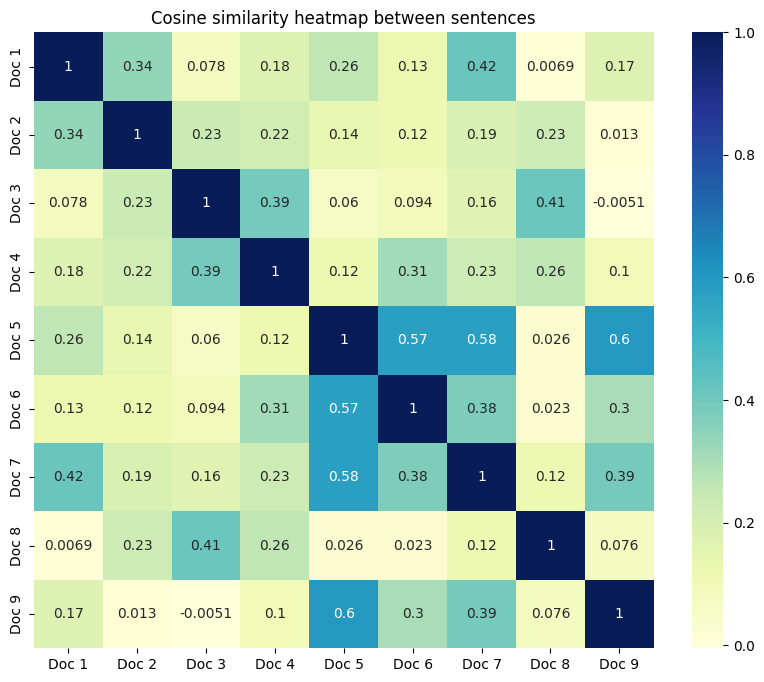

In [6]:
# 7. 문서 임베딩(평균) 계산
def get_sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

sentence_vectors = np.array([get_sentence_vector(s, skipgram_model) for s in tokenized_corpus])
print("\n--- 문장 벡터 크기 ---")
print(sentence_vectors.shape)


# 8. 코사인 유사도 계산
similarity_matrix = cosine_similarity(sentence_vectors)


# 9. 유사도 히트맵 시각화(문장 간 코사인 유사도 히트맵)
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap="YlGnBu",
            xticklabels=[f"Doc {i+1}" for i in range(len(corpus))],
            yticklabels=[f"Doc {i+1}" for i in range(len(corpus))])
plt.title("Cosine similarity heatmap between sentences")
plt.show()

#### **5. t-SNE로 단어 벡터 2D 시각화**
    
- **t-SNE**(t-Distributed Stochastic Neighbor Embedding) 는 2008년 Geoffrey Hinton 연구팀이 제안.
- **t-SNE**는 고차원 데이터를 저차원(보통 2D나 3D)으로 시각화하기 위해 자주 사용하는 비선형 차원 축소  --> **확률적 분포간 유사도**
- 고차원의 단어 벡터를 2차원으로 축소하여 시각화함으로써, **의미적으로 유사한 단어들이 서로 가깝게 위치**하는 것을 직관적으로 볼 수 있음
- 'pizza'와 'pasta', 'cats'와 'dogs' 같은 유사한 단어들이 서로 가까운 곳에 위치하는가???

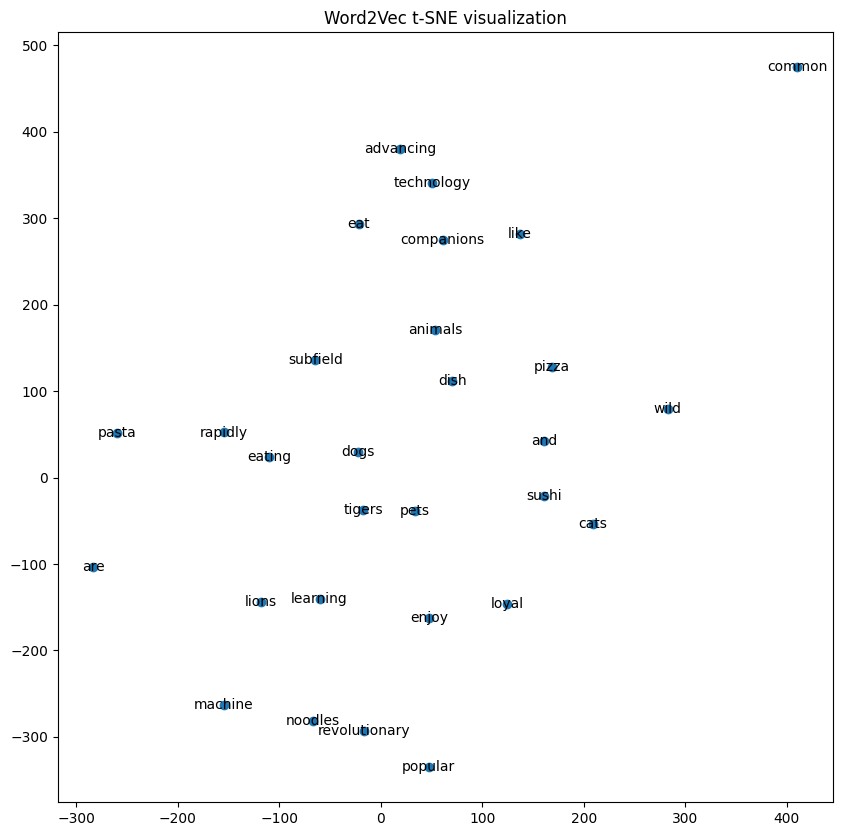

In [7]:
# 10. t-SNE를 이용한 단어 벡터 2D 시각화

# 단어와 벡터 준비
words = [word for word in skipgram_model.wv.key_to_index if len(word) > 2]
vectors = np.array([skipgram_model.wv[word] for word in words])  # 리스트 → 넘파이 배열

# t-SNE 변환
# tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(words)-1))

vectors_2d = tsne.fit_transform(vectors)

# 시각화
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), ha='center', va='center')

plt.title("Word2Vec t-SNE visualization")
plt.show()




---



### **예제: gensim 라이브러리를 이용한 Word2Vec로 문장 유사도 확인**

- **gensim** (generate + similarity)
    - 대규모 텍스트 말뭉치(Corpus)를 효율적으로 처리하고, 토픽 모델링·문서 유사도 분석·단어 임베딩 등을 손쉽게 수행
- 대표기능
    - Word2Vec, FastText: 단어 벡터 학습 및 유사어 찾기
    - Doc2Vec: 문서 임베딩
    - Topic Modeling: LDA, LSI
    - 유사도 검색: 문서 간 유사도 계산, 검색 엔진 구현

In [2]:
!pip install gensim==4.3.2 scipy==1.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 70.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 52.5 MB/s eta 0:00:00
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-linux_x86_64.whl size=26332398 sha256=4aeaade959ab9758ec0d92dd41644db6031c5c5534f156c24990c168bb590581
  Stored in directory: /root/.cache/pip/wheels/50/c0/ac/7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninsta

In [1]:
from gensim.models import Word2Vec

# 샘플 말뭉치
sentences = [
    ["인공지능", "머신러닝", "딥러닝"],
    ["자연어처리", "컴퓨터", "언어"],
    ["투자", "스타트업", "비즈니스"]
]

# 모델 학습 (Skip-gram)
model = Word2Vec(
    sentences,      # 학습할 말뭉치 (토큰화된 문장 리스트)
    vector_size=50, # 단어 벡터의 차원
    window=3,       # 학습 시 고려할 주변 단어의 범위
    sg=1,           # 학습 알고리즘 선택 (0=CBOW, 1=Skip-gram)
    min_count=1     # 최소 등장 빈도 (이 미만 단어는 무시)
)


# 유사어 탐색
model.wv.most_similar("인공지능")


[('머신러닝', 0.1845843642950058),
 ('투자', 0.13940522074699402),
 ('컴퓨터', 0.10704141855239868),
 ('언어', -0.010146035812795162),
 ('비즈니스', -0.0560765378177166),
 ('딥러닝', -0.08931691199541092),
 ('자연어처리', -0.10186848789453506),
 ('스타트업', -0.11910455673933029)]

#### **1. 말중치 구성 & 정처리**

In [2]:
import re
import math
from collections import Counter
from typing import List, Iterable
from gensim.models import Word2Vec

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# ---------------------------------------------------------------------
# 1) 말뭉치 구성: TF-IDF 예제의 문장들을 그대로 사용 (한국어 유지)
# ---------------------------------------------------------------------

documents_basic = [
    "인공지능은 컴퓨터 과학의 한 분야로 기계가 인간의 지능을 모방하도록 하는 기술입니다",
    "머신러닝은 인공지능의 하위 분야로 데이터로부터 학습하는 알고리즘을 다룹니다",
    "딥러닝은 머신러닝의 한 방법으로 신경망을 이용하여 복잡한 패턴을 학습합니다",
    "자연언어처리는 컴퓨터가 인간의 언어를 이해하고 생성하는 기술입니다",
    "컴퓨터 비전은 컴퓨터가 이미지와 비디오를 분석하고 이해하는 기술입니다"
]

documents_compare = [
    "자연언어처리 기술이 빠르게 발전하고 있습니다",
    "머신러닝과 딥러닝이 AI 발전을 이끌고 있습니다",
    "빅데이터 분석에 다양한 기술이 활용됩니다",
    "클라우드 컴퓨팅이 IT 인프라를 혁신하고 있습니다",
    "사물인터넷과 스마트시티가 주목받고 있습니다"
]

tech_docs = [
    "인공지능과 머신러닝 기술이 급속히 발전하고 있어 다양한 산업에 혁신을 가져오고 있습니다",
    "딥러닝은 신경망을 기반으로 한 기계학습 방법으로 이미지 인식과 자연언어처리에 뛰어난 성능을 보입니다",
    "빅데이터 분석 기술을 통해 기업들은 고객의 행동 패턴을 파악하고 맞춤형 서비스를 제공합니다",
    "클라우드 컴퓨팅 기술로 기업들은 IT 인프라 비용을 절감하면서도 확장성을 확보할 수 있습니다"
]

business_docs = [
    "스타트업 기업들이 혁신적인 비즈니스 모델로 시장에 진입하여 큰 성과를 거두고 있습니다",
    "디지털 마케팅 전략을 통해 기업들은 고객과의 접점을 늘리고 브랜드 인지도를 높이고 있습니다",
    "글로벌 경제 불확실성 속에서도 일부 기업들은 새로운 시장 기회를 찾아 성장하고 있습니다",
    "투자자들은 지속가능한 경영과 ESG 요소를 고려하여 투자 결정을 내리는 추세입니다"
]

health_docs = [
    "개인 맞춤형 의료 서비스가 발전하면서 질병 예방과 치료 효과가 크게 향상되고 있습니다",
    "헬스케어 분야에 AI 기술이 도입되어 진단 정확도가 높아지고 있습니다",
    "정신건강에 대한 관심이 높아지면서 다양한 치료 방법과 예방 프로그램이 개발되고 있습니다",
    "고령화 사회에 대응하여 실버케어 산업이 새로운 성장 동력으로 주목받고 있습니다"
]

news_articles = [
    {
        'title': 'AI 기술 발전 현황',
        'content': '인공지능 기술이 빠르게 발전하면서 다양한 산업 분야에 혁신을 가져오고 있습니다. 특히 자연언어처리와 컴퓨터 비전 분야에서 괄목할 만한 성과를 보이고 있습니다.',
        'category': '기술'
    },
    {
        'title': '스타트업 투자 동향',
        'content': '올해 스타트업에 대한 투자가 전년 대비 크게 증가했습니다. 특히 핀테크와 헬스케어 분야에 대한 투자자들의 관심이 높습니다.',
        'category': '비즈니스'
    },
    {
        'title': '건강한 식단 관리법',
        'content': '균형잡힌 영양소 섭취와 규칙적인 운동이 건강 관리의 핵심입니다. 특히 현대인들에게 부족한 비타민과 미네랄 섭취에 주의해야 합니다.',
        'category': '건강'
    },
    {
        'title': '머신러닝 알고리즘 소개',
        'content': '머신러닝은 데이터로부터 패턴을 학습하는 알고리즘입니다. 지도학습, 비지도학습, 강화학습 등 다양한 방법론이 있습니다.',
        'category': '기술'
    },
    {
        'title': '디지털 마케팅 전략',
        'content': '소셜미디어와 검색엔진 마케팅을 통해 고객들과의 접점을 늘리는 것이 중요합니다. 데이터 분석을 통한 타겟 마케팅이 효과적입니다.',
        'category': '비즈니스'
    }
]

all_docs_texts = (
    documents_basic +
    documents_compare +
    tech_docs + business_docs + health_docs +
    [a['content'] for a in news_articles]
)


#### **2. 전처리 & 토큰화 (한글 보존 + 간단 정규식)**

In [3]:
# ---------------------------------------------------------------------
# 2) 전처리 & 토큰화 (한글 보존 + 간단 정규식)
# ---------------------------------------------------------------------

def tokenize_ko(text: str) -> List[str]:
    # 소문자 + 한글/영문/숫자/공백만 남김
    text = re.sub(r'[^\w\s가-힣]', ' ', text.lower())
    tokens = [t for t in text.split() if t.strip()]
    return tokens

corpus: List[List[str]] = [tokenize_ko(t) for t in all_docs_texts]

print(f"문서 수: {len(corpus)}")
print("샘플 토큰:", corpus[0][:15])
print()

# corpus(문서) 출력
# for i, c in enumerate(corpus):
#     print(f'{i:2<}, {c}')

문서 수: 27
샘플 토큰: ['인공지능은', '컴퓨터', '과학의', '한', '분야로', '기계가', '인간의', '지능을', '모방하도록', '하는', '기술입니다']



#### **3. Word2Vec 학습** (CBOW vs Skip-gram)

In [4]:
# ---------------------------------------------------------------------
# 3) Word2Vec 학습 (CBOW vs Skip-gram)
# ---------------------------------------------------------------------

def train_w2v(corpus: List[List[str]], sg: int = 1, vector_size: int = 100, window: int = 5, min_count: int = 1, epochs: int = 100) -> Word2Vec:
    model = Word2Vec(
        sentences=corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=4,
        sg=sg,              # 0: CBOW, 1: Skip-gram
        negative=10,
        seed=42
    )
    model.train(corpus, total_examples=len(corpus), epochs=epochs)
    return model

print("\n[학습] Skip-gram(sg=1) 학습 중...")
w2v_sg = train_w2v(corpus, sg=1, vector_size=100, window=5, min_count=1, epochs=200)

print("[학습] CBOW(sg=0) 학습 중...")
w2v_cbow = train_w2v(corpus, sg=0, vector_size=100, window=5, min_count=1, epochs=200)




[학습] Skip-gram(sg=1) 학습 중...


[학습] CBOW(sg=0) 학습 중...


#### **4. 유사어/유사도/유추(analogy)**

In [5]:
# ---------------------------------------------------------------------
# 4) 유사어/유사도/유추(analogy) 테스트
# ---------------------------------------------------------------------

def safe_most_similar(model: Word2Vec, positive: List[str], topn: int = 5):
    try:
        return model.wv.most_similar(positive=positive, topn=topn)
    except KeyError as e:
        return [(f"✅ [어휘없음] {str(e)}", 0.0)]

def safe_similarity(model: Word2Vec, w1: str, w2: str) -> float:
    try:
        return float(model.wv.similarity(w1, w2))
    except KeyError:
        return float("nan")

def safe_analogy(model: Word2Vec, pos: Iterable[str], neg: Iterable[str], topn: int = 5):
    try:
        return model.wv.most_similar(positive=list(pos), negative=list(neg), topn=topn)
    except KeyError as e:
        return [(f"[어휘없음] {str(e)}", 0.0)]


seed_words = ["인공지능", "머신러닝", "딥러닝", "투자", "건강", "자연언어처리", "비전"]

print("\n✅ [유사어 예시: Skip-gram]")
for w in seed_words:
    if w in w2v_sg.wv:
        sims = safe_most_similar(w2v_sg, [w], topn=5)
        sorted_sims = sorted(sims, key=lambda x: x[1], reverse=True)
        print(f"  '{w}'와(과) 유사한 단어:", sorted_sims)

print("\n✅ [단어 유사도 예시: Skip-gram]")
pairs = [("인공지능","머신러닝"), ("머신러닝","딥러닝"), ("투자","비즈니스"), ("자연언어처리","비전")]
for a,b in pairs:
    print(f"  sim({a}, {b}) = {safe_similarity(w2v_sg, a, b):.4f}")

print("\n✅ [간단 유추(Analogy) 예시: Skip-gram]")
# '머신러닝 - 지도학습 + 비지도학습' 은 말뭉치에 단어가 부족할 수 있으므로 안전하게 체크
analogy_tests = [
    (["인공지능","딥러닝"], ["머신러닝"]),   # 인공지능 + 딥러닝 - 머신러닝 ≈ ?
    (["투자","기업"], ["고객"]),           # 투자 + 기업 - 고객 ≈ ?
]
for pos, neg in analogy_tests:
    print(f"  +{pos} -{neg} =>", safe_analogy(w2v_sg, pos, neg, topn=5))



✅ [유사어 예시: Skip-gram]
  '인공지능'와(과) 유사한 단어: [('산업', 0.9923868775367737), ('빠르게', 0.9876602292060852), ('가져오고', 0.9780649542808533), ('혁신을', 0.9752256274223328), ('자연언어처리', 0.9452978372573853)]
  '머신러닝'와(과) 유사한 단어: [('인공지능과', 0.9975544214248657), ('급속히', 0.9975064396858215), ('있어', 0.9970187544822693), ('발전하고', 0.9932178258895874), ('산업에', 0.9906691908836365)]
  '투자'와(과) 유사한 단어: [('결정을', 0.9988901615142822), ('고려하여', 0.9988053441047668), ('요소를', 0.99863201379776), ('내리는', 0.9982879161834717), ('esg', 0.997946560382843)]
  '건강'와(과) 유사한 단어: [('운동이', 0.9982929825782776), ('규칙적인', 0.9964509606361389), ('관리의', 0.9961140155792236), ('섭취와', 0.9935362935066223), ('균형잡힌', 0.9935083389282227)]
  '자연언어처리'와(과) 유사한 단어: [('빠르게', 0.9683131575584412), ('혁신을', 0.9607134461402893), ('기술이', 0.960659921169281), ('발전하고', 0.9596261382102966), ('산업에', 0.9580320715904236)]
  '비전'와(과) 유사한 단어: [('분야에서', 0.9972824454307556), ('괄목할', 0.996029794216156), ('만한', 0.9921362996101379), ('자연언어처리와', 0.9913889765739441), 

#### **5. 문서 임베딩(평균) 유사도 히트맵 시각화**

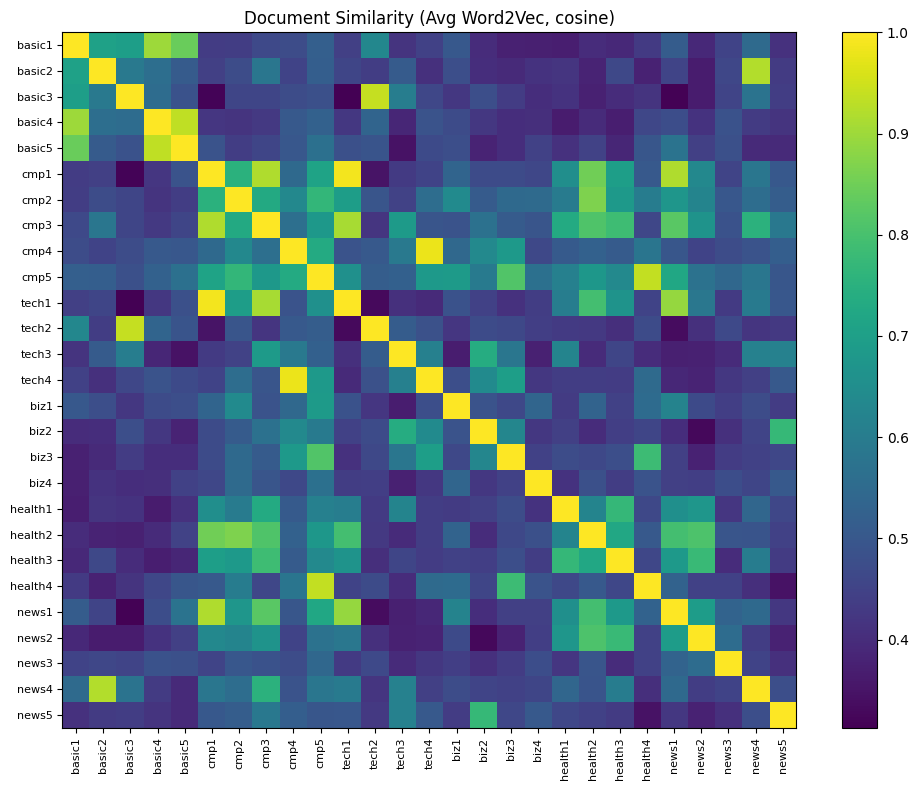

In [6]:
# ---------------------------------------------------------------------
# 5) 문서 임베딩(평균) 유사도 히트맵
# ---------------------------------------------------------------------

def doc_embedding(model: Word2Vec, tokens: List[str]) -> np.ndarray:
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if not vecs:
        return np.zeros(model.vector_size, dtype=float)
    return np.mean(vecs, axis=0)

doc_titles = (
    [f"basic{i+1}" for i in range(len(documents_basic))] +
    [f"cmp{i+1}" for i in range(len(documents_compare))] +
    [f"tech{i+1}" for i in range(len(tech_docs))] +
    [f"biz{i+1}" for i in range(len(business_docs))] +
    [f"health{i+1}" for i in range(len(health_docs))] +
    [f"news{i+1}" for i in range(len(news_articles))]
)

doc_vecs = np.vstack([doc_embedding(w2v_sg, tokens) for tokens in corpus])
sim_mat = cosine_similarity(doc_vecs)

plt.figure(figsize=(10,8))
plt.imshow(sim_mat, aspect='auto')
plt.title('Document Similarity (Avg Word2Vec, cosine)')
plt.colorbar()
plt.xticks(range(len(doc_titles)), doc_titles, rotation=90, fontsize=8)
plt.yticks(range(len(doc_titles)), doc_titles, fontsize=8)
plt.tight_layout()
plt.show()



---



### **예제 : Word2Vec Quicktour**

🧠 Word2Vec 마스터하기!
1️⃣ 기본 개념 시연...
🧠 Word2Vec 기본 개념 이해하기
📄 분석할 문장들:
  문장1: 왕과 여왕은 왕궁에 삽니다
  문장2: 남자와 여자는 사람입니다
  문장3: 아버지와 어머니는 부모입니다
  문장4: 아들과 딸은 자녀입니다
  문장5: 형과 누나는 형제자매입니다

📚 구축된 어휘 (16개):
  ['남자와', '누나', '딸은', '부모입니다', '사람입니다', '삽니다', '아들', '아버지와', '어머니', '여왕은', '여자', '왕', '왕궁', '자녀입니다', '형', '형제자매입니다']

🎯 Skip-gram 학습 데이터 생성 (윈도우 크기: 2):
  총 34개의 학습 쌍 생성
  예시 학습 쌍들:
    왕 → 여왕은
    왕 → 왕궁
    여왕은 → 왕
    여왕은 → 왕궁
    여왕은 → 삽니다
    왕궁 → 왕
    왕궁 → 여왕은
    왕궁 → 삽니다
    ... 외 26개

⚡ 벡터 학습 시뮬레이션:
  초기 벡터 (일부):
    남자와: [0.050, -0.014, 0.065, 0.152]
    누나: [-0.023, -0.023, 0.158, 0.077]
    딸은: [-0.047, 0.054, -0.046, -0.047]
    부모입니다: [0.024, -0.191, -0.172, -0.056]
    사람입니다: [-0.101, 0.031, -0.091, -0.141]

📈 학습 과정 시뮬레이션:
  (실제로는 경사하강법과 역전파를 통해 벡터가 업데이트됩니다)
  학습 후 벡터 (일부):
    남자와: [0.050, -0.014, 0.065, 0.152]
    누나: [-0.032, -0.025, 0.139, 0.080]
    딸은: [-0.047, 0.054, -0.046, -0.047]
    부모입니다: [0.024, -0.191, -0.172, -0.056]
    사람입니다: [-0.101, 0.031, -0.091, -0.141]

🔗 단어 간

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48289 (\N{HANGUL SYLLABLE BEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

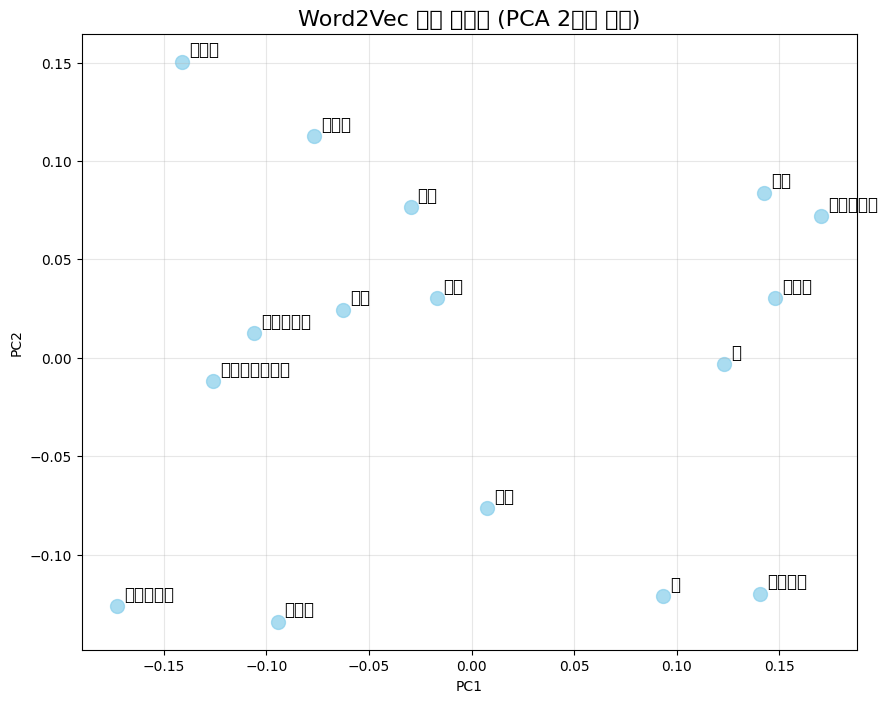


💡 Word2Vec 핵심 원리:
  ✅ 비슷한 맥락에서 나타나는 단어들은 비슷한 벡터를 가집니다
  ✅ 벡터 간 거리가 가까우면 의미가 유사합니다
  ✅ 벡터 연산으로 단어 관계를 표현할 수 있습니다

2️⃣ Gensim Word2Vec 실습...

🔬 Gensim Word2Vec 실습
📚 학습 데이터:
  문장1: 사과 바나나 과일 맛있다
  문장2: 딸기 포도 과일 달다
  문장3: 과일 건강 좋다 비타민
  문장4: 개 고양이 동물 귀엽다
  문장5: 토끼 햄스터 동물 작다
  ... 총 12개 문장

✅ Word2Vec 모델 학습 완료!
   어휘 크기: 39
   벡터 차원: 50

🔍 유사한 단어 찾기:
  '과일' 유사 단어: [('생명', 0.2247316837310791), ('비타민', 0.21897417306900024), ('이동', 0.19494770467281342)]
  '동물' 유사 단어: [('귀엽다', 0.381093829870224), ('개', 0.2472396343946457), ('토끼', 0.23257431387901306)]
  '교통수단' 유사 단어: [('딸기', 0.26161184906959534), ('맛있다', 0.25383681058883667), ('자동차', 0.20342133939266205)]
  '전자기기' 유사 단어: [('자동차', 0.2743566930294037), ('건강', 0.25583741068840027), ('스마트폰', 0.24409879744052887)]

🎯 단어 간 유사도:
  사과 - 바나나: -0.1653
  개 - 고양이: -0.1290
  자동차 - 컴퓨터: -0.0448
  과일 - 동물: -0.1571

📊 벡터 시각화:


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48289 (\N{HANGUL SYLLABLE BEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

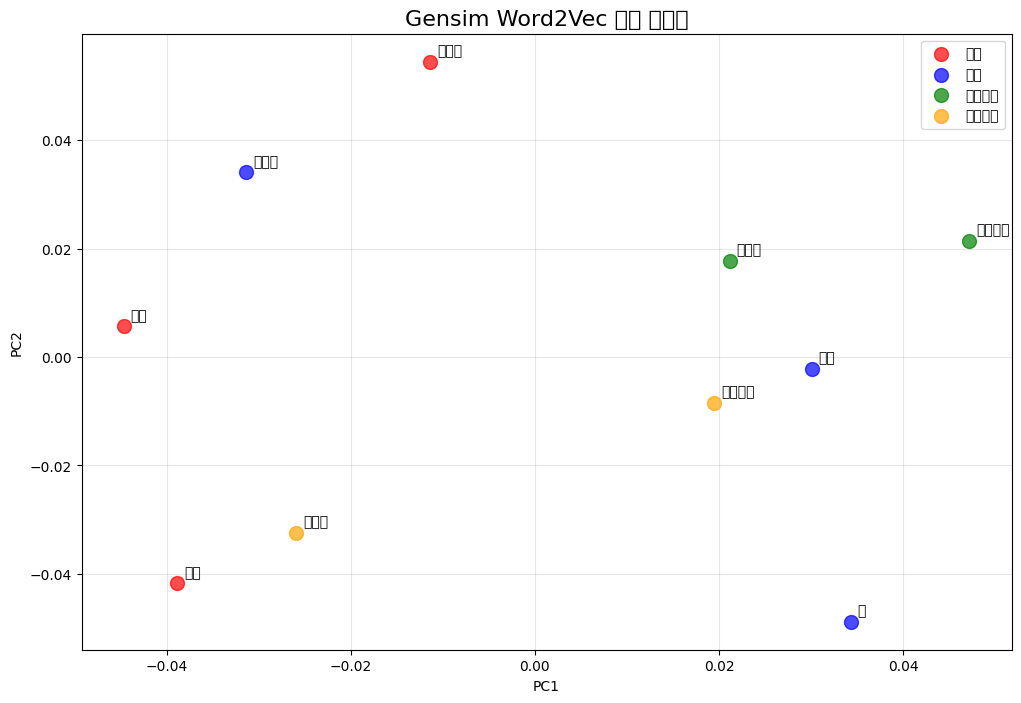

✅ 시각화 완료! 같은 카테고리의 단어들이 가까이 모여있는지 확인하세요.

3️⃣ 실전 응용 예제...

🚀 Word2Vec 실전 응용
📚 확장 데이터셋으로 학습 (총 15개 문장)
✅ 확장 모델 학습 완료!

📂 자동 카테고리 분류:
  클러스터링 결과:
    클러스터 1: ['한식(음식)', '중식(음식)', '양식(음식)', '김치(음식)', '짜장면(음식)', '초밥(음식)', '파스타(음식)', '축구(스포츠)', '농구(스포츠)', '테니스(스포츠)']
    클러스터 2: ['일식(음식)', '야구(스포츠)', '골(스포츠)', '홈런(스포츠)', '컴퓨터(기술)', '스마트폰(기술)', '인터넷(기술)', '인공지능(기술)', '프로그래밍(기술)', '앱(기술)']
    클러스터 0: ['선수(스포츠)', '경기(스포츠)']

📄 문서 유사도 계산:
  문서 간 유사도 매트릭스:
  문서1: 한식 김치 된장찌개 맛있다
  문서2: 축구 선수 월드컵 경기
  문서3: 컴퓨터 프로그래밍 소프트웨어
  문서4: 중식 짜장면 맛있다

  유사도 매트릭스:
  1.000  0.909  0.903  0.914
  0.909  1.000  0.879  0.885
  0.903  0.879  1.000  0.890
  0.914  0.885  0.890  1.000


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47553 (\N{HANGUL SYLLABLE RING}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

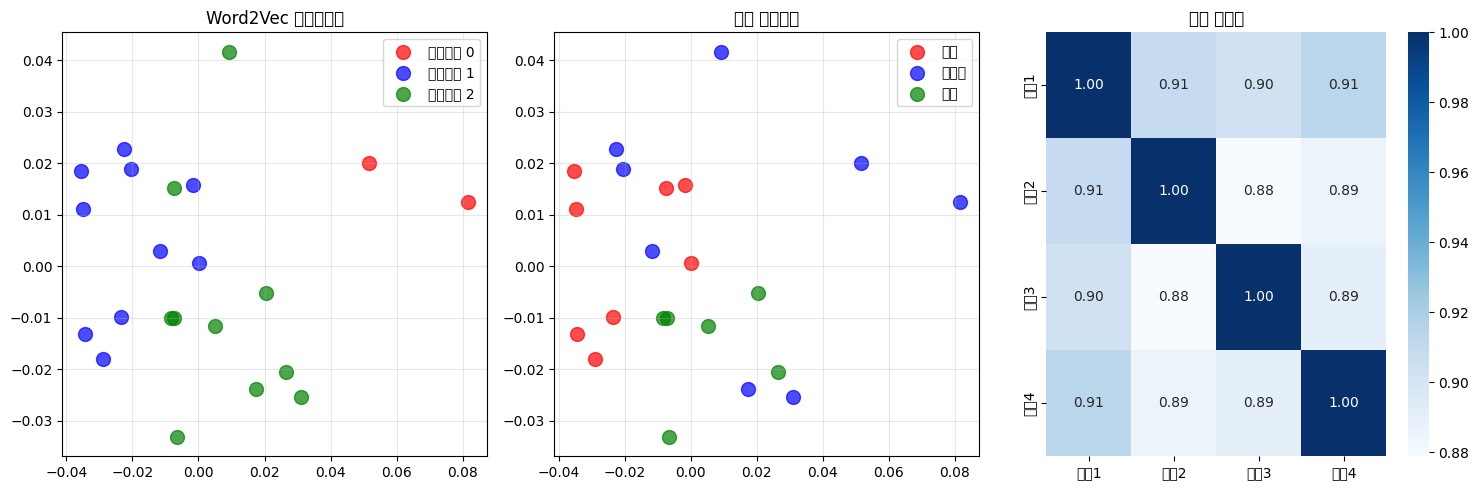


🎉 Word2Vec 기본기 학습 완료!
💡 핵심 포인트:
   ✅ Skip-gram: 중심단어 → 주변단어 예측
   ✅ CBOW: 주변단어 → 중심단어 예측
   ✅ 벡터 공간: 유사한 단어는 가까이 위치
   ✅ 응용: 분류, 클러스터링, 추천 시스템


In [7]:
# Word2Vec 간단 테스트
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt


def simple_word2vec_demo():
    """
    Word2Vec 기본 개념을 보여주는 간단한 예제
    """
    print("🧠 Word2Vec 기본 개념 이해하기")
    print("=" * 50)

    # 예제 문서들
    sentences = [
        "왕과 여왕은 왕궁에 삽니다",
        "남자와 여자는 사람입니다",
        "아버지와 어머니는 부모입니다",
        "아들과 딸은 자녀입니다",
        "형과 누나는 형제자매입니다"
    ]

    print("📄 분석할 문장들:")
    for i, sentence in enumerate(sentences):
        print(f"  문장{i+1}: {sentence}")

    #-------------------------------------
    # 1단계: 어휘 구축
    #-------------------------------------
    all_words = set()
    processed_sentences = []

    for sentence in sentences:
        # 간단한 전처리
        words = sentence.replace('과', '').replace('는', '').replace('에', '').split()
        processed_sentences.append(words)
        all_words.update(words)

    vocab = sorted(list(all_words))
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}

    print(f"\n📚 구축된 어휘 ({len(vocab)}개):")
    print(f"  {vocab}")

    #-------------------------------------
    # 2단계: Skip-gram 학습 데이터 생성
    #-------------------------------------
    print(f"\n🎯 Skip-gram 학습 데이터 생성 (윈도우 크기: 2):")

    training_pairs = []
    for sentence_words in processed_sentences:
        for i, target_word in enumerate(sentence_words):
            # 윈도우 범위 설정
            start = max(0, i - 2)
            end = min(len(sentence_words), i + 3)

            for j in range(start, end):
                if j != i:  # 타겟 단어 제외
                    context_word = sentence_words[j]
                    training_pairs.append((target_word, context_word))

    print(f"  총 {len(training_pairs)}개의 학습 쌍 생성")
    print("  예시 학습 쌍들:")
    for i, (target, context) in enumerate(training_pairs[:8]):
        print(f"    {target} → {context}")
    if len(training_pairs) > 8:
        print(f"    ... 외 {len(training_pairs)-8}개")

    #-------------------------------------
    # 3단계: 간단한 벡터 초기화 및 학습 시뮬레이션
    #-------------------------------------
    print(f"\n⚡ 벡터 학습 시뮬레이션:")

    vector_size = 4  # 간단한 시각화를 위해 4차원
    word_vectors = {}

    # 랜덤 초기화
    np.random.seed(42)  # 재현 가능한 결과
    for word in vocab:
        word_vectors[word] = np.random.normal(0, 0.1, vector_size)

    print("  초기 벡터 (일부):")
    for word in vocab[:5]:
        print(f"    {word}: [{', '.join([f'{x:.3f}' for x in word_vectors[word]])}]")

    # 간단한 학습 시뮬레이션 (실제 역전파는 복잡하므로 개념적 설명)
    print(f"\n📈 학습 과정 시뮬레이션:")
    print("  (실제로는 경사하강법과 역전파를 통해 벡터가 업데이트됩니다)")

    # 유사한 단어들을 가까이 배치하는 시뮬레이션
    similar_pairs = [
        ("왕", "여왕"), ("남자", "여자"), ("아버지", "어머니"), ("아들", "딸"), ("형", "누나")
    ]

    for word1, word2 in similar_pairs:
        if word1 in word_vectors and word2 in word_vectors:
            # 유사한 단어들의 벡터를 점진적으로 가깝게 만들기
            avg_vector = (word_vectors[word1] + word_vectors[word2]) / 2
            word_vectors[word1] = 0.7 * word_vectors[word1] + 0.3 * avg_vector
            word_vectors[word2] = 0.7 * word_vectors[word2] + 0.3 * avg_vector

    print("  학습 후 벡터 (일부):")
    for word in vocab[:5]:
        print(f"    {word}: [{', '.join([f'{x:.3f}' for x in word_vectors[word]])}]")

    #-------------------------------------
    # 4단계: 유사도 계산
    #-------------------------------------
    def cosine_similarity(vec1, vec2):
        dot_product = np.dot(vec1, vec2)
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)
        return dot_product / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0

    print(f"\n🔗 단어 간 유사도 계산:")

    test_pairs = [
        ("왕", "여왕"),
        ("남자", "여자"),
        ("아버지", "어머니"),
        ("왕", "남자"),
        ("왕", "딸")
    ]

    for word1, word2 in test_pairs:
        if word1 in word_vectors and word2 in word_vectors:
            similarity = cosine_similarity(word_vectors[word1], word_vectors[word2])
            print(f"  {word1} - {word2}: {similarity:.4f}")

    #-------------------------------------
    # 5단계: 시각화 (2차원으로 축소)
    #-------------------------------------
    from sklearn.decomposition import PCA

    # 벡터들을 배열로 변환
    vectors = np.array([word_vectors[word] for word in vocab])

    # PCA로 2차원 축소
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)

    # 시각화
    plt.figure(figsize=(10, 8))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=100, alpha=0.7, c='skyblue')

    # 단어 라벨 추가
    for i, word in enumerate(vocab):
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=12)

    plt.title('Word2Vec 벡터 시각화 (PCA 2차원 축소)', fontsize=16)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"\n💡 Word2Vec 핵심 원리:")
    print("  ✅ 비슷한 맥락에서 나타나는 단어들은 비슷한 벡터를 가집니다")
    print("  ✅ 벡터 간 거리가 가까우면 의미가 유사합니다")
    print("  ✅ 벡터 연산으로 단어 관계를 표현할 수 있습니다")

    return word_vectors


def gensim_word2vec_example():
    """
    Gensim을 사용한 실제 Word2Vec 예제
    """
    print(f"\n" + "=" * 50)
    print("🔬 Gensim Word2Vec 실습")
    print("=" * 50)

    try:
        from gensim.models import Word2Vec

        # 한국어 문장들 (토큰화된 형태)
        sentences = [
            ['사과', '바나나', '과일', '맛있다'],
            ['딸기', '포도', '과일', '달다'],
            ['과일', '건강', '좋다', '비타민'],
            ['개', '고양이', '동물', '귀엽다'],
            ['토끼', '햄스터', '동물', '작다'],
            ['동물', '생명', '소중하다', '보호'],
            ['자동차', '기차', '교통수단', '빠르다'],
            ['버스', '지하철', '교통수단', '편리하다'],
            ['교통수단', '이동', '필요하다', '중요'],
            ['컴퓨터', '스마트폰', '전자기기', '유용하다'],
            ['태블릿', '노트북', '전자기기', '편리하다'],
            ['전자기기', '기술', '발전', '놀랍다']
        ]

        print("📚 학습 데이터:")
        for i, sentence in enumerate(sentences[:5]):
            print(f"  문장{i+1}: {' '.join(sentence)}")
        print(f"  ... 총 {len(sentences)}개 문장")

        # Word2Vec 모델 학습
        model = Word2Vec(
            sentences=sentences,
            vector_size=50,      # 벡터 차원
            window=3,           # 윈도우 크기
            min_count=1,        # 최소 빈도
            workers=1,          # 병렬 처리 수
            sg=1,              # Skip-gram (0이면 CBOW)
            epochs=100
        )

        print(f"\n✅ Word2Vec 모델 학습 완료!")
        print(f"   어휘 크기: {len(model.wv.key_to_index)}")
        print(f"   벡터 차원: {model.wv.vector_size}")

        # 1. 유사한 단어 찾기
        print(f"\n🔍 유사한 단어 찾기:")
        test_words = ['과일', '동물', '교통수단', '전자기기']

        for word in test_words:
            if word in model.wv:
                try:
                    similar_words = model.wv.most_similar(word, topn=3)
                    print(f"  '{word}' 유사 단어: {similar_words}")
                except:
                    print(f"  '{word}': 유사 단어 계산 실패")

        # 2. 단어 간 유사도
        print(f"\n🎯 단어 간 유사도:")
        word_pairs = [
            ('사과', '바나나'),      # 같은 카테고리
            ('개', '고양이'),        # 같은 카테고리
            ('자동차', '컴퓨터'),    # 다른 카테고리
            ('과일', '동물')         # 다른 카테고리
        ]

        for word1, word2 in word_pairs:
            if word1 in model.wv and word2 in model.wv:
                similarity = model.wv.similarity(word1, word2)
                print(f"  {word1} - {word2}: {similarity:.4f}")

        # 3. 단어 벡터 시각화
        print(f"\n📊 벡터 시각화:")

        # 주요 단어들의 벡터 추출
        words_to_plot = ['과일', '사과', '바나나', '동물', '개', '고양이',
                        '교통수단', '자동차', '전자기기', '컴퓨터']

        vectors = []
        labels = []

        for word in words_to_plot:
            if word in model.wv:
                vectors.append(model.wv[word])
                labels.append(word)

        # PCA로 2차원 축소
        from sklearn.decomposition import PCA

        vectors = np.array(vectors)
        pca = PCA(n_components=2)
        vectors_2d = pca.fit_transform(vectors)

        # 카테고리별 색상
        categories = {
            '과일': ['과일', '사과', '바나나'],
            '동물': ['동물', '개', '고양이'],
            '교통수단': ['교통수단', '자동차'],
            '전자기기': ['전자기기', '컴퓨터']
        }

        colors = {'과일': 'red', '동물': 'blue', '교통수단': 'green', '전자기기': 'orange'}

        plt.figure(figsize=(12, 8))

        for category, words_in_cat in categories.items():
            indices = [i for i, word in enumerate(labels) if word in words_in_cat]
            if indices:
                plt.scatter(vectors_2d[indices, 0], vectors_2d[indices, 1],
                           c=colors[category], label=category, s=100, alpha=0.7)

        # 단어 라벨 추가
        for i, word in enumerate(labels):
            plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]),
                        xytext=(5, 5), textcoords='offset points', fontsize=10)

        plt.title('Gensim Word2Vec 벡터 시각화', fontsize=16)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        print("✅ 시각화 완료! 같은 카테고리의 단어들이 가까이 모여있는지 확인하세요.")

        return model

    except ImportError:
        print("❌ Gensim이 설치되지 않았습니다.")
        print("설치: pip install gensim")
        return None


def word2vec_applications_demo():
    """
    Word2Vec 실전 응용 예제
    """
    print(f"\n" + "=" * 50)
    print("🚀 Word2Vec 실전 응용")
    print("=" * 50)

    try:
        from gensim.models import Word2Vec
        from sklearn.cluster import KMeans

        # 더 큰 데이터셋
        extended_sentences = [
            # 음식 관련
            ['한식', '김치', '된장찌개', '맛있다', '전통', '음식'],
            ['중식', '짜장면', '탕수육', '맛있다', '중국', '음식'],
            ['일식', '초밥', '라멘', '신선하다', '일본', '음식'],
            ['양식', '파스타', '피자', '맛있다', '서양', '음식'],
            ['음식', '요리', '맛', '건강', '영양', '중요'],

            # 스포츠 관련
            ['축구', '월드컵', '선수', '경기', '골', '승부'],
            ['야구', '홈런', '투수', '타자', '경기장', '응원'],
            ['농구', '덩크슛', '선수', '코트', '팀워크', '전략'],
            ['테니스', '라켓', '선수', '코트', '서브', '경기'],
            ['스포츠', '운동', '건강', '체력', '팀워크', '중요'],

            # 기술 관련
            ['컴퓨터', '프로그래밍', '소프트웨어', '개발', '기술', '혁신'],
            ['스마트폰', '앱', '모바일', '편리', '통신', '기술'],
            ['인터넷', '웹사이트', '정보', '검색', '연결', '네트워크'],
            ['인공지능', '머신러닝', '데이터', '학습', '미래', '기술'],
            ['기술', '발전', '혁신', '미래', '사회', '변화']
        ]

        print(f"📚 확장 데이터셋으로 학습 (총 {len(extended_sentences)}개 문장)")

        # 모델 학습
        app_model = Word2Vec(
            sentences=extended_sentences,
            vector_size=100,
            window=4,
            min_count=1,
            workers=1,
            sg=1,
            epochs=200
        )

        print("✅ 확장 모델 학습 완료!")

        # 1. 카테고리 분류
        print(f"\n📂 자동 카테고리 분류:")

        # 주요 단어들의 벡터 추출
        food_words = ['한식', '중식', '일식', '양식', '김치', '짜장면', '초밥', '파스타']
        sports_words = ['축구', '야구', '농구', '테니스', '선수', '경기', '골', '홈런']
        tech_words = ['컴퓨터', '스마트폰', '인터넷', '인공지능', '프로그래밍', '앱']

        all_words = food_words + sports_words + tech_words
        vectors = []
        labels = []
        categories = []

        for word in all_words:
            if word in app_model.wv:
                vectors.append(app_model.wv[word])
                labels.append(word)
                if word in food_words:
                    categories.append('음식')
                elif word in sports_words:
                    categories.append('스포츠')
                else:
                    categories.append('기술')

        # K-means 클러스터링
        vectors = np.array(vectors)
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(vectors)

        print("  클러스터링 결과:")
        cluster_words = defaultdict(list)
        for word, cluster, true_cat in zip(labels, clusters, categories):
            cluster_words[cluster].append(f"{word}({true_cat})")

        for cluster_id, words in cluster_words.items():
            print(f"    클러스터 {cluster_id}: {words}")

        # 2. 문서 유사도 계산
        print(f"\n📄 문서 유사도 계산:")

        test_documents = [
            "한식 김치 된장찌개 맛있다",
            "축구 선수 월드컵 경기",
            "컴퓨터 프로그래밍 소프트웨어",
            "중식 짜장면 맛있다"
        ]

        def document_vector(doc, model):
            """문서를 벡터로 변환 (단어 벡터들의 평균)"""
            words = doc.split()
            vectors = []
            for word in words:
                if word in model.wv:
                    vectors.append(model.wv[word])

            if vectors:
                return np.mean(vectors, axis=0)
            else:
                return np.zeros(model.wv.vector_size)

        doc_vectors = [document_vector(doc, app_model) for doc in test_documents]

        # 문서 간 유사도 계산
        from sklearn.metrics.pairwise import cosine_similarity
        doc_similarity = cosine_similarity(doc_vectors)

        print("  문서 간 유사도 매트릭스:")
        for i, doc in enumerate(test_documents):
            print(f"  문서{i+1}: {doc}")

        print(f"\n  유사도 매트릭스:")
        for i in range(len(test_documents)):
            for j in range(len(test_documents)):
                print(f"  {doc_similarity[i][j]:.3f}", end="")
            print()

        # 3. 시각화
        plt.figure(figsize=(15, 5))

        # 클러스터링 결과 시각화
        plt.subplot(1, 3, 1)

        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        vectors_2d = pca.fit_transform(vectors)

        colors = ['red', 'blue', 'green']
        for i, cluster in enumerate(set(clusters)):
            indices = [j for j, c in enumerate(clusters) if c == cluster]
            plt.scatter(vectors_2d[indices, 0], vectors_2d[indices, 1],
                       c=colors[i], label=f'클러스터 {cluster}', s=100, alpha=0.7)

        plt.title('Word2Vec 클러스터링', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 카테고리별 색상
        plt.subplot(1, 3, 2)

        category_colors = {'음식': 'red', '스포츠': 'blue', '기술': 'green'}
        for category in category_colors.keys():
            indices = [i for i, cat in enumerate(categories) if cat == category]
            if indices:
                plt.scatter(vectors_2d[indices, 0], vectors_2d[indices, 1],
                           c=category_colors[category], label=category, s=100, alpha=0.7)

        plt.title('실제 카테고리', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 문서 유사도 히트맵
        plt.subplot(1, 3, 3)
        import seaborn as sns

        sns.heatmap(doc_similarity, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=[f'문서{i+1}' for i in range(len(test_documents))],
                    yticklabels=[f'문서{i+1}' for i in range(len(test_documents))])
        plt.title('문서 유사도', fontsize=12)

        plt.tight_layout()
        plt.show()

        return app_model

    except ImportError:
        print("❌ 필요한 라이브러리가 설치되지 않았습니다.")
        print("설치: pip install gensim scikit-learn")
        return None


# 전체 실행 함수
def run_simple_word2vec_tests():
    """
    간단한 Word2Vec 테스트들 실행
    """
    try:
        print("🧠 Word2Vec 마스터하기!")
        print("=" * 60)

        # 1. 기본 개념 이해
        print("1️⃣ 기본 개념 시연...")
        word_vectors = simple_word2vec_demo()

        # 2. Gensim 실습
        print("\n2️⃣ Gensim Word2Vec 실습...")
        gensim_model = gensim_word2vec_example()

        # 3. 실전 응용
        print("\n3️⃣ 실전 응용 예제...")
        app_model = word2vec_applications_demo()

        print(f"\n" + "=" * 60)
        print("🎉 Word2Vec 기본기 학습 완료!")
        print("💡 핵심 포인트:")
        print("   ✅ Skip-gram: 중심단어 → 주변단어 예측")
        print("   ✅ CBOW: 주변단어 → 중심단어 예측")
        print("   ✅ 벡터 공간: 유사한 단어는 가까이 위치")
        print("   ✅ 응용: 분류, 클러스터링, 추천 시스템")
        print("=" * 60)

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("⚠️ 필수 라이브러리 설치 필요:")
        print("   pip install gensim scikit-learn matplotlib seaborn")


# 실행
if __name__ == "__main__":
    run_simple_word2vec_tests()

- t-SNE (t-distributed Stochastic Neighbor Embedding)
    - 고차원 데이터의 유사성을 저차원(2D/3D) 공간에 보존하여 시각화하는 비선형 차원 축소 기법

In [ ]:
# ---------------------------------------------------------------------
# 6) t-SNE로 단어 벡터 2D 시각화
# ---------------------------------------------------------------------

# 빈도가 2회 이상인 단어만 시각화 (잡음 제거)
freq = Counter([w for sent in corpus for w in sent])
vocab_tsne = [w for w,c in freq.items() if c >= 2 and w in w2v_sg.wv]

if len(vocab_tsne) >= 10:
    X = np.vstack([w2v_sg.wv[w] for w in vocab_tsne])
    tsne = TSNE(n_components=2, perplexity=min(30, max(5, len(vocab_tsne)//3)), random_state=42, n_iter=1000)
    X2 = tsne.fit_transform(X)

    plt.figure(figsize=(9,7))
    # plt.rcParams["font.family"] = 'NanumBarunGothic'
    plt.scatter(X2[:,0], X2[:,1])
    for i, w in enumerate(vocab_tsne):
        plt.annotate(w, (X2[i,0], X2[i,1]), fontsize=9, alpha=0.9)
    plt.title('t-SNE visualization of Word2Vec (Skip-gram)')
    plt.tight_layout()
    plt.show()
else:
    print("단어 수가 적어 t-SNE 시각화를 생략합니다. (빈도≥2 단어가 10개 미만)")

# 다음을 시도해보세요
# - sg=0(CBOW) 모델로 동일한 분석 비교
# - window, vector_size, epochs 변경해 성능 비교
# - 도메인별(기술/비즈니스/건강) 말뭉치로 따로 학습해 군집 차이 관찰

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 강화
import matplotlib.font_manager as fm

def ensure_korean_font():
    """한글 폰트 설정 확인 및 재설정"""
    try:
        plt.rcParams['font.family'] = 'NanumBarunGothic'
    except:
        try:
            plt.rcParams['font.family'] = 'NanumGothic'
        except:
            plt.rcParams['font.family'] = 'DejaVu Sans'

    plt.rcParams['axes.unicode_minus'] = False

    # 사용 가능한 한글 폰트 찾기
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    korean_fonts = [f for f in available_fonts if any(keyword in f for keyword in
                   ['Nanum', 'Malgun', 'Dotum', 'Gulim', 'Batang', 'Gungsuh'])]

    if korean_fonts:
        plt.rcParams['font.family'] = korean_fonts[0]

# 초기 폰트 설정
ensure_korean_font()

class Word2VecImplementation:
    def __init__(self, vector_size=100, window_size=3, min_count=1,
                 epochs=100, learning_rate=0.025, model_type='skipgram'):
        """
        Word2Vec 구현 클래스

        Args:
            vector_size: 벡터 차원 수
            window_size: 컨텍스트 윈도우 크기
            min_count: 최소 단어 빈도
            epochs: 학습 에포크 수
            learning_rate: 학습률
            model_type: 'skipgram' 또는 'cbow'
        """
        self.vector_size = vector_size
        self.window_size = window_size
        self.min_count = min_count
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.model_type = model_type

        self.vocab = {}
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.word_vectors = None
        self.context_vectors = None
        self.vocab_size = 0

    def preprocess_text(self, text):
        """텍스트 전처리"""
        # 한글과 영문, 숫자만 유지
        text = re.sub(r'[^\w\s가-힣]', '', text.lower())
        return [word for word in text.split() if word.strip()]

    def build_vocabulary(self, sentences):
        """어휘 구축"""
        word_counts = Counter()

        # 모든 문장에서 단어 빈도 계산
        for sentence in sentences:
            words = self.preprocess_text(sentence)
            word_counts.update(words)

        # 최소 빈도 필터링
        filtered_words = {word: count for word, count in word_counts.items()
                         if count >= self.min_count}

        # 어휘 매핑 생성
        self.vocab = filtered_words
        self.word_to_idx = {word: idx for idx, word in enumerate(filtered_words.keys())}
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.vocab_size = len(self.vocab)

        print(f"구축된 어휘 크기: {self.vocab_size}")
        return filtered_words

    def generate_training_data(self, sentences):
        """학습 데이터 생성"""
        training_data = []

        for sentence in sentences:
            words = self.preprocess_text(sentence)
            words = [w for w in words if w in self.word_to_idx]

            for i, target_word in enumerate(words):
                # 컨텍스트 윈도우 내의 단어들
                start = max(0, i - self.window_size)
                end = min(len(words), i + self.window_size + 1)

                context_words = []
                for j in range(start, end):
                    if j != i:  # 타겟 단어 제외
                        context_words.append(words[j])

                if len(context_words) >= 1:
                    if self.model_type == 'skipgram':
                        # Skip-gram: 중심 단어 → 주변 단어들
                        for context_word in context_words:
                            training_data.append((target_word, context_word))
                    else:  # CBOW
                        # CBOW: 주변 단어들 → 중심 단어
                        training_data.append((context_words, target_word))

        return training_data

    def sigmoid(self, x):
        """시그모이드 함수"""
        x = np.clip(x, -500, 500)  # 오버플로우 방지
        return 1 / (1 + np.exp(-x))

    def train(self, sentences):
        """모델 학습"""
        print(f"{self.model_type.upper()} 모델 학습 시작...")

        # 어휘 구축
        self.build_vocabulary(sentences)

        if self.vocab_size < 2:
            print("어휘가 너무 적습니다.")
            return

        # 가중치 초기화
        self.word_vectors = np.random.uniform(-0.5, 0.5,
                                            (self.vocab_size, self.vector_size))
        self.context_vectors = np.random.uniform(-0.5, 0.5,
                                               (self.vocab_size, self.vector_size))

        # 학습 데이터 생성
        training_data = self.generate_training_data(sentences)
        print(f"학습 샘플 수: {len(training_data)}")

        if not training_data:
            print("학습 데이터가 없습니다.")
            return

        # 학습 루프
        for epoch in range(self.epochs):
            total_loss = 0

            for sample in training_data:
                if self.model_type == 'skipgram':
                    loss = self._train_skipgram(sample)
                else:
                    loss = self._train_cbow(sample)
                total_loss += loss

            if epoch % 20 == 0:
                avg_loss = total_loss / len(training_data)
                print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

        print("학습 완료!")

    def _train_skipgram(self, sample):
        """Skip-gram 학습"""
        target_word, context_word = sample

        if target_word not in self.word_to_idx or context_word not in self.word_to_idx:
            return 0

        target_idx = self.word_to_idx[target_word]
        context_idx = self.word_to_idx[context_word]

        # Forward pass
        target_vector = self.word_vectors[target_idx]
        context_vector = self.context_vectors[context_idx]

        # 내적 계산
        score = np.dot(target_vector, context_vector)
        pred = self.sigmoid(score)

        # Loss 계산 (이진 분류)
        loss = -np.log(pred + 1e-10)

        # Backward pass
        error = pred - 1  # 정답이 1이므로

        # 그래디언트 계산 및 업데이트
        word_grad = error * context_vector
        context_grad = error * target_vector

        self.word_vectors[target_idx] -= self.learning_rate * word_grad
        self.context_vectors[context_idx] -= self.learning_rate * context_grad

        return loss

    def _train_cbow(self, sample):
        """CBOW 학습"""
        context_words, target_word = sample

        if target_word not in self.word_to_idx:
            return 0

        # 컨텍스트 벡터들의 평균
        context_indices = [self.word_to_idx[w] for w in context_words
                          if w in self.word_to_idx]

        if not context_indices:
            return 0

        context_vector = np.mean([self.context_vectors[idx] for idx in context_indices], axis=0)
        target_idx = self.word_to_idx[target_word]

        # Forward pass
        scores = np.dot(self.word_vectors, context_vector)
        scores = scores - np.max(scores)  # 수치 안정성

        # Softmax
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores)

        # Loss 계산
        loss = -np.log(probs[target_idx] + 1e-10)

        # Backward pass
        grad_output = probs.copy()
        grad_output[target_idx] -= 1.0

        # 가중치 업데이트
        word_grad = np.outer(grad_output, context_vector)
        self.word_vectors -= self.learning_rate * word_grad

        context_grad = np.dot(grad_output, self.word_vectors)
        for idx in context_indices:
            self.context_vectors[idx] -= self.learning_rate * context_grad / len(context_indices)

        return loss

    def get_vector(self, word):
        """단어 벡터 반환"""
        if word in self.word_to_idx:
            idx = self.word_to_idx[word]
            return self.word_vectors[idx]
        return None

    def similarity(self, word1, word2):
        """두 단어 간 코사인 유사도"""
        vec1 = self.get_vector(word1)
        vec2 = self.get_vector(word2)

        if vec1 is None or vec2 is None:
            return 0.0

        # 코사인 유사도
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)

        if norm1 == 0 or norm2 == 0:
            return 0.0

        return np.dot(vec1, vec2) / (norm1 * norm2)

    def most_similar(self, word, top_k=5):
        """가장 유사한 단어들 찾기"""
        if word not in self.word_to_idx:
            return []

        target_vector = self.get_vector(word)
        similarities = []

        for other_word in self.word_to_idx.keys():
            if other_word != word:
                sim = self.similarity(word, other_word)
                similarities.append((other_word, sim))

        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]

    def analogy(self, word_a, word_b, word_c, top_k=1):
        """단어 유추: A is to B as C is to ?"""
        try:
            vec_a = self.get_vector(word_a)
            vec_b = self.get_vector(word_b)
            vec_c = self.get_vector(word_c)

            if any(v is None for v in [vec_a, vec_b, vec_c]):
                return []

            # 벡터 연산: B - A + C
            result_vector = vec_b - vec_a + vec_c

            # 가장 유사한 단어 찾기
            similarities = []
            for word in self.word_to_idx.keys():
                if word not in [word_a, word_b, word_c]:
                    word_vec = self.get_vector(word)
                    if word_vec is not None:
                        sim = cosine_similarity([result_vector], [word_vec])[0][0]
                        similarities.append((word, sim))

            similarities.sort(key=lambda x: x[1], reverse=True)
            return similarities[:top_k]

        except:
            return []


def demonstrate_basic_word2vec():
    """기본 Word2Vec 구현 시연"""
    print("=" * 60)
    print("1. 기본 Word2Vec 구현 시연")
    print("=" * 60)

    # 예제 문서들 (더 많은 데이터로 확장)
    sentences = [
        "왕은 왕궁에서 생활합니다",
        "여왕은 왕궁에서 생활합니다",
        "남자는 남성이라고도 부릅니다",
        "여자는 여성이라고도 부릅니다",
        "왕과 여왕은 왕실 가족입니다",
        "남자와 여자는 사람입니다",
        "아버지는 가족의 가장입니다",
        "어머니는 가족을 돌봅니다",
        "아들은 아버지의 자녀입니다",
        "딸은 어머니의 자녀입니다",
        "컴퓨터는 전자 기기입니다",
        "노트북은 휴대용 컴퓨터입니다",
        "스마트폰은 휴대용 전화기입니다",
        "태블릿은 휴대용 기기입니다",
        "인공지능은 컴퓨터 기술입니다",
        "머신러닝은 인공지능 분야입니다",
        "딥러닝은 머신러닝 방법입니다",
        "데이터는 정보의 집합입니다"
    ]

    # Skip-gram 모델 학습
    print("\n🧠 Skip-gram 모델 학습:")
    skipgram_model = Word2VecImplementation(
        vector_size=50,
        window_size=2,
        epochs=200,
        model_type='skipgram',
        learning_rate=0.1
    )
    skipgram_model.train(sentences)

    # CBOW 모델 학습
    print(f"\n🧠 CBOW 모델 학습:")
    cbow_model = Word2VecImplementation(
        vector_size=50,
        window_size=2,
        epochs=200,
        model_type='cbow',
        learning_rate=0.1
    )
    cbow_model.train(sentences)

    # 결과 비교
    test_words = ["왕", "여왕", "남자", "여자", "컴퓨터"]

    print(f"\n📊 모델 결과 비교:")
    for word in test_words:
        if word in skipgram_model.word_to_idx:
            print(f"\n🔍 '{word}'와 유사한 단어들:")

            # Skip-gram 결과
            skipgram_similar = skipgram_model.most_similar(word, top_k=3)
            print(f"  Skip-gram: {skipgram_similar}")

            # CBOW 결과
            cbow_similar = cbow_model.most_similar(word, top_k=3)
            print(f"  CBOW: {cbow_similar}")

    return skipgram_model, cbow_model


def demonstrate_gensim_word2vec():
    """Gensim Word2Vec과 비교"""
    print("\n" + "=" * 60)
    print("2. Gensim Word2Vec과 성능 비교")
    print("=" * 60)

    try:
        from gensim.models import Word2Vec

        # 한국어 문장들
        korean_sentences = [
            ['인공지능', '기술', '발전', '빠르다'],
            ['머신러닝', '알고리즘', '학습', '데이터'],
            ['딥러닝', '신경망', '복잡한', '문제', '해결'],
            ['자연언어', '처리', 'NLP', '중요하다'],
            ['컴퓨터', '비전', '이미지', '인식'],
            ['빅데이터', '분석', '패턴', '발견'],
            ['클라우드', '컴퓨팅', '서비스', '제공'],
            ['로봇', '자동화', '미래', '산업'],
            ['블록체인', '암호화', '보안', '기술'],
            ['사물인터넷', 'IoT', '연결', '네트워크']
        ]

        # Gensim Word2Vec 모델
        gensim_model = Word2Vec(
            sentences=korean_sentences,
            vector_size=100,
            window=3,
            min_count=1,
            workers=1,
            sg=1,  # Skip-gram
            epochs=100
        )

        print("✅ Gensim Word2Vec 모델 학습 완료")
        print(f"어휘 크기: {len(gensim_model.wv.key_to_index)}")

        # 단어 유사도 테스트
        test_words = ['인공지능', '머신러닝', '컴퓨터', '데이터']

        print(f"\n📊 Gensim 모델 결과:")
        for word in test_words:
            if word in gensim_model.wv:
                try:
                    similar_words = gensim_model.wv.most_similar(word, topn=3)
                    print(f"  '{word}' 유사 단어: {similar_words}")
                except:
                    print(f"  '{word}': 유사 단어를 찾을 수 없습니다.")

        # 단어 간 유사도
        print(f"\n🔗 단어 간 유사도:")
        word_pairs = [
            ('인공지능', '머신러닝'),
            ('컴퓨터', '데이터'),
            ('신경망', '딥러닝')
        ]

        for word1, word2 in word_pairs:
            if word1 in gensim_model.wv and word2 in gensim_model.wv:
                similarity = gensim_model.wv.similarity(word1, word2)
                print(f"  {word1} - {word2}: {similarity:.4f}")

        return gensim_model

    except ImportError:
        print("❌ Gensim이 설치되지 않았습니다.")
        print("설치: pip install gensim")
        return None


def demonstrate_word2vec_visualization():
    """Word2Vec 벡터 시각화"""
    print("\n" + "=" * 60)
    print("3. Word2Vec 벡터 시각화")
    print("=" * 60)

    # 더 많은 데이터로 모델 학습
    extended_sentences = [
        "사과는 빨간 과일입니다", "바나나는 노란 과일입니다", "오렌지는 오렌지색 과일입니다",
        "포도는 보라색 과일입니다", "과일은 달고 맛있습니다", "과일은 건강에 좋습니다",
        "개는 충실한 동물입니다", "고양이는 귀여운 동물입니다", "토끼는 빠른 동물입니다",
        "사자는 강한 동물입니다", "동물은 생명체입니다", "동물은 자연에 삽니다",
        "자동차는 빠른 교통수단입니다", "기차는 긴 교통수단입니다", "비행기는 높은 교통수단입니다",
        "배는 물위의 교통수단입니다", "교통수단은 이동에 사용됩니다", "교통수단은 편리합니다",
        "책은 지식의 보고입니다", "신문은 정보를 제공합니다", "잡지는 재미있는 읽을거리입니다",
        "컴퓨터는 유용한 도구입니다", "스마트폰은 편리한 도구입니다", "도구는 일을 돕습니다"
    ]

    # 모델 학습
    viz_model = Word2VecImplementation(
        vector_size=50,
        window_size=3,
        epochs=300,
        model_type='skipgram',
        learning_rate=0.1
    )
    viz_model.train(extended_sentences)

    # 벡터 추출
    words = list(viz_model.word_to_idx.keys())
    vectors = []
    word_labels = []

    for word in words:
        vector = viz_model.get_vector(word)
        if vector is not None:
            vectors.append(vector)
            word_labels.append(word)

    if len(vectors) < 2:
        print("❌ 시각화할 벡터가 충분하지 않습니다.")
        return

    vectors = np.array(vectors)

    # PCA로 2차원 축소
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)

    # 시각화
    plt.figure(figsize=(15, 10))

    # 한글 폰트 재설정
    ensure_korean_font()

    # 1. PCA 시각화
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1],
                         c=np.arange(len(word_labels)),
                         cmap='tab20', s=100, alpha=0.7)

    # 단어 라벨 추가
    for i, word in enumerate(word_labels):
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    plt.title('Word2Vec 벡터 시각화 (PCA)', fontsize=14)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)

    # 2. 카테고리별 색상 구분
    plt.subplot(2, 2, 2)

    # 단어 카테고리 분류 (간단한 규칙 기반)
    categories = {
        '과일': ['사과', '바나나', '오렌지', '포도', '과일'],
        '동물': ['개', '고양이', '토끼', '사자', '동물'],
        '교통': ['자동차', '기차', '비행기', '배', '교통수단'],
        '도구': ['컴퓨터', '스마트폰', '도구', '책', '신문', '잡지']
    }

    colors = ['red', 'blue', 'green', 'orange', 'purple']
    category_colors = {}

    for i, (cat, words_in_cat) in enumerate(categories.items()):
        for word in words_in_cat:
            if word in word_labels:
                category_colors[word] = colors[i % len(colors)]

    # 카테고리별 색상으로 플롯
    for i, word in enumerate(word_labels):
        color = category_colors.get(word, 'gray')
        plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1],
                   c=color, s=100, alpha=0.7)
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    plt.title('카테고리별 단어 분포', fontsize=14)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)

    # 범례 추가
    for cat, color in zip(categories.keys(), colors):
        plt.scatter([], [], c=color, s=100, label=cat, alpha=0.7)
    plt.legend()

    # 3. 유사도 히트맵
    plt.subplot(2, 2, 3)

    # 주요 단어들만 선택
    main_words = [w for w in word_labels if len(w) > 1][:10]
    similarity_matrix = np.zeros((len(main_words), len(main_words)))

    for i, word1 in enumerate(main_words):
        for j, word2 in enumerate(main_words):
            similarity_matrix[i, j] = viz_model.similarity(word1, word2)

    sns.heatmap(similarity_matrix,
                xticklabels=main_words,
                yticklabels=main_words,
                annot=True, fmt='.2f', cmap='Blues')
    plt.title('단어 간 유사도 히트맵', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # 4. 벡터 크기 분포
    plt.subplot(2, 2, 4)
    vector_norms = [np.linalg.norm(viz_model.get_vector(word)) for word in word_labels]

    plt.hist(vector_norms, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('벡터 크기 분포', fontsize=14)
    plt.xlabel('벡터 크기')
    plt.ylabel('빈도')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 클러스터링 분석
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(vectors)

    print(f"\n🎯 클러스터링 결과:")
    cluster_words = defaultdict(list)
    for word, cluster in zip(word_labels, clusters):
        cluster_words[cluster].append(word)

    for cluster_id, words in cluster_words.items():
        print(f"  클러스터 {cluster_id}: {words}")

    return viz_model


def demonstrate_word_analogies():
    """단어 유추 예제"""
    print("\n" + "=" * 60)
    print("4. Word2Vec 단어 유추 (Word Analogies)")
    print("=" * 60)

    # 관계가 명확한 문장들로 학습
    analogy_sentences = [
        "남자는 아버지가 됩니다", "여자는 어머니가 됩니다",
        "남자는 왕이 됩니다", "여자는 여왕이 됩니다",
        "남자는 아들입니다", "여자는 딸입니다",
        "남자는 형이 됩니다", "여자는 누나가 됩니다",
        "남자는 남편입니다", "여자는 아내입니다",
        "어린 남자는 소년입니다", "어린 여자는 소녀입니다",
        "서울은 한국의 수도입니다", "도쿄는 일본의 수도입니다",
        "워싱턴은 미국의 수도입니다", "런던은 영국의 수도입니다",
        "한국 사람은 한국어를 씁니다", "일본 사람은 일본어를 씁니다",
        "미국 사람은 영어를 씁니다", "중국 사람은 중국어를 씁니다",
        "개는 멍멍하고 웁니다", "고양이는 야옹하고 웁니다",
        "소는 음메하고 웁니다", "돼지는 꿀꿀하고 웁니다",
        "크다의 반대는 작다입니다", "높다의 반대는 낮다입니다",
        "뜨겁다의 반대는 차갑다입니다", "밝다의 반대는 어둡다입니다"
    ]

    # 모델 학습
    analogy_model = Word2VecImplementation(
        vector_size=100,
        window_size=3,
        epochs=500,
        model_type='skipgram',
        learning_rate=0.1
    )
    analogy_model.train(analogy_sentences)

    # 단어 유추 테스트
    print(f"\n🧩 단어 유추 테스트:")

    analogy_tests = [
        ("남자", "아버지", "여자"),  # 남자:아버지 = 여자:?
        ("남자", "왕", "여자"),      # 남자:왕 = 여자:?
        ("서울", "한국", "도쿄"),    # 서울:한국 = 도쿄:?
        ("크다", "작다", "높다"),    # 크다:작다 = 높다:?
        ("개", "멍멍", "고양이")     # 개:멍멍 = 고양이:?
    ]

    for word_a, word_b, word_c in analogy_tests:
        print(f"\n  {word_a} : {word_b} = {word_c} : ?")

        results = analogy_model.analogy(word_a, word_b, word_c, top_k=3)
        if results:
            print(f"    예측 결과:")
            for word, score in results:
                print(f"      {word} (유사도: {score:.4f})")
        else:
            print(f"    결과를 찾을 수 없습니다.")


def demonstrate_practical_applications():
    """Word2Vec 실전 응용"""
    print("\n" + "=" * 60)
    print("5. Word2Vec 실전 응용 - 문서 분류 및 추천")
    print("=" * 60)

    # 뉴스 카테고리별 문서들
    news_data = {
        '기술': [
            "인공지능 기술이 빠르게 발전하면서 다양한 산업 분야에 혁신을 가져오고 있습니다",
            "머신러닝과 딥러닝 알고리즘을 활용한 자동화 시스템이 도입되고 있습니다",
            "빅데이터 분석 기술로 고객 행동 패턴을 예측하는 서비스가 등장했습니다",
            "클라우드 컴퓨팅 플랫폼이 기업의 디지털 전환을 가속화하고 있습니다",
            "사물인터넷과 스마트시티 기술이 도시 인프라를 혁신하고 있습니다"
        ],
        '스포츠': [
            "월드컵 축구 대회에서 한국 팀이 뛰어난 경기력을 보여주었습니다",
            "올림픽 수영 선수가 새로운 세계 기록을 경신했습니다",
            "프로야구 시즌이 시작되면서 팬들의 관심이 높아지고 있습니다",
            "테니스 그랜드슬램 대회에서 한국 선수가 우승을 차지했습니다",
            "마라톤 대회에 수많은 시민들이 참여하여 건강한 축제가 되었습니다"
        ],
        '경제': [
            "국내 경제 성장률이 전년 대비 상승세를 보이고 있습니다",
            "주식시장에서 기술주를 중심으로 상승 랠리가 이어지고 있습니다",
            "부동산 시장의 안정화 정책이 시행되면서 거래량이 조정되고 있습니다",
            "중소기업 지원 정책으로 창업 생태계가 활성화되고 있습니다",
            "글로벌 공급망 이슈가 국내 제조업에 영향을 미치고 있습니다"
        ]
    }

    # 모든 문서와 라벨 생성
    all_documents = []
    all_labels = []

    for category, documents in news_data.items():
        all_documents.extend(documents)
        all_labels.extend([category] * len(documents))

    # Word2Vec 모델 학습
    app_model = Word2VecImplementation(
        vector_size=100,
        window_size=4,
        epochs=300,
        model_type='skipgram',
        learning_rate=0.1
    )
    app_model.train(all_documents)

    print(f"✅ 모델 학습 완료 (어휘 크기: {app_model.vocab_size})")

    # 문서 벡터화 (단어 벡터들의 평균)
    def document_to_vector(doc, model):
        words = model.preprocess_text(doc)
        vectors = []
        for word in words:
            vec = model.get_vector(word)
            if vec is not None:
                vectors.append(vec)

        if vectors:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(model.vector_size)

    # 문서 벡터들 생성
    doc_vectors = []
    for doc in all_documents:
        doc_vec = document_to_vector(doc, app_model)
        doc_vectors.append(doc_vec)

    doc_vectors = np.array(doc_vectors)

    # 문서 유사도 분석
    print(f"\n📊 문서 유사도 분석:")

    # 카테고리 내/간 평균 유사도 계산
    category_similarities = defaultdict(list)

    for i in range(len(all_documents)):
        for j in range(i+1, len(all_documents)):
            sim = cosine_similarity([doc_vectors[i]], [doc_vectors[j]])[0][0]

            if all_labels[i] == all_labels[j]:
                category_similarities['같은_카테고리'].append(sim)
            else:
                category_similarities['다른_카테고리'].append(sim)

    same_cat_avg = np.mean(category_similarities['같은_카테고리'])
    diff_cat_avg = np.mean(category_similarities['다른_카테고리'])

    print(f"  같은 카테고리 문서 간 평균 유사도: {same_cat_avg:.4f}")
    print(f"  다른 카테고리 문서 간 평균 유사도: {diff_cat_avg:.4f}")
    print(f"  구별 성능: {same_cat_avg - diff_cat_avg:.4f}")

    # 문서 추천 시스템
    print(f"\n🎯 문서 추천 시스템 테스트:")

    test_queries = [
        "인공지능과 머신러닝 기술 동향",
        "축구 경기 결과와 선수 분석",
        "경제 성장과 주식시장 전망"
    ]

    for query in test_queries:
        print(f"\n  쿼리: '{query}'")
        query_vector = document_to_vector(query, app_model)

        # 모든 문서와의 유사도 계산
        similarities = []
        for i, doc_vec in enumerate(doc_vectors):
            sim = cosine_similarity([query_vector], [doc_vec])[0][0]
            similarities.append((i, sim, all_labels[i]))

        # 유사도 순으로 정렬
        similarities.sort(key=lambda x: x[1], reverse=True)

        print(f"    추천 문서 (상위 3개):")
        for i, (doc_idx, sim, category) in enumerate(similarities[:3]):
            print(f"      {i+1}. [{category}] 유사도: {sim:.4f}")
            print(f"         {all_documents[doc_idx][:50]}...")

    # 시각화
    ensure_korean_font()

    # PCA로 문서 벡터 시각화
    pca = PCA(n_components=2)
    doc_vectors_2d = pca.fit_transform(doc_vectors)

    plt.figure(figsize=(12, 8))

    colors = {'기술': 'red', '스포츠': 'blue', '경제': 'green'}

    for category in colors.keys():
        indices = [i for i, label in enumerate(all_labels) if label == category]
        plt.scatter(doc_vectors_2d[indices, 0], doc_vectors_2d[indices, 1],
                   c=colors[category], label=category, s=100, alpha=0.7)

    plt.title('Word2Vec 기반 문서 벡터 시각화', fontsize=16, pad=20)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return app_model, doc_vectors


def analyze_word2vec_properties():
    """Word2Vec 속성 및 특성 분석"""
    print("\n" + "=" * 60)
    print("6. Word2Vec 속성 및 특성 분석")
    print("=" * 60)

    # 분석용 문서 - 명확한 관계가 있는 단어들
    analysis_sentences = [
        "사과 바나나 오렌지는 달콤한 과일입니다",
        "포도 딸기 복숭아도 맛있는 과일입니다",
        "개 고양이 토끼는 귀여운 동물입니다",
        "사자 호랑이 코끼리는 큰 동물입니다",
        "빨간색 파란색 노란색은 아름다운 색깔입니다",
        "검은색 하얀색 회색도 중요한 색깔입니다",
        "큰 작은 높은 낮은은 크기를 나타냅니다",
        "빠른 느린 강한 약한은 정도를 나타냅니다"
    ]

    # 모델 학습
    analysis_model = Word2VecImplementation(
        vector_size=50,
        window_size=3,
        epochs=400,
        model_type='skipgram',
        learning_rate=0.1
    )
    analysis_model.train(analysis_sentences)

    # 1. 벡터 공간에서의 거리와 유사도 관계
    print(f"\n📐 벡터 거리와 유사도 관계:")

    test_pairs = [
        ("사과", "바나나"),    # 같은 카테고리
        ("사과", "개"),       # 다른 카테고리
        ("큰", "작은"),       # 반대 관계
        ("빨간색", "파란색")  # 같은 카테고리, 다른 특성
    ]

    for word1, word2 in test_pairs:
        if word1 in analysis_model.word_to_idx and word2 in analysis_model.word_to_idx:
            vec1 = analysis_model.get_vector(word1)
            vec2 = analysis_model.get_vector(word2)

            # 유클리드 거리
            euclidean_dist = np.linalg.norm(vec1 - vec2)

            # 코사인 유사도
            cosine_sim = analysis_model.similarity(word1, word2)

            print(f"  {word1} - {word2}:")
            print(f"    유클리드 거리: {euclidean_dist:.4f}")
            print(f"    코사인 유사도: {cosine_sim:.4f}")

    # 2. 차원 수에 따른 성능 비교
    print(f"\n📊 차원 수에 따른 성능 비교:")

    dimensions = [10, 30, 50, 100]
    results = []

    for dim in dimensions:
        model = Word2VecImplementation(
            vector_size=dim,
            window_size=3,
            epochs=200,
            model_type='skipgram',
            learning_rate=0.1
        )
        model.train(analysis_sentences)

        # 같은 카테고리 단어들의 평균 유사도
        fruit_words = ["사과", "바나나", "포도"]
        similarities = []

        for i in range(len(fruit_words)):
            for j in range(i+1, len(fruit_words)):
                if fruit_words[i] in model.word_to_idx and fruit_words[j] in model.word_to_idx:
                    sim = model.similarity(fruit_words[i], fruit_words[j])
                    similarities.append(sim)

        avg_sim = np.mean(similarities) if similarities else 0
        results.append(avg_sim)
        print(f"  {dim}차원: 과일 단어 평균 유사도 = {avg_sim:.4f}")

    # 3. Skip-gram vs CBOW 성능 비교
    print(f"\n⚔️ Skip-gram vs CBOW 성능 비교:")

    # Skip-gram 모델
    sg_model = Word2VecImplementation(
        vector_size=50, window_size=3, epochs=300,
        model_type='skipgram', learning_rate=0.1
    )
    sg_model.train(analysis_sentences)

    # CBOW 모델
    cbow_model = Word2VecImplementation(
        vector_size=50, window_size=3, epochs=300,
        model_type='cbow', learning_rate=0.1
    )
    cbow_model.train(analysis_sentences)

    # 성능 비교: 유사 단어 찾기
    test_word = "사과"
    if test_word in sg_model.word_to_idx and test_word in cbow_model.word_to_idx:
        sg_similar = sg_model.most_similar(test_word, top_k=3)
        cbow_similar = cbow_model.most_similar(test_word, top_k=3)

        print(f"  '{test_word}'의 유사 단어:")
        print(f"    Skip-gram: {sg_similar}")
        print(f"    CBOW: {cbow_similar}")

    # 4. 시각화 - 학습 과정 시뮬레이션
    ensure_korean_font()

    plt.figure(figsize=(15, 10))

    # 차원별 성능 그래프
    plt.subplot(2, 2, 1)
    plt.plot(dimensions, results, 'bo-', linewidth=2, markersize=8)
    plt.title('벡터 차원 수에 따른 성능', fontsize=14)
    plt.xlabel('차원 수')
    plt.ylabel('평균 유사도')
    plt.grid(True, alpha=0.3)

    # 단어 벡터 시각화 (PCA)
    plt.subplot(2, 2, 2)

    # 주요 단어들의 벡터
    target_words = ["사과", "바나나", "개", "고양이", "빨간색", "파란색"]
    vectors = []
    labels = []

    for word in target_words:
        if word in analysis_model.word_to_idx:
            vec = analysis_model.get_vector(word)
            if vec is not None:
                vectors.append(vec)
                labels.append(word)

    if len(vectors) >= 2:
        pca = PCA(n_components=2)
        vectors_2d = pca.fit_transform(vectors)

        colors = ['red', 'red', 'blue', 'blue', 'green', 'green']

        for i, (word, color) in enumerate(zip(labels, colors)):
            plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1],
                       c=color, s=150, alpha=0.7)
            plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]),
                        xytext=(5, 5), textcoords='offset points', fontsize=10)

    plt.title('단어 벡터 공간 (PCA)', fontsize=14)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)

    # 유사도 분포 히스토그램
    plt.subplot(2, 2, 3)

    all_similarities = []
    words = list(analysis_model.word_to_idx.keys())

    for i in range(len(words)):
        for j in range(i+1, min(len(words), i+10)):  # 계산량 제한
            sim = analysis_model.similarity(words[i], words[j])
            all_similarities.append(sim)

    plt.hist(all_similarities, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('단어 간 유사도 분포', fontsize=14)
    plt.xlabel('유사도')
    plt.ylabel('빈도')
    plt.grid(True, alpha=0.3)

    # 벡터 크기 분포
    plt.subplot(2, 2, 4)

    vector_norms = []
    for word in words:
        vec = analysis_model.get_vector(word)
        if vec is not None:
            norm = np.linalg.norm(vec)
            vector_norms.append(norm)

    plt.hist(vector_norms, bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title('벡터 크기 분포', fontsize=14)
    plt.xlabel('벡터 크기')
    plt.ylabel('빈도')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return analysis_model


def run_complete_word2vec_demo():
    """전체 Word2Vec 데모 실행"""
    print("🚀 Word2Vec 완전 가이드 - 실습 시작!")
    print("=" * 80)

    try:
        # 1. 기본 구현
        print("1️⃣ 기본 Word2Vec 구현...")
        skipgram_model, cbow_model = demonstrate_basic_word2vec()

        # 2. Gensim 비교
        print("\n2️⃣ Gensim Word2Vec 비교...")
        gensim_model = demonstrate_gensim_word2vec()

        # 3. 시각화
        print("\n3️⃣ Word2Vec 벡터 시각화...")
        viz_model = demonstrate_word2vec_visualization()

        # 4. 단어 유추
        print("\n4️⃣ 단어 유추 테스트...")
        demonstrate_word_analogies()

        # 5. 실전 응용
        print("\n5️⃣ 실전 응용...")
        app_model, doc_vectors = demonstrate_practical_applications()

        # 6. 속성 분석
        print("\n6️⃣ Word2Vec 속성 분석...")
        analysis_model = analyze_word2vec_properties()

        print("\n" + "=" * 80)
        print("🎉 Word2Vec 완전 가이드 실습 완료!")
        print("📚 학습한 내용:")
        print("  ✅ Word2Vec 기본 원리 및 구현 (Skip-gram & CBOW)")
        print("  ✅ Gensim과의 성능 비교")
        print("  ✅ 벡터 시각화 및 클러스터링")
        print("  ✅ 단어 유추 (Word Analogies)")
        print("  ✅ 문서 분류 및 추천 시스템")
        print("  ✅ Word2Vec 특성 분석")
        print("=" * 80)

    except Exception as e:
        print(f"❌ 실행 중 오류 발생: {str(e)}")
        print("기본 예제만 실행합니다.")

        # 기본 예제만 실행
        sentences = [
            "인공지능은 미래 기술입니다",
            "머신러닝으로 데이터를 분석합니다",
            "딥러닝은 복잡한 패턴을 학습합니다"
        ]

        basic_model = Word2VecImplementation(vector_size=50, epochs=100)
        basic_model.train(sentences)

        print("✅ 기본 Word2Vec 모델 생성 완료")
        print(f"어휘 크기: {basic_model.vocab_size}")


# 실행부
if __name__ == "__main__":
    # 전체 데모 실행
    run_complete_word2vec_demo()



---



## **4. 다양한 임베딩 종류**


### **예제 : 이미지 임베딩**

In [1]:
!pip3 install opencv-python scikit-learn matplotlib seaborn numpy pandas

- 이미지 파일 준비(dog.jpg)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

# 1. 모델 불러오기 (ImageNet 사전학습)
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# 2. 이미지 로드 & 전처리 (이미지 파일 준비)
img_path = "/content/drive/MyDrive/Colab Notebooks/kt_cloud/dog.png"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# 3. 임베딩 추출
embedding = model.predict(x)
print("임베딩 벡터 shape:", embedding.shape)  # (1, 2048)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
임베딩 벡터 shape: (1, 2048)


In [7]:
x.shape

(1, 224, 224, 3)

In [8]:
x

array([[[[142.061, 118.221, 103.32 ],
         [143.061, 118.221, 101.32 ],
         [142.061, 120.221, 103.32 ],
         ...,
         [ 97.061,  76.221,  66.32 ],
         [ 98.061,  77.221,  71.32 ],
         [ 96.061,  77.221,  65.32 ]],

        [[145.061, 117.221, 103.32 ],
         [143.061, 118.221, 102.32 ],
         [142.061, 120.221, 100.32 ],
         ...,
         [ 99.061,  77.221,  66.32 ],
         [ 95.061,  76.221,  69.32 ],
         [ 96.061,  77.221,  71.32 ]],

        [[143.061, 118.221, 103.32 ],
         [143.061, 119.221, 102.32 ],
         [143.061, 117.221, 102.32 ],
         ...,
         [ 95.061,  76.221,  69.32 ],
         [ 99.061,  76.221,  66.32 ],
         [ 95.061,  77.221,  71.32 ]],

        ...,

        [[ 99.061,  80.221,  71.32 ],
         [101.061,  80.221,  67.32 ],
         [ 99.061,  81.221,  69.32 ],
         ...,
         [101.061,  82.221,  72.32 ],
         [102.061,  82.221,  75.32 ],
         [103.061,  82.221,  73.32 ]],

        [[

TensorFlow: 2.19.0
저장된 파일: {'car': 'sample_images/car.jpg', 'cat': 'sample_images/cat.jpg', 'dog': 'sample_images/dog.jpg'}



📊 전체 코사인 유사도 행렬


,dog.jpg,cat.jpg,car.jpg
dog.jpg,1.0000,0.5697,0.4770
cat.jpg,0.5697,1.0000,0.5200
car.jpg,0.4770,0.5200,1.0000



✅ 'dog.jpg'와 유사도가 높은 순
  cat.jpg    : 0.5697
  car.jpg    : 0.4770


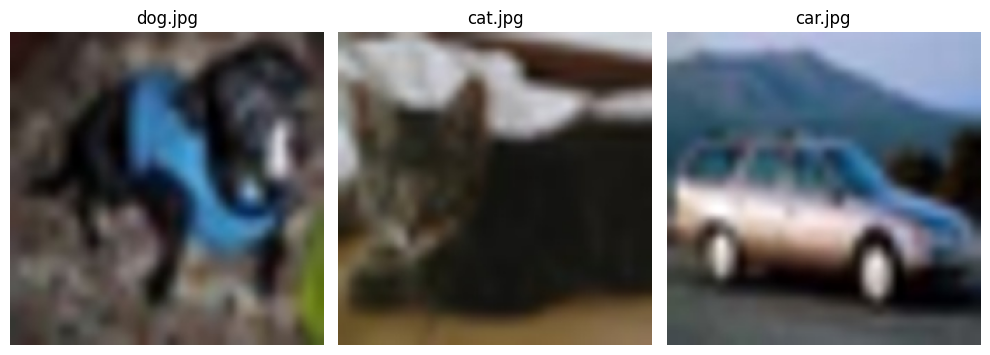

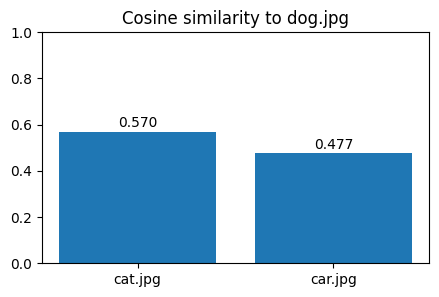

In [14]:
# ===============================================
# URL 없이 동작: CIFAR-10에서 dog/cat/car 추출 → ResNet50 임베딩 → 코사인 유사도
# ===============================================
import os, pathlib
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import cifar10

print("TensorFlow:", tf.__version__)


# 0) 저장 폴더
IMG_DIR = "sample_images"
os.makedirs(IMG_DIR, exist_ok=True)


# 1) CIFAR-10 로드 (자동 다운로드) — 클래스 라벨 매핑
# CIFAR-10 label names: 0 airplane, 1 automobile, 2 bird, 3 cat, 4 deer, 5 dog, 6 frog, 7 horse, 8 ship, 9 truck
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()

label_to_name = {
    1: "car",   # automobile
    3: "cat",
    5: "dog"
}

picked_paths = {}
for label, name in label_to_name.items():
    # 해당 클래스를 가진 첫 번째 이미지를 선택
    idx = np.where(y_train == label)[0][0]
    img_arr = x_train[idx]  # (32,32,3) uint8
    # 저장 파일명
    fname = f"{name}.jpg"
    fpath = os.path.join(IMG_DIR, fname)
    # 224x224로 업스케일 저장 (ResNet 입력 크기)
    Image.fromarray(img_arr).resize((224, 224), Image.BICUBIC).save(fpath, format="JPEG", quality=95)
    picked_paths[name] = fpath

print("저장된 파일:", picked_paths)


# 2) ResNet50 (ImageNet 사전학습, 분류헤드 제거)
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')  # (1, 2048) 임베딩

def get_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))   # 혹시 모를 크기 보정
    x = image.img_to_array(img)[None, ...]                   # (1,224,224,3)
    x = preprocess_input(x)
    emb = model.predict(x, verbose=0)                        # (1,2048)
    return emb


# 3) 임베딩 추출
image_files = [picked_paths["dog"], picked_paths["cat"], picked_paths["car"]]
embeddings = {p: get_embedding(p) for p in image_files}


# 4) 코사인 유사도 행렬
paths = list(embeddings.keys())
mat = np.vstack([embeddings[p] for p in paths])              # (N,2048)
sim = cosine_similarity(mat, mat)

df_sim = pd.DataFrame(sim,
                      index=[pathlib.Path(p).name for p in paths],
                      columns=[pathlib.Path(p).name for p in paths])
print("\n📊 전체 코사인 유사도 행렬")
try:
    display(df_sim.style.format("{:.4f}"))
except NameError:
    print(df_sim.round(4))



# 5) dog.jpg 기준 유사도 정렬
target_name = "dog.jpg"
target_path = os.path.join(IMG_DIR, target_name)
target_idx = paths.index(target_path)
scores = sim[target_idx]

ranked = sorted(
    [(pathlib.Path(p).name, float(scores[i])) for i, p in enumerate(paths) if i != target_idx],
    key=lambda x: x[1], reverse=True
)

print(f"\n✅ '{target_name}'와 유사도가 높은 순")
for name, s in ranked:
    print(f"  {name:10s} : {s:.4f}")



# 6) 미니 갤러리 시각화
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for ax, p in zip(axes, image_files):
    ax.imshow(Image.open(p))
    ax.set_title(pathlib.Path(p).name)
    ax.axis("off")
plt.tight_layout()
plt.show()



# 7) 바 차트
plt.figure(figsize=(5,3))
names = [n for n, _ in ranked]
vals  = [s for _, s in ranked]
plt.bar(names, vals)
plt.ylim(0, 1.0)
for i, v in enumerate(vals):
    plt.text(i, v+0.02, f"{v:.3f}", ha="center")
plt.title(f"Cosine similarity to {target_name}")
plt.show()


In [10]:
embedding

array([[0.35920855, 0.15306284, 0.14219038, ..., 0.06165188, 0.69734645,
        0.00387637]], shape=(1, 2048), dtype=float32)

🖼️ 이미지 임베딩 기본 개념 이해하기
📄 생성된 이미지들:
  이미지1: 빨간 사각형
  이미지2: 파란 원
  이미지3: 녹색 선들

🔢 특징 추출 과정:

  빨간 사각형:
    RGB 평균: R=63.8, G=0.0, B=0.0
    밝기: 19.0
    대비: 32.9
    에지 밀도: 0.0303

  파란 원:
    RGB 평균: R=0.0, G=0.0, B=49.6
    밝기: 5.6
    대비: 11.5
    에지 밀도: 0.0254

  녹색 선들:
    RGB 평균: R=0.0, G=91.6, B=0.0
    밝기: 53.9
    대비: 72.0
    에지 밀도: 0.2344

🔗 이미지 간 유사도 (코사인 유사도):
  빨간 사각형 - 파란 원: 0.1275
  빨간 사각형 - 녹색 선들: 0.3561
  파란 원 - 녹색 선들: 0.1718


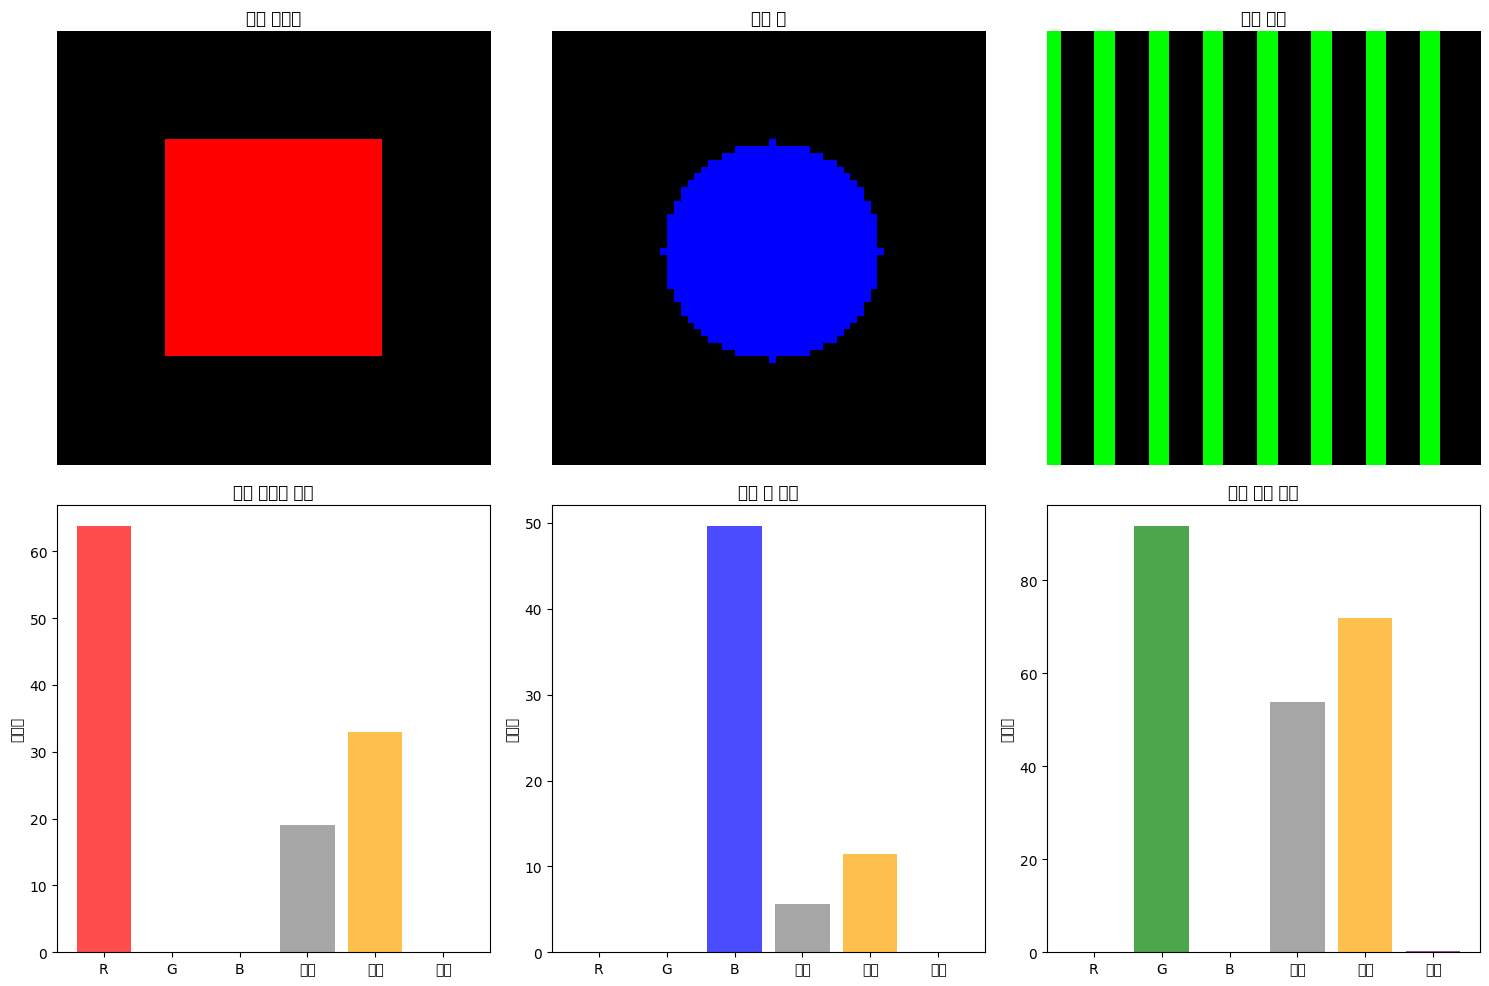

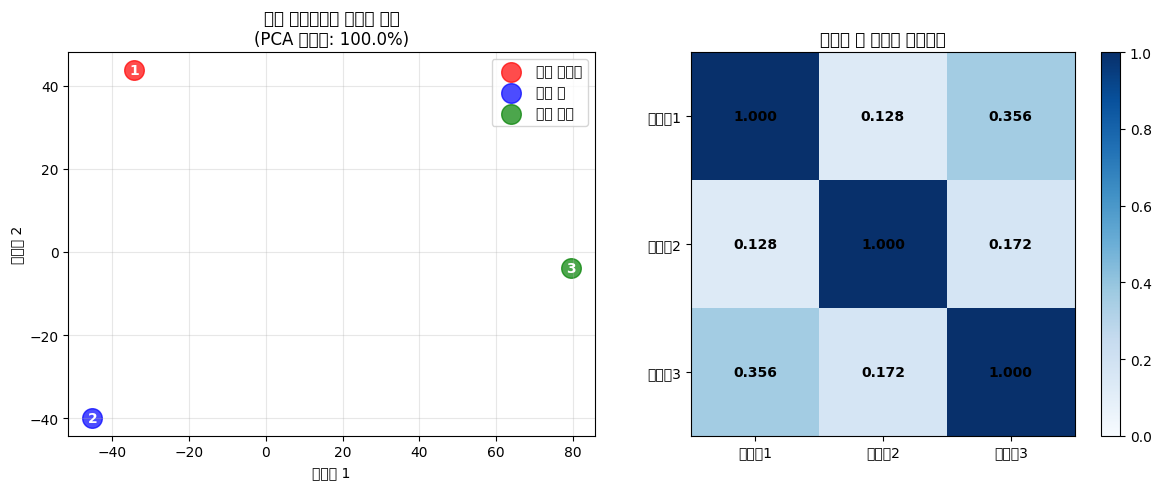


💡 이미지 임베딩 핵심 원리:
  ✅ 이미지를 수치 벡터로 변환
  ✅ 비슷한 이미지는 비슷한 벡터를 가짐
  ✅ 벡터 간 거리로 유사도 측정
  ✅ 특징 선택이 성능에 중요한 영향


(array([[6.37500000e+01, 0.00000000e+00, 0.00000000e+00, 1.90000000e+01,
         3.29089653e+01, 3.02734375e-02],
        [0.00000000e+00, 0.00000000e+00, 4.96179199e+01, 5.64282227e+00,
         1.14804356e+01, 2.53906250e-02],
        [0.00000000e+00, 9.16406250e+01, 0.00000000e+00, 5.39062500e+01,
         7.19725900e+01, 2.34375000e-01]]),
 ['빨간 사각형', '파란 원', '녹색 선들'])

In [11]:
# 이미지 임베딩 간단 테스트 - 바로 실행 가능
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumBarunGothic'


def simple_image_embedding_demo():
    """
    이미지 임베딩 기본 개념을 보여주는 간단한 예제
    """
    print("🖼️ 이미지 임베딩 기본 개념 이해하기")
    print("=" * 50)

    # 1단계: 간단한 이미지들 생성
    def create_simple_images():
        images = []
        labels = []

        # 빨간 사각형
        red_square = np.zeros((64, 64, 3), dtype=np.uint8)
        red_square[16:48, 16:48] = [0, 0, 255]  # BGR 형식
        images.append(red_square)
        labels.append('빨간 사각형')

        # 파란 원
        blue_circle = np.zeros((64, 64, 3), dtype=np.uint8)
        cv2.circle(blue_circle, (32, 32), 16, (255, 0, 0), -1)
        images.append(blue_circle)
        labels.append('파란 원')

        # 녹색 선
        green_lines = np.zeros((64, 64, 3), dtype=np.uint8)
        for i in range(0, 64, 8):
            cv2.line(green_lines, (i, 0), (i, 64), (0, 255, 0), 2)
        images.append(green_lines)
        labels.append('녹색 선들')

        return images, labels

    images, image_labels = create_simple_images()

    print("📄 생성된 이미지들:")
    for i, label in enumerate(image_labels):
        print(f"  이미지{i+1}: {label}")

    # 2단계: 간단한 특징 추출
    def extract_simple_features(image):
        """간단한 이미지 특징 추출"""
        # RGB 채널별 평균값
        b_mean = np.mean(image[:, :, 0])  # Blue
        g_mean = np.mean(image[:, :, 1])  # Green
        r_mean = np.mean(image[:, :, 2])  # Red

        # 그레이스케일로 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 기본 통계
        brightness = np.mean(gray)
        contrast = np.std(gray)

        # 에지 밀도 (간단한 버전)
        edges = cv2.Canny(gray, 50, 150)
        edge_density = np.sum(edges > 0) / edges.size

        # 특징 벡터 생성
        features = np.array([r_mean, g_mean, b_mean, brightness, contrast, edge_density])

        return features


    print(f"\n🔢 특징 추출 과정:")

    all_features = []
    for i, (image, label) in enumerate(zip(images, image_labels)):
        features = extract_simple_features(image)
        all_features.append(features)

        print(f"\n  {label}:")
        print(f"    RGB 평균: R={features[0]:.1f}, G={features[1]:.1f}, B={features[2]:.1f}")
        print(f"    밝기: {features[3]:.1f}")
        print(f"    대비: {features[4]:.1f}")
        print(f"    에지 밀도: {features[5]:.4f}")

    all_features = np.array(all_features)


    # 3단계: 유사도 계산
    print(f"\n🔗 이미지 간 유사도 (코사인 유사도):")

    similarity_matrix = cosine_similarity(all_features)

    for i in range(len(image_labels)):
        for j in range(i+1, len(image_labels)):
            sim = similarity_matrix[i][j]
            print(f"  {image_labels[i]} - {image_labels[j]}: {sim:.4f}")


    # 4단계: 시각화
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 원본 이미지들
    for i, (image, label) in enumerate(zip(images, image_labels)):
        # BGR을 RGB로 변환
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(rgb_image)
        axes[0, i].set_title(f'{label}')
        axes[0, i].axis('off')

    # 특징 벡터 시각화
    axes[1, 0].bar(['R', 'G', 'B', '밝기', '대비', '에지'], all_features[0],
                   color=['red', 'green', 'blue', 'gray', 'orange', 'purple'], alpha=0.7)
    axes[1, 0].set_title('빨간 사각형 특징')
    axes[1, 0].set_ylabel('특징값')

    axes[1, 1].bar(['R', 'G', 'B', '밝기', '대비', '에지'], all_features[1],
                   color=['red', 'green', 'blue', 'gray', 'orange', 'purple'], alpha=0.7)
    axes[1, 1].set_title('파란 원 특징')
    axes[1, 1].set_ylabel('특징값')

    axes[1, 2].bar(['R', 'G', 'B', '밝기', '대비', '에지'], all_features[2],
                   color=['red', 'green', 'blue', 'gray', 'orange', 'purple'], alpha=0.7)
    axes[1, 2].set_title('녹색 선들 특징')
    axes[1, 2].set_ylabel('특징값')

    plt.tight_layout()
    plt.show()


    # 5단계: 특징 공간에서 시각화
    plt.figure(figsize=(12, 5))

    # PCA로 2차원 축소
    if all_features.shape[1] > 2:
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(all_features)
        explained_variance = pca.explained_variance_ratio_.sum()
    else:
        features_2d = all_features[:, :2]
        explained_variance = 1.0

    plt.subplot(1, 2, 1)
    colors = ['red', 'blue', 'green']

    for i, (point, label, color) in enumerate(zip(features_2d, image_labels, colors)):
        plt.scatter(point[0], point[1], c=color, s=200, alpha=0.7, label=label)
        plt.annotate(f'{i+1}', (point[0], point[1]),
                    ha='center', va='center', fontweight='bold', color='white')

    plt.title(f'특징 공간에서의 이미지 위치\n(PCA 설명력: {explained_variance:.1%})')
    plt.xlabel('주성분 1')
    plt.ylabel('주성분 2')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 유사도 히트맵
    plt.subplot(1, 2, 2)
    im = plt.imshow(similarity_matrix, cmap='Blues', vmin=0, vmax=1)
    plt.colorbar(im)

    # 유사도 값 표시
    for i in range(len(image_labels)):
        for j in range(len(image_labels)):
            plt.text(j, i, f'{similarity_matrix[i, j]:.3f}',
                    ha='center', va='center', fontweight='bold')

    plt.title('이미지 간 유사도 매트릭스')
    plt.xticks(range(len(image_labels)), [f'이미지{i+1}' for i in range(len(image_labels))])
    plt.yticks(range(len(image_labels)), [f'이미지{i+1}' for i in range(len(image_labels))])

    plt.tight_layout()
    plt.show()

    print(f"\n💡 이미지 임베딩 핵심 원리:")
    print("  ✅ 이미지를 수치 벡터로 변환")
    print("  ✅ 비슷한 이미지는 비슷한 벡터를 가짐")
    print("  ✅ 벡터 간 거리로 유사도 측정")
    print("  ✅ 특징 선택이 성능에 중요한 영향")

    return all_features, image_labels


def practical_image_search_demo():
    """
    실용적인 이미지 검색 예제
    """
    print(f"\n" + "=" * 50)
    print("🔍 실용적 이미지 검색 시스템")
    print("=" * 50)

    # 이미지 데이터베이스 생성
    def create_image_db():
        db_images = []
        db_descriptions = []

        # 다양한 패턴의 이미지들
        patterns = [
            {'desc': '빨간_사각형', 'shape': 'rect', 'color': (0, 0, 255)},
            {'desc': '파란_사각형', 'shape': 'rect', 'color': (255, 0, 0)},
            {'desc': '녹색_원', 'shape': 'circle', 'color': (0, 255, 0)},
            {'desc': '노란_원', 'shape': 'circle', 'color': (0, 255, 255)},
            {'desc': '수직_선', 'shape': 'v_lines', 'color': (128, 128, 128)},
            {'desc': '수평_선', 'shape': 'h_lines', 'color': (128, 128, 128)},
            {'desc': '체크_패턴', 'shape': 'checker', 'color': (255, 255, 255)},
            {'desc': '대각_선', 'shape': 'diagonal', 'color': (0, 128, 255)}
        ]

        for pattern in patterns:
            img = np.zeros((64, 64, 3), dtype=np.uint8)

            if pattern['shape'] == 'rect':
                cv2.rectangle(img, (16, 16), (48, 48), pattern['color'], -1)
            elif pattern['shape'] == 'circle':
                cv2.circle(img, (32, 32), 16, pattern['color'], -1)
            elif pattern['shape'] == 'v_lines':
                for x in range(8, 64, 8):
                    cv2.line(img, (x, 0), (x, 64), pattern['color'], 2)
            elif pattern['shape'] == 'h_lines':
                for y in range(8, 64, 8):
                    cv2.line(img, (0, y), (64, y), pattern['color'], 2)
            elif pattern['shape'] == 'checker':
                for i in range(0, 64, 16):
                    for j in range(0, 64, 16):
                        if (i//16 + j//16) % 2 == 0:
                            img[i:i+16, j:j+16] = pattern['color']
            elif pattern['shape'] == 'diagonal':
                cv2.line(img, (0, 0), (64, 64), pattern['color'], 3)
                cv2.line(img, (0, 64), (64, 0), pattern['color'], 3)

            db_images.append(img)
            db_descriptions.append(pattern['desc'])

        return db_images, db_descriptions

    # 데이터베이스 생성
    db_images, db_descriptions = create_image_db()

    print(f"데이터베이스 크기: {len(db_images)}개 이미지")

    # 간단한 특징 추출 함수
    def extract_features(image):
        # RGB 평균
        r_mean = np.mean(image[:, :, 2])
        g_mean = np.mean(image[:, :, 1])
        b_mean = np.mean(image[:, :, 0])

        # 그레이스케일 변환 및 통계
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        brightness = np.mean(gray)
        contrast = np.std(gray)

        # 에지 특징
        edges = cv2.Canny(gray, 50, 150)
        edge_density = np.sum(edges > 0) / edges.size

        # 방향성 특징 (간단한 버전)
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        horizontal_edges = np.sum(np.abs(sobel_x)) / gray.size
        vertical_edges = np.sum(np.abs(sobel_y)) / gray.size

        return np.array([r_mean, g_mean, b_mean, brightness, contrast,
                        edge_density, horizontal_edges, vertical_edges])

    # 모든 DB 이미지의 특징 추출
    db_features = []
    for img in db_images:
        features = extract_features(img)
        db_features.append(features)
    db_features = np.array(db_features)

    # 쿼리 이미지 생성 (파란 원과 유사)
    query_img = np.zeros((64, 64, 3), dtype=np.uint8)
    cv2.circle(query_img, (32, 32), 14, (200, 50, 50), -1)  # 약간 다른 파란 원

    query_features = extract_features(query_img)

    # 유사도 계산
    similarities = cosine_similarity([query_features], db_features)[0]

    # 가장 유사한 이미지들 찾기
    top_indices = np.argsort(similarities)[::-1][:3]

    print(f"\n🎯 검색 결과:")
    print(f"쿼리: 파란색 원 (약간 다른 크기)")

    for i, idx in enumerate(top_indices):
        print(f"  {i+1}위: {db_descriptions[idx]} (유사도: {similarities[idx]:.4f})")

    # 시각화
    plt.figure(figsize=(12, 8))

    # 쿼리 이미지
    plt.subplot(2, 4, 1)
    query_rgb = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
    plt.imshow(query_rgb)
    plt.title('쿼리 이미지')
    plt.axis('off')

    # 검색 결과
    for i, idx in enumerate(top_indices):
        plt.subplot(2, 4, i+2)
        result_rgb = cv2.cvtColor(db_images[idx], cv2.COLOR_BGR2RGB)
        plt.imshow(result_rgb)
        plt.title(f'{i+1}위: {db_descriptions[idx]}\n유사도: {similarities[idx]:.3f}')
        plt.axis('off')

    # 전체 데이터베이스 (하위 4개)
    bottom_indices = np.argsort(similarities)[:4]
    for i, idx in enumerate(bottom_indices):
        plt.subplot(2, 4, i+5)
        img_rgb = cv2.cvtColor(db_images[idx], cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(f'{db_descriptions[idx]}\n유사도: {similarities[idx]:.3f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return db_features, similarities


def feature_importance_analysis():
    """
    특징의 중요도 분석
    """
    print(f"\n" + "=" * 50)
    print("📊 특징 중요도 분석")
    print("=" * 50)

    # 다양한 이미지 생성
    test_images = []
    image_types = []

    # 색상이 중요한 이미지들
    red_img = np.full((64, 64, 3), [0, 0, 255], dtype=np.uint8)
    blue_img = np.full((64, 64, 3), [255, 0, 0], dtype=np.uint8)

    # 형태가 중요한 이미지들
    circle_img = np.zeros((64, 64, 3), dtype=np.uint8)
    cv2.circle(circle_img, (32, 32), 20, (128, 128, 128), -1)

    square_img = np.zeros((64, 64, 3), dtype=np.uint8)
    cv2.rectangle(square_img, (12, 12), (52, 52), (128, 128, 128), -1)

    # 텍스처가 중요한 이미지들
    noise_img = np.random.randint(0, 256, (64, 64, 3), dtype=np.uint8)
    lines_img = np.zeros((64, 64, 3), dtype=np.uint8)
    for i in range(0, 64, 4):
        lines_img[i:i+2, :] = 200

    test_images = [red_img, blue_img, circle_img, square_img, noise_img, lines_img]
    image_types = ['빨간색', '파란색', '원', '사각형', '노이즈', '선 패턴']

    # 특징 추출
    def detailed_feature_extraction(image):
        # 색상 특징
        r_mean = np.mean(image[:, :, 2])
        g_mean = np.mean(image[:, :, 1])
        b_mean = np.mean(image[:, :, 0])

        # 형태 특징
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        edge_density = np.sum(edges > 0) / edges.size

        # 둘레 길이 추정 (간단한 방법)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        perimeter = sum(cv2.arcLength(c, True) for c in contours)

        # 텍스처 특징
        brightness = np.mean(gray)
        contrast = np.std(gray)

        # 지역적 변화량
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        texture_variation = np.var(laplacian)

        return {
            '빨간색': r_mean,
            '녹색': g_mean,
            '파란색': b_mean,
            '에지밀도': edge_density,
            '둘레': perimeter / 1000,  # 스케일 조정
            '밝기': brightness,
            '대비': contrast,
            '텍스처변화': texture_variation / 1000  # 스케일 조정
        }

    # 모든 이미지의 특징 추출
    all_features = []
    feature_names = None

    for img in test_images:
        features_dict = detailed_feature_extraction(img)
        if feature_names is None:
            feature_names = list(features_dict.keys())
        all_features.append(list(features_dict.values()))

    all_features = np.array(all_features)

    print(f"추출된 특징들: {feature_names}")

    # 특징별 분석
    plt.figure(figsize=(15, 10))

    # 각 이미지 표시
    for i, (img, img_type) in enumerate(zip(test_images, image_types)):
        plt.subplot(3, 6, i+1)
        if img_type in ['노이즈']:
            plt.imshow(img)
        else:
            rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(rgb_img)
        plt.title(img_type)
        plt.axis('off')

    # 특징별 히트맵
    plt.subplot(3, 2, 3)
    normalized_features = (all_features - all_features.min(axis=0)) / (all_features.max(axis=0) - all_features.min(axis=0) + 1e-7)

    im = plt.imshow(normalized_features.T, cmap='RdYlBu_r', aspect='auto')
    plt.colorbar(im)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.xticks(range(len(image_types)), image_types, rotation=45)
    plt.title('정규화된 특징 히트맵')

    # 각 특징별 분포
    plt.subplot(3, 2, 4)
    feature_variances = np.var(normalized_features, axis=0)
    bars = plt.bar(range(len(feature_names)), feature_variances,
                   color=['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray'])
    plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')


# 이미지 임베딩 기본 개념 시각화
simple_image_embedding_demo()



🔍 실용적 이미지 검색 시스템
데이터베이스 크기: 8개 이미지

🎯 검색 결과:
쿼리: 파란색 원 (약간 다른 크기)
  1위: 체크_패턴 (유사도: 0.8608)
  2위: 파란_사각형 (유사도: 0.8383)
  3위: 노란_원 (유사도: 0.6889)


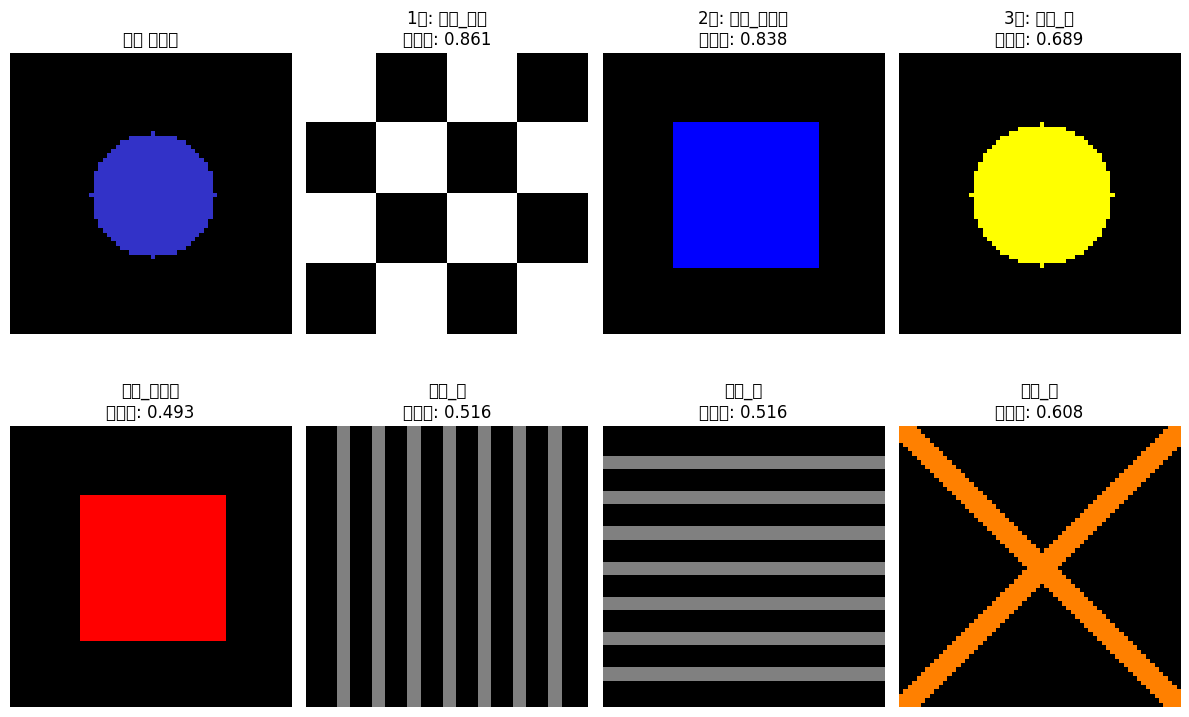

(array([[6.77966309e+01, 0.00000000e+00, 0.00000000e+00, 2.02060547e+01,
         3.35764130e+01, 3.12500000e-02, 9.79687500e+00, 9.79687500e+00],
        [0.00000000e+00, 0.00000000e+00, 6.77966309e+01, 7.71020508e+00,
         1.28120523e+01, 3.12500000e-02, 3.73828125e+00, 3.73828125e+00],
        [0.00000000e+00, 4.96179199e+01, 0.00000000e+00, 2.91870117e+01,
         5.93815637e+01, 2.53906250e-02, 1.87500000e+01, 1.87500000e+01],
        [4.96179199e+01, 4.96179199e+01, 0.00000000e+00, 4.39750977e+01,
         8.94682226e+01, 2.53906250e-02, 2.82500000e+01, 2.82500000e+01],
        [4.20000000e+01, 4.20000000e+01, 4.20000000e+01, 4.20000000e+01,
         6.00999168e+01, 2.18750000e-01, 2.24000000e+02, 0.00000000e+00],
        [4.20000000e+01, 4.20000000e+01, 4.20000000e+01, 4.20000000e+01,
         6.00999168e+01, 2.18750000e-01, 0.00000000e+00, 2.24000000e+02],
        [1.27500000e+02, 1.27500000e+02, 1.27500000e+02, 1.27500000e+02,
         1.27500000e+02, 8.49609375e-02, 9.11

In [ ]:










# 실용적인 이미지 검색 예제
practical_image_search_demo()




---




📊 특징 중요도 분석
추출된 특징들: ['빨간색', '녹색', '파란색', '에지밀도', '둘레', '밝기', '대비', '텍스처변화']


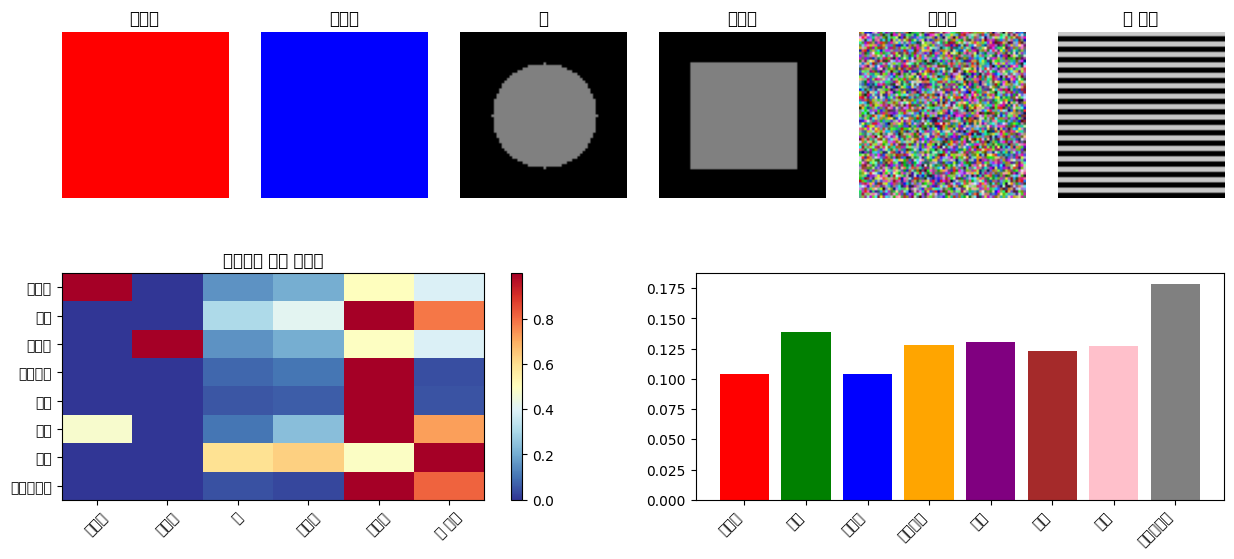

In [ ]:
# 이미지 특징의 중요도 분석
feature_importance_analysis()


---



### **예제 : 허깅페이스 한국어 임베딩 모델 활용**

#### **기본 예제**

In [15]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from typing import List, Dict
import warnings
warnings.filterwarnings('ignore')

class KoreanEmbeddingSystem:
    def __init__(self, model_name='jhgan/ko-sroberta-multitask'):
        """
        한국어 임베딩 시스템 초기화

        추천 모델들:
        - 'jhgan/ko-sroberta-multitask': 한국어 Sentence-RoBERTa (문장 임베딩 특화)
        - 'BM-K/KoSimCSE-roberta-multitask': KoSimCSE (의미 유사도 특화)
        - 'klue/roberta-base': KLUE RoBERTa (범용)
        - 'monologg/kobert': KoBERT (SKT)
        """
        print(f"✅ 모델 로딩 중: {model_name}")

        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        print(f"\n✅ 모델 로딩 완료! 디바이스: {self.device}")

    def encode_sentences(self, sentences: List[str], max_length: int = 512) -> np.ndarray:
        """문장들을 벡터로 인코딩"""
        embeddings = []

        self.model.eval()
        with torch.no_grad():
            for sentence in sentences:
                # 토큰화
                inputs = self.tokenizer(
                    sentence,
                    padding=True,
                    truncation=True,
                    max_length=max_length,
                    return_tensors='pt'
                ).to(self.device)

                # 임베딩 생성
                outputs = self.model(**inputs)

                # [CLS] 토큰의 임베딩을 문장 임베딩으로 사용
                # 또는 평균 풀링 사용
                if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
                    embedding = outputs.pooler_output
                else:
                    # 평균 풀링
                    embedding = outputs.last_hidden_state.mean(dim=1)

                embeddings.append(embedding.cpu().numpy())

        return np.vstack(embeddings)

    def calculate_similarity(self, sentences1: List[str], sentences2: List[str] = None) -> np.ndarray:
        """문장들 간의 코사인 유사도 계산"""
        embeddings1 = self.encode_sentences(sentences1)

        if sentences2 is None:
            # 자기 자신과의 유사도 매트릭스
            similarity_matrix = cosine_similarity(embeddings1)
        else:
            # 두 그룹 간의 유사도
            embeddings2 = self.encode_sentences(sentences2)
            similarity_matrix = cosine_similarity(embeddings1, embeddings2)

        return similarity_matrix

    def find_most_similar(self, query: str, candidates: List[str], top_k: int = 5) -> List[Dict]:
        """질의문과 가장 유사한 문장들 찾기"""
        all_sentences = [query] + candidates
        embeddings = self.encode_sentences(all_sentences)

        query_embedding = embeddings[0:1]
        candidate_embeddings = embeddings[1:]

        similarities = cosine_similarity(query_embedding, candidate_embeddings)[0]

        # 상위 k개 결과
        top_indices = similarities.argsort()[-top_k:][::-1]

        results = []
        for i, idx in enumerate(top_indices):
            results.append({
                'rank': i + 1,
                'sentence': candidates[idx],
                'similarity': similarities[idx]
            })

        return results

# 메인 실행 함수
def main():
    print("\n=== 한국어 임베딩 모델 활용 시스템 ===\n")

    # 시스템 초기화 (여러 모델 중 선택 가능)
    embedding_system = KoreanEmbeddingSystem('jhgan/ko-sroberta-multitask')

    # 테스트 문장들
    korean_sentences = [
        "오늘 날씨가 정말 좋습니다.",
        "날씨가 매우 화창하네요.",
        "비가 많이 내리고 있어요.",
        "인공지능 기술이 빠르게 발전하고 있다.",
        "머신러닝은 컴퓨터가 데이터로부터 학습하는 기술이다.",
        "점심에 뭘 먹을지 고민이에요.",
        "오늘 저녁 메뉴를 정해야겠어요.",
        "주식 시장이 불안정합니다.",
        "경제 상황이 좋지 않아 보입니다."
    ]

    print("\n✅ 테스트 문장들:")
    for i, sentence in enumerate(korean_sentences, 1):
        print(f"{i}. {sentence}")

    print(f"\n✅ 총 {len(korean_sentences)}개 문장의 임베딩을 생성합니다...")

    # 1. 문장 임베딩 생성
    embeddings = embedding_system.encode_sentences(korean_sentences)
    print(f"임베딩 shape: {embeddings.shape}")
    print(f"각 문장은 {embeddings.shape[1]}차원 벡터로 표현됩니다.")

    # 2. 유사도 매트릭스 계산
    print("\n✅ === 문장 간 유사도 분석 ===")
    similarity_matrix = embedding_system.calculate_similarity(korean_sentences)

    # 유사도가 높은 문장 쌍 찾기
    print("\n가장 유사한 문장 쌍들 (Top 5):")
    similar_pairs = []

    for i in range(len(korean_sentences)):
        for j in range(i+1, len(korean_sentences)):
            similarity = similarity_matrix[i][j]
            similar_pairs.append({
                'sentence1': korean_sentences[i],
                'sentence2': korean_sentences[j],
                'similarity': similarity
            })

    # 유사도 순으로 정렬
    similar_pairs.sort(key=lambda x: x['similarity'], reverse=True)

    for i, pair in enumerate(similar_pairs[:5], 1):
        print(f"{i}. 유사도: {pair['similarity']:.4f}")
        print(f"   문장1: {pair['sentence1']}")
        print(f"   문장2: {pair['sentence2']}")
        print()

    # 3. 질의 기반 유사 문장 검색
    print("\n✅ === 질의 기반 문장 검색 ===")
    query = "날씨에 관한 이야기"
    print(f"질의: '{query}'")

    results = embedding_system.find_most_similar(query, korean_sentences, top_k=3)

    print(f"\n'{query}'와 가장 유사한 문장들:")
    for result in results:
        print(f"{result['rank']}위. {result['sentence']} (유사도: {result['similarity']:.4f})")

if __name__ == "__main__":
    main()


=== 한국어 임베딩 모델 활용 시스템 ===

✅ 모델 로딩 중: jhgan/ko-sroberta-multitask


tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]


✅ 모델 로딩 완료! 디바이스: cuda

✅ 테스트 문장들:
1. 오늘 날씨가 정말 좋습니다.
2. 날씨가 매우 화창하네요.
3. 비가 많이 내리고 있어요.
4. 인공지능 기술이 빠르게 발전하고 있다.
5. 머신러닝은 컴퓨터가 데이터로부터 학습하는 기술이다.
6. 점심에 뭘 먹을지 고민이에요.
7. 오늘 저녁 메뉴를 정해야겠어요.
8. 주식 시장이 불안정합니다.
9. 경제 상황이 좋지 않아 보입니다.

✅ 총 9개 문장의 임베딩을 생성합니다...


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

임베딩 shape: (9, 768)
각 문장은 768차원 벡터로 표현됩니다.

✅ === 문장 간 유사도 분석 ===

가장 유사한 문장 쌍들 (Top 5):
1. 유사도: 0.8796
   문장1: 오늘 날씨가 정말 좋습니다.
   문장2: 날씨가 매우 화창하네요.

2. 유사도: 0.6551
   문장1: 인공지능 기술이 빠르게 발전하고 있다.
   문장2: 머신러닝은 컴퓨터가 데이터로부터 학습하는 기술이다.

3. 유사도: 0.6229
   문장1: 점심에 뭘 먹을지 고민이에요.
   문장2: 오늘 저녁 메뉴를 정해야겠어요.

4. 유사도: 0.5598
   문장1: 오늘 날씨가 정말 좋습니다.
   문장2: 비가 많이 내리고 있어요.

5. 유사도: 0.5512
   문장1: 주식 시장이 불안정합니다.
   문장2: 경제 상황이 좋지 않아 보입니다.


✅ === 질의 기반 문장 검색 ===
질의: '날씨에 관한 이야기'

'날씨에 관한 이야기'와 가장 유사한 문장들:
1위. 오늘 날씨가 정말 좋습니다. (유사도: 0.7897)
2위. 날씨가 매우 화창하네요. (유사도: 0.7036)
3위. 비가 많이 내리고 있어요. (유사도: 0.6368)


#### **모델 성능 비교**

In [16]:
def compare_korean_models():
    """여러 한국어 모델 성능 비교"""
    print("=== 한국어 모델 성능 비교 ===")

    models = [
        'jhgan/ko-sroberta-multitask',
        'BM-K/KoSimCSE-roberta-multitask',
        'klue/roberta-base'
    ]

    test_sentences = [
        "한국어 자연어처리는 어려운 분야입니다.",
        "자연어처리 기술은 복잡한 영역이에요.",
        "오늘은 비가 와서 우울해요.",
        "날씨가 흐려서 기분이 안 좋네요."
    ]

    results = {}

    for model_name in models:
        try:
            print(f"\n{model_name} 테스트 중...")
            system = KoreanEmbeddingSystem(model_name)

            # 유사도 계산
            similarity_matrix = system.calculate_similarity(test_sentences)

            # 관련 문장 쌍의 유사도 측정
            related_similarity = (similarity_matrix[0][1] + similarity_matrix[2][3]) / 2
            unrelated_similarity = (similarity_matrix[0][2] + similarity_matrix[1][3]) / 2

            results[model_name] = {
                'related_similarity': related_similarity,
                'unrelated_similarity': unrelated_similarity,
                'discrimination': related_similarity - unrelated_similarity
            }

            print(f"관련 문장 유사도: {related_similarity:.4f}")
            print(f"무관한 문장 유사도: {unrelated_similarity:.4f}")
            print(f"구분력: {results[model_name]['discrimination']:.4f}")

        except Exception as e:
            print(f"오류 발생: {e}")

    # 결과 정리
    print("\n=== 모델 성능 요약 ===")
    for model, metrics in results.items():
        print(f"{model.split('/')[-1]}: 구분력 {metrics['discrimination']:.4f}")

# 예제 실행
compare_korean_models()

=== 한국어 모델 성능 비교 ===

jhgan/ko-sroberta-multitask 테스트 중...
✅ 모델 로딩 중: jhgan/ko-sroberta-multitask

✅ 모델 로딩 완료! 디바이스: cuda
관련 문장 유사도: 0.7865
무관한 문장 유사도: 0.3015
구분력: 0.4850

BM-K/KoSimCSE-roberta-multitask 테스트 중...
✅ 모델 로딩 중: BM-K/KoSimCSE-roberta-multitask


tokenizer_config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/764 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]


✅ 모델 로딩 완료! 디바이스: cuda
관련 문장 유사도: 0.7648
무관한 문장 유사도: 0.0936
구분력: 0.6712

klue/roberta-base 테스트 중...
✅ 모델 로딩 중: klue/roberta-base


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ 모델 로딩 완료! 디바이스: cuda
관련 문장 유사도: 0.9983
무관한 문장 유사도: 0.9945
구분력: 0.0039

=== 모델 성능 요약 ===
ko-sroberta-multitask: 구분력 0.4850
KoSimCSE-roberta-multitask: 구분력 0.6712
roberta-base: 구분력 0.0039


#### **한국어 감정 분석 임베딩**

In [17]:
def analyze_korean_emotions():
    """한국어 감정 표현 분석"""
    print("=== 한국어 감정 표현 분석 ===")

    system = KoreanEmbeddingSystem('jhgan/ko-sroberta-multitask')

    emotion_sentences = {
        '기쁨': [
            "오늘 정말 행복한 하루였어요!",
            "좋은 소식을 들어서 기분이 날아갈 것 같아요.",
            "드디어 꿈꾸던 일이 이루어졌습니다!"
        ],
        '슬픔': [
            "오늘 너무 우울하고 슬펐어요.",
            "힘든 일이 있어서 마음이 아픕니다.",
            "이별의 아픔이 너무 커요."
        ],
        '분노': [
            "정말 화가 나서 참을 수 없어요!",
            "이런 일이 있을 수 있나요? 너무 억울해요.",
            "분통이 터질 것 같습니다."
        ],
        '놀라움': [
            "이런 일이! 정말 놀랍네요.",
            "깜짝 놀랐어요. 예상치 못한 일이에요.",
            "믿을 수 없어요. 너무 신기합니다."
        ]
    }

    # 각 감정별 대표 임베딩 계산
    emotion_embeddings = {}
    all_sentences = []
    emotion_labels = []

    for emotion, sentences in emotion_sentences.items():
        embeddings = system.encode_sentences(sentences)
        emotion_embeddings[emotion] = np.mean(embeddings, axis=0)
        all_sentences.extend(sentences)
        emotion_labels.extend([emotion] * len(sentences))

    # 새로운 문장의 감정 예측
    test_sentences = [
        "시험에 합격해서 너무 기뻐요!",
        "친구와 싸워서 마음이 아파요.",
        "갑자기 비가 와서 당황스러워요."
    ]

    print("감정 예측 결과:")
    for test_sentence in test_sentences:
        test_embedding = system.encode_sentences([test_sentence])[0]

        similarities = {}
        for emotion, emotion_emb in emotion_embeddings.items():
            similarity = cosine_similarity([test_embedding], [emotion_emb])[0][0]
            similarities[emotion] = similarity

        predicted_emotion = max(similarities, key=similarities.get)
        confidence = similarities[predicted_emotion]

        print(f"\n문장: '{test_sentence}'")
        print(f"예측 감정: {predicted_emotion} (신뢰도: {confidence:.4f})")

        # 모든 감정별 점수
        print("감정별 유사도:")
        for emotion, score in sorted(similarities.items(), key=lambda x: x[1], reverse=True):
            print(f"  {emotion}: {score:.4f}")

# 예제 실행
analyze_korean_emotions()

=== 한국어 감정 표현 분석 ===
✅ 모델 로딩 중: jhgan/ko-sroberta-multitask

✅ 모델 로딩 완료! 디바이스: cuda
감정 예측 결과:

문장: '시험에 합격해서 너무 기뻐요!'
예측 감정: 기쁨 (신뢰도: 0.5657)
감정별 유사도:
  기쁨: 0.5657
  놀라움: 0.4973
  분노: 0.4345
  슬픔: 0.4131

문장: '친구와 싸워서 마음이 아파요.'
예측 감정: 슬픔 (신뢰도: 0.6259)
감정별 유사도:
  슬픔: 0.6259
  분노: 0.5786
  놀라움: 0.4260
  기쁨: 0.4019

문장: '갑자기 비가 와서 당황스러워요.'
예측 감정: 놀라움 (신뢰도: 0.5516)
감정별 유사도:
  놀라움: 0.5516
  슬픔: 0.5250
  기쁨: 0.5082
  분노: 0.5066


#### **한국어 문서 클러스터링**

=== 한국어 문서 클러스터링 ===
✅ 모델 로딩 중: jhgan/ko-sroberta-multitask

✅ 모델 로딩 완료! 디바이스: cuda
4개 클러스터로 분류 결과:

클러스터 1:
  - 김치찌개는 한국의 대표적인 음식입니다.
  - 불고기를 만들 때는 양념이 중요해요.
  - 비빔밥에는 다양한 나물이 들어갑니다.

클러스터 2:
  - 제주도는 아름다운 자연경관을 자랑합니다.
  - 부산의 해운대 바다는 정말 멋져요.
  - 오늘은 맑고 화창한 날씨입니다.
  - 비가 와서 습도가 높아졌어요.

클러스터 3:
  - 인공지능과 머신러닝 기술이 빠르게 발전하고 있습니다.
  - 딥러닝 알고리즘은 복잡한 패턴을 학습할 수 있습니다.
  - 자연어처리 기술로 텍스트를 분석할 수 있습니다.
  - 경주에는 많은 역사적 유적이 있습니다.

클러스터 4:
  - 겨울이라 날씨가 매우 춥습니다.


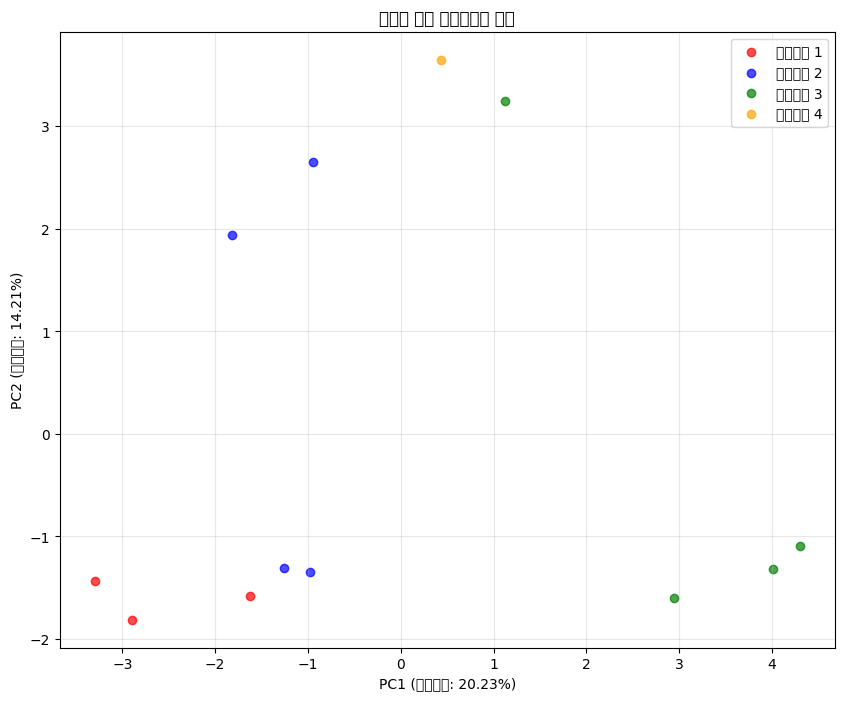

In [18]:
def cluster_korean_documents():
    """한국어 문서 클러스터링"""
    print("=== 한국어 문서 클러스터링 ===")

    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    system = KoreanEmbeddingSystem('jhgan/ko-sroberta-multitask')

    # 다양한 주제의 한국어 문서
    documents = [
        # 기술 관련
        "인공지능과 머신러닝 기술이 빠르게 발전하고 있습니다.",
        "딥러닝 알고리즘은 복잡한 패턴을 학습할 수 있습니다.",
        "자연어처리 기술로 텍스트를 분석할 수 있습니다.",

        # 요리 관련
        "김치찌개는 한국의 대표적인 음식입니다.",
        "불고기를 만들 때는 양념이 중요해요.",
        "비빔밥에는 다양한 나물이 들어갑니다.",

        # 여행 관련
        "제주도는 아름다운 자연경관을 자랑합니다.",
        "부산의 해운대 바다는 정말 멋져요.",
        "경주에는 많은 역사적 유적이 있습니다.",

        # 날씨 관련
        "오늘은 맑고 화창한 날씨입니다.",
        "비가 와서 습도가 높아졌어요.",
        "겨울이라 날씨가 매우 춥습니다."
    ]

    # 문서 임베딩 생성
    embeddings = system.encode_sentences(documents)

    # K-means 클러스터링
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # 결과 출력
    print(f"{n_clusters}개 클러스터로 분류 결과:")
    for i in range(n_clusters):
        print(f"\n클러스터 {i+1}:")
        cluster_docs = [documents[j] for j, label in enumerate(cluster_labels) if label == i]
        for doc in cluster_docs:
            print(f"  - {doc}")

    # 시각화 (PCA로 2D 축소)
    try:
        plt.figure(figsize=(10, 8))
        plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트

        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)

        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for i in range(n_clusters):
            mask = cluster_labels == i
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                       c=colors[i], label=f'클러스터 {i+1}', alpha=0.7)

        plt.title('한국어 문서 클러스터링 결과')
        plt.xlabel(f'PC1 (설명변량: {pca.explained_variance_ratio_[0]:.2%})')
        plt.ylabel(f'PC2 (설명변량: {pca.explained_variance_ratio_[1]:.2%})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    except Exception as e:
        print(f"시각화 오류: {e}")
        print("matplotlib 한글 폰트 설정이 필요할 수 있습니다.")

# 예제 실행
cluster_korean_documents()

### **예제: 멀티모달 임베딩**

In [19]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoProcessor, AutoModel,
    BlipProcessor, BlipModel,
    AutoTokenizer
)
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

class MultimodalEmbeddingSystem:
    def __init__(self, model_type='clip'):
        """
        멀티모달 임베딩 시스템 초기화

        지원 모델들:
        - 'clip': OpenAI CLIP (기본)
        - 'korean-clip': 한국어 CLIP
        - 'siglip': Google SigLIP
        - 'blip': BLIP (Salesforce)
        """
        self.model_type = model_type
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        print(f"멀티모달 모델 로딩 중: {model_type}")
        self._load_model()
        print(f"✅ 모델 로딩 완료! 디바이스: {self.device}")

    def _load_model(self):
        """모델별 로딩"""
        if self.model_type == 'clip':
            model_name = "openai/clip-vit-base-patch32"
            self.processor = CLIPProcessor.from_pretrained(model_name)
            self.model = CLIPModel.from_pretrained(model_name)

        elif self.model_type == 'korean-clip':
            # 한국어 CLIP 모델 (예시)
            model_name = "Bingsu/clip-vit-base-patch32-ko"
            self.processor = CLIPProcessor.from_pretrained(model_name)
            self.model = CLIPModel.from_pretrained(model_name)

        elif self.model_type == 'siglip':
            model_name = "google/siglip-base-patch16-224"
            self.processor = AutoProcessor.from_pretrained(model_name)
            self.model = AutoModel.from_pretrained(model_name)

        elif self.model_type == 'blip':
            model_name = "Salesforce/blip-image-captioning-base"
            self.processor = BlipProcessor.from_pretrained(model_name)
            self.model = BlipModel.from_pretrained(model_name)

        self.model.to(self.device)
        self.model.eval()

    def encode_text(self, texts):
        """텍스트를 벡터로 인코딩"""
        if isinstance(texts, str):
            texts = [texts]

        with torch.no_grad():
            if self.model_type in ['clip', 'korean-clip']:
                inputs = self.processor(text=texts, return_tensors="pt", padding=True, truncation=True)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                text_features = self.model.get_text_features(**inputs)
                text_features = F.normalize(text_features, p=2, dim=1)

            elif self.model_type == 'siglip':
                inputs = self.processor(text=texts, return_tensors="pt", padding=True, truncation=True)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                outputs = self.model.get_text_features(**inputs)
                text_features = F.normalize(outputs, p=2, dim=1)

            elif self.model_type == 'blip':
                inputs = self.processor(text=texts, return_tensors="pt", padding=True, truncation=True)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                text_features = self.model.get_text_features(**inputs)
                text_features = F.normalize(text_features, p=2, dim=1)

        return text_features.cpu().numpy()

    def encode_image(self, images):
        """이미지를 벡터로 인코딩"""
        if not isinstance(images, list):
            images = [images]

        with torch.no_grad():
            if self.model_type in ['clip', 'korean-clip']:
                inputs = self.processor(images=images, return_tensors="pt", padding=True)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                image_features = self.model.get_image_features(**inputs)
                image_features = F.normalize(image_features, p=2, dim=1)

            elif self.model_type == 'siglip':
                inputs = self.processor(images=images, return_tensors="pt", padding=True)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                outputs = self.model.get_image_features(**inputs)
                image_features = F.normalize(outputs, p=2, dim=1)

            elif self.model_type == 'blip':
                inputs = self.processor(images=images, return_tensors="pt", padding=True)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                image_features = self.model.get_image_features(**inputs)
                image_features = F.normalize(image_features, p=2, dim=1)

        return image_features.cpu().numpy()

    def calculate_similarity(self, embeddings1, embeddings2=None):
        """임베딩 간 코사인 유사도 계산"""
        if embeddings2 is None:
            return cosine_similarity(embeddings1)
        else:
            return cosine_similarity(embeddings1, embeddings2)

    def text_image_similarity(self, texts, images):
        """텍스트와 이미지 간 유사도 계산"""
        text_embeddings = self.encode_text(texts)
        image_embeddings = self.encode_image(images)

        similarity_matrix = self.calculate_similarity(text_embeddings, image_embeddings)
        return similarity_matrix

    def cross_modal_search(self, query, candidates, query_type='text', candidate_type='image', top_k=5):
        """교차 모달 검색"""
        if query_type == 'text':
            query_embedding = self.encode_text([query])
        else:
            query_embedding = self.encode_image([query])

        if candidate_type == 'text':
            candidate_embeddings = self.encode_text(candidates)
        else:
            candidate_embeddings = self.encode_image(candidates)

        similarities = cosine_similarity(query_embedding, candidate_embeddings)[0]
        top_indices = similarities.argsort()[-top_k:][::-1]

        results = []
        for i, idx in enumerate(top_indices):
            results.append({
                'rank': i + 1,
                'candidate': candidates[idx] if candidate_type == 'text' else f"Image_{idx}",
                'similarity': similarities[idx]
            })

        return results

# 이미지 다운로드 유틸리티
def download_image(url):
    """URL에서 이미지 다운로드"""
    try:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        return image
    except Exception as e:
        print(f"이미지 다운로드 실패: {e}")
        return None

def create_sample_images():
    """샘플 이미지 URL 목록"""
    return {
        'cat': 'https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400',
        'dog': 'https://images.unsplash.com/photo-1552053831-71594a27632d?w=400',
        'car': 'https://images.unsplash.com/photo-1549924231-f129b911e442?w=400',
        'flower': 'https://images.unsplash.com/photo-1441974231531-c6227db76b6e?w=400',
        'mountain': 'https://images.unsplash.com/photo-1506905925346-21bda4d32df4?w=400'
    }

# 메인 실행 함수
def main():
    print("=== 멀티모달 통합 임베딩 시스템 ===\n")

    # 시스템 초기화
    embedding_system = MultimodalEmbeddingSystem('clip')

    # 샘플 텍스트
    sample_texts = [
        "a cute cat sitting on a chair",
        "a happy dog running in the park",
        "a red sports car on the road",
        "beautiful flowers in the garden",
        "snow-covered mountain peaks"
    ]

    print("샘플 텍스트:")
    for i, text in enumerate(sample_texts, 1):
        print(f"{i}. {text}")

    # 샘플 이미지 다운로드
    print("\n샘플 이미지 다운로드 중...")
    image_urls = create_sample_images()
    sample_images = []
    image_names = []

    for name, url in image_urls.items():
        image = download_image(url)
        if image:
            sample_images.append(image)
            image_names.append(name)
            print(f"✓ {name} 이미지 로드 완료")

    if not sample_images:
        print("이미지 로드 실패. 로컬 이미지를 사용하거나 URL을 확인해주세요.")
        return

    # 1. 텍스트 임베딩 생성
    print(f"\n=== 텍스트 임베딩 생성 ===")
    text_embeddings = embedding_system.encode_text(sample_texts)
    print(f"텍스트 임베딩 shape: {text_embeddings.shape}")

    # 2. 이미지 임베딩 생성
    print(f"\n=== 이미지 임베딩 생성 ===")
    image_embeddings = embedding_system.encode_image(sample_images)
    print(f"이미지 임베딩 shape: {image_embeddings.shape}")

    # 3. 교차 모달 유사도 계산
    print(f"\n=== 텍스트-이미지 교차 모달 유사도 ===")
    cross_modal_similarity = embedding_system.text_image_similarity(sample_texts, sample_images)

    print("텍스트 → 이미지 유사도 매트릭스:")
    print("텍스트 \\ 이미지", end="")
    for name in image_names:
        print(f"\t{name[:8]}", end="")
    print()

    for i, text in enumerate(sample_texts):
        print(f"{text[:20]}...", end="")
        for j in range(len(sample_images)):
            print(f"\t{cross_modal_similarity[i][j]:.3f}", end="")
        print()

    # 4. 텍스트로 이미지 검색
    print(f"\n=== 텍스트 쿼리로 이미지 검색 ===")
    text_query = "cute animal pet"

    results = embedding_system.cross_modal_search(
        query=text_query,
        candidates=image_names,  # 실제로는 이미지 객체를 사용
        query_type='text',
        candidate_type='text',  # 결과 표시용으로 이름 사용
        top_k=3
    )

    print(f"검색어: '{text_query}'")
    for result in results:
        print(f"{result['rank']}. {result['candidate']} (유사도: {result['similarity']:.4f})")

if __name__ == "__main__":
    main()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


=== 멀티모달 통합 임베딩 시스템 ===

멀티모달 모델 로딩 중: clip


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

✅ 모델 로딩 완료! 디바이스: cuda
샘플 텍스트:
1. a cute cat sitting on a chair
2. a happy dog running in the park
3. a red sports car on the road
4. beautiful flowers in the garden
5. snow-covered mountain peaks

샘플 이미지 다운로드 중...


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

✓ cat 이미지 로드 완료
✓ dog 이미지 로드 완료
✓ car 이미지 로드 완료
✓ flower 이미지 로드 완료
✓ mountain 이미지 로드 완료

=== 텍스트 임베딩 생성 ===
텍스트 임베딩 shape: (5, 512)

=== 이미지 임베딩 생성 ===
이미지 임베딩 shape: (5, 512)

=== 텍스트-이미지 교차 모달 유사도 ===
텍스트 → 이미지 유사도 매트릭스:
텍스트 \ 이미지	cat	dog	car	flower	mountain
a cute cat sitting o...	0.289	0.192	0.110	0.110	0.126
a happy dog running ...	0.136	0.238	0.123	0.174	0.134
a red sports car on ...	0.160	0.139	0.203	0.176	0.142
beautiful flowers in...	0.146	0.223	0.130	0.155	0.138
snow-covered mountai...	0.179	0.140	0.141	0.171	0.279

=== 텍스트 쿼리로 이미지 검색 ===
검색어: 'cute animal pet'
1. dog (유사도: 0.8523)
2. cat (유사도: 0.8359)
3. mountain (유사도: 0.8210)


#### **사진에 맞는 텍스트 선택하기**

- image : 강아지 사진
- texts = ["a photo of a cat", "a photo of a dog", "a photo of a car"]

In [20]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import torch

# 1. 모델 로드
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 2. 샘플 데이터
url = "https://images.unsplash.com/photo-1552053831-71594a27632d?w=400"  # 강아지 사진
image = Image.open(requests.get(url, stream=True).raw)

texts = ["a photo of a cat", "a photo of a dog", "a photo of a car"]

# 3. 전처리
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)

# 4. 예측
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image   # 이미지 vs 텍스트 유사도
probs = logits_per_image.softmax(dim=1)

print("텍스트 후보:", texts)
print("예측 확률:", probs.detach().numpy())


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

텍스트 후보: ['a photo of a cat', 'a photo of a dog', 'a photo of a car']
예측 확률: [[1.8595563e-03 9.9801362e-01 1.2683195e-04]]


In [ ]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import torch
import numpy as np

class CLIPImageTextMatcher:
    def __init__(self):
        """CLIP 모델 초기화"""
        print("CLIP 모델 로딩 중...")
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        print(f"모델 로딩 완료! 디바이스: {self.device}")

    def predict_image_text_match(self, image, texts, show_all_probs=True):
        """이미지와 텍스트 간 매칭 예측"""
        # 전처리
        inputs = self.processor(text=texts, images=image, return_tensors="pt", padding=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # 예측 수행
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1)

        # CPU로 이동 후 numpy 변환
        probs_np = probs.cpu().numpy()[0]

        # 결과 분석
        max_prob_idx = np.argmax(probs_np)
        max_prob_text = texts[max_prob_idx]
        max_prob_value = probs_np[max_prob_idx]

        print("=" * 60)
        print("🎯 CLIP 이미지-텍스트 매칭 결과")
        print("=" * 60)

        if show_all_probs:
            print("\n📊 모든 텍스트 후보별 예측 확률:")
            for i, (text, prob) in enumerate(zip(texts, probs_np)):
                status = "✅ 최고 확률" if i == max_prob_idx else "  "
                print(f"{status} {i+1}. '{text}': {prob:.4f} ({prob*100:.2f}%)")

        print(f"\n🏆 가장 높은 확률의 매칭:")
        print(f"   텍스트: '{max_prob_text}'")
        print(f"   확률: {max_prob_value:.4f} ({max_prob_value*100:.2f}%)")
        print(f"   신뢰도: {'높음' if max_prob_value > 0.7 else '보통' if max_prob_value > 0.4 else '낮음'}")

        return {
            'best_match': max_prob_text,
            'best_probability': max_prob_value,
            'all_probabilities': list(zip(texts, probs_np)),
            'confidence_level': 'high' if max_prob_value > 0.7 else 'medium' if max_prob_value > 0.4 else 'low'
        }

def download_and_display_image(url):
    """이미지 다운로드 및 정보 표시"""
    try:
        response = requests.get(url, stream=True)
        image = Image.open(response.raw).convert('RGB')
        print(f"✅ 이미지 다운로드 성공")
        print(f"   URL: {url}")
        print(f"   크기: {image.size}")
        print(f"   모드: {image.mode}")
        return image
    except Exception as e:
        print(f"❌ 이미지 다운로드 실패: {e}")
        return None

def main():
    """메인 실행 함수"""
    print("🚀 CLIP 이미지-텍스트 매칭 시스템 시작")

    # 시스템 초기화
    matcher = CLIPImageTextMatcher()

    # 샘플 이미지 URL들
    sample_images = {
        'dog': "https://images.unsplash.com/photo-1552053831-71594a27632d?w=400",
        'cat': "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400",
        'car': "https://images.unsplash.com/photo-1549924231-f129b911e442?w=400",
        'flower': "https://images.unsplash.com/photo-1441974231531-c6227db76b6e?w=400"
    }

    # 텍스트 후보들
    text_candidates = ["a photo of a cat", "a photo of a dog", "a photo of a car", "a photo of a flower"]

    print(f"\n📝 텍스트 후보들:")
    for i, text in enumerate(text_candidates, 1):
        print(f"   {i}. {text}")

    # 각 이미지에 대해 예측 수행
    results_summary = []

    for img_name, img_url in sample_images.items():
        print(f"\n{'='*80}")
        print(f"🖼️  {img_name.upper()} 이미지 분석")
        print(f"{'='*80}")

        # 이미지 다운로드
        image = download_and_display_image(img_url)

        if image is None:
            continue

        # 예측 수행
        result = matcher.predict_image_text_match(image, text_candidates)

        # 결과 저장
        results_summary.append({
            'image_name': img_name,
            'predicted_text': result['best_match'],
            'probability': result['best_probability'],
            'confidence': result['confidence_level']
        })

    # 전체 결과 요약
    print(f"\n{'='*80}")
    print("📋 전체 결과 요약")
    print(f"{'='*80}")

    for result in results_summary:
        confidence_emoji = "🔥" if result['confidence'] == 'high' else "👍" if result['confidence'] == 'medium' else "🤔"
        print(f"{confidence_emoji} {result['image_name'].upper():8} → '{result['predicted_text']}' "
              f"({result['probability']:.4f}, {result['confidence']})")

if __name__ == "__main__":
    main()

- **다양한 언어로 테스트**

In [ ]:
def multilingual_test():
    """다국어 텍스트로 테스트"""
    print("\n🌍 다국어 텍스트 매칭 테스트")
    print("="*50)

    matcher = CLIPImageTextMatcher()

    # 강아지 이미지
    dog_url = "https://images.unsplash.com/photo-1552053831-71594a27632d?w=400"
    image = download_and_display_image(dog_url)

    if image:
        # 다국어 텍스트 후보
        multilingual_texts = [
            "a photo of a dog",      # 영어
            "un chien",              # 프랑스어
            "ein Hund",              # 독일어
            "un perro",              # 스페인어
            "개 사진",                # 한국어 (제한적 지원)
            "a cat sleeping",         # 다른 동물
            "a beautiful landscape"   # 완전히 다른 개념
        ]

        result = matcher.predict_image_text_match(image, multilingual_texts)

        print(f"\n💡 분석: CLIP은 주로 영어 데이터로 학습되어 영어 텍스트에서 가장 좋은 성능을 보입니다.")

multilingual_test()



---



## **5. 텍스트 인코딩과 디코딩을 이용한 기계번역**

### **예제 : 텍스트 인코딩과 디코딩을 이용한 기계번역**
- RNN / Seq2Seq / Attention / Transformer

In [ ]:
!pip install transformers sentencepiece

Source (KO): 나는 점심 식사로 파스타를 먹을 예정입니다.
Expected (EN): I am going to eat pasta for lunch.
toks : ['나는', 'for', 'lunch', '파스타를', 'am', 'going', 'to', 'eat']


/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")



Model              | Output                                        | Time(s) | TokenPrec
------------------------------------------------------------------------------------------
RNN (rule)         | I for lunch pasta am going to eat.            |  0.000 | 1.000
Seq2Seq (rule)     | I am going to eat pasta for lunch.            |  0.000 | 1.000
Attention (rule)   | I am going to eat pasta for lunch.            |  0.000 | 1.000
Transformer (HF)   | I'm going to eat pasta for lunch.             |  1.375 | 0.857


/tmp/ipython-input-523418929.py:211: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-523418929.py:211: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-523418929.py:211: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-523418929.py:211: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-523418929.py:211: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-523418929.py:211: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-523418929.py:211: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


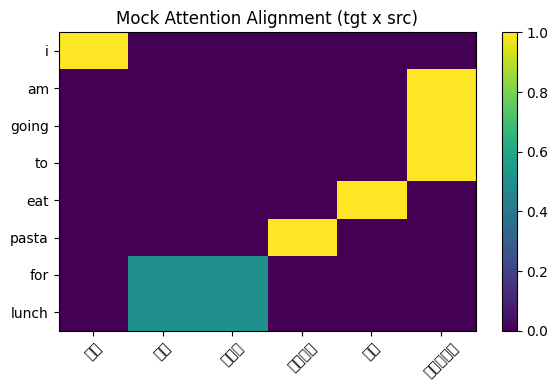

In [ ]:
import re
import time
import math
import numpy as np

# ------------------------------
# Utilities
# ------------------------------
SRC_SENT = "나는 점심 식사로 파스타를 먹을 예정입니다."
EXPECTED = "I am going to eat pasta for lunch."


def pretty(s: str) -> str:
    s = re.sub(r"\s+", " ", s).strip()
    s = s[0:1].upper() + s[1:] if s else s
    if not s.endswith("."):
        s += "."
    return s


def timer(func, *args, **kwargs):
    t0 = time.perf_counter()
    out = func(*args, **kwargs)
    t1 = time.perf_counter()
    return out, (t1 - t0)

# ------------------------------
# 1) RNN-style (naive L2R)
# ------------------------------
def tokenize_ko(text: str):
    # Basic whitespace + punctuation split, keep simple for demo
    text = re.sub(r"[^\w\s가-힣]", " ", text)
    toks = [t for t in text.split() if t.strip()]
    return toks

# Minimal dictionary for demo (phrase & token level)
PHRASES = {
    "먹을 예정입니다": "am going to eat",
    "점심 식사로": "for lunch",
}

LEXICON = {
    "나는": "i",
    "점심": "lunch",
    "식사로": "for lunch",
    "파스타를": "pasta",
    "먹을": "eat",
    "예정입니다": "going to",
}

def translate_rnn_rule(text: str) -> str:
    # Left-to-right mapping without reordering (shows RNN baseline weakness on SOV→SVO)
    # Apply phrase map first if exact phrase appears
    out = text
    for k, v in PHRASES.items():
        out = out.replace(k, v)

    toks = tokenize_ko(out)
    print(f'toks : {toks}')

    eng = []
    for tok in toks:
        if tok in LEXICON:
            eng.append(LEXICON[tok])
        elif tok in PHRASES:
            eng.append(PHRASES[tok])
        elif tok == "파스타":
            eng.append("pasta")
        else:
            # leave as-is (unknown token)
            eng.append(tok)

    # naive L2R join
    return pretty(" ".join(eng))

# ------------------------------
# 2) Seq2Seq-style (encoder-decoder with reordering rules)
# ------------------------------
def translate_seq2seq_rule(text: str) -> str:
    # Simulate encoder-decoder that learns typical Korean SOV → English SVO reordering
    # Pattern: "나는 X를 먹을 예정입니다" -> "i am going to eat X"
    # and attach "for lunch" if phrase occurs
    s = text

    # detect object phrase like "파스타를"
    obj = None
    m = re.search(r"(.*?)(파스타)를", s)
    if m:
        obj = "pasta"

    # lunch phrase
    lunch = "for lunch" if "점심" in s else None

    base = "i am going to eat"
    if obj:
        out = f"{base} {obj}"
    else:
        out = base

    if lunch:
        out = f"{out} {lunch}"
    return pretty(out)

# ------------------------------
# 3) Attention-style (alignment-guided + mock attention matrix)
# ------------------------------
def translate_attention_rule(text: str, return_attention=False):
    # Tokenize Korean source
    src_tokens = ["나는", "점심", "식사로", "파스타를", "먹을", "예정입니다"]
    # Target template tokens (SVO + adjunct)
    tgt_tokens = ["i", "am", "going", "to", "eat", "pasta", "for", "lunch"]

    # Create a mock attention alignment matrix (len(tgt) x len(src))
    A = np.zeros((len(tgt_tokens), len(src_tokens)), dtype=float)

    # Rough alignments
    align = {
        0: [0],              # i  <- 나는
        1: [5],              # am <- 예정입니다
        2: [5],              # going
        3: [5],              # to
        4: [4],              # eat <- 먹을
        5: [3],              # pasta <- 파스타를
        6: [1,2],            # for <- 점심 식사로
        7: [1,2],            # lunch <- 점심 식사로
    }
    for t_idx, s_list in align.items():
        for s_idx in s_list:
            A[t_idx, s_idx] = 1.0 / len(s_list)

    out = "i am going to eat pasta for lunch"
    out = pretty(out)

    if return_attention:
        return out, A, src_tokens, tgt_tokens
    return out

# ------------------------------
# 4) Transformer (real pretrained model if available)
# ------------------------------
def translate_transformer_hf(text: str) -> str:
    try:
        from transformers import MarianTokenizer, MarianMTModel
        import torch

        model_name = "Helsinki-NLP/opus-mt-ko-en"
        tokenizer = MarianTokenizer.from_pretrained(model_name)
        model = MarianMTModel.from_pretrained(model_name)

        batch = tokenizer([text], return_tensors="pt", padding=True)
        with torch.no_grad():
            gen = model.generate(**batch, max_length=64, num_beams=5)
        out = tokenizer.batch_decode(gen, skip_special_tokens=True)[0]
        return pretty(out)
    except Exception as e:
        # Fallback: use the seq2seq rule-based output
        return translate_seq2seq_rule(text)

# ------------------------------
# Simple scorer: token precision vs expected
# ------------------------------
def token_precision(pred: str, ref: str) -> float:
    p = re.findall(r"[a-zA-Z']+", pred.lower())
    r = re.findall(r"[a-zA-Z']+", ref.lower())
    if not p or not r:
        return 0.0
    hit = sum(1 for w in p if w in r)
    return hit / len(p)

# ------------------------------
# Main comparison
# ------------------------------
def main():
    print("Source (KO):", SRC_SENT)
    print("Expected (EN):", EXPECTED)
    print("="*72)

    # 1) RNN (rule)
    rnn_out, t_rnn = timer(translate_rnn_rule, SRC_SENT)
    # 2) Seq2Seq (rule)
    s2s_out, t_s2s = timer(translate_seq2seq_rule, SRC_SENT)
    # 3) Attention (rule + mock attention)
    att_out, t_att = timer(translate_attention_rule, SRC_SENT)
    # 4) Transformer (real model if available)
    trf_out, t_trf = timer(translate_transformer_hf, SRC_SENT)


    rows = [
        ("RNN (rule)", rnn_out, t_rnn, token_precision(rnn_out, EXPECTED)),
        ("Seq2Seq (rule)", s2s_out, t_s2s, token_precision(s2s_out, EXPECTED)),
        ("Attention (rule)", att_out, t_att, token_precision(att_out, EXPECTED)),
        ("Transformer (HF)", trf_out, t_trf, token_precision(trf_out, EXPECTED)),
    ]

    print()
    print(f"{'Model':<18} | {'Output':<45} | Time(s) | TokenPrec")
    print("-"*90)
    for name, out, t, prec in rows:
        print(f"{name:<18} | {out:<45} | {t:>6.3f} | {prec:>0.3f}")

    # Optional: visualize mock attention with matplotlib if available
    try:
        import matplotlib.pyplot as plt
        att_out2, A, src, tgt = translate_attention_rule(SRC_SENT, return_attention=True)
        plt.figure(figsize=(6,4))
        plt.imshow(A, aspect='auto')
        plt.yticks(range(len(tgt)), tgt)
        plt.xticks(range(len(src)), src, rotation=45)
        plt.title("Mock Attention Alignment (tgt x src)")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

if __name__ == "__main__":
    main()

